In [222]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'timezone', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:917: UserWarning: axes.ho

Changes from previous versions:
- Constrain spacing by photoreceptor spacing
- Constrain width by visual field of salamander retina  
- Constrain output power instead of output variance

In [2]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


### Load receptive fields

In [3]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [4]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

### Compute projective fields

In [5]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

In [6]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

### Signal

In [7]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches, spacing=spacing)

Only 70 files in directory.


In [8]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_signal, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt_signal)
signal = func(freqs, *popt_signal)
signal[0] = np.sqrt(np.sum(signal[1:]))

[ 0.0056951   1.01550079]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [9]:
input_noise = 0.098762200628786892
output_noise = 0.35
target_power = 54.131410989171826

1.92576130327


/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


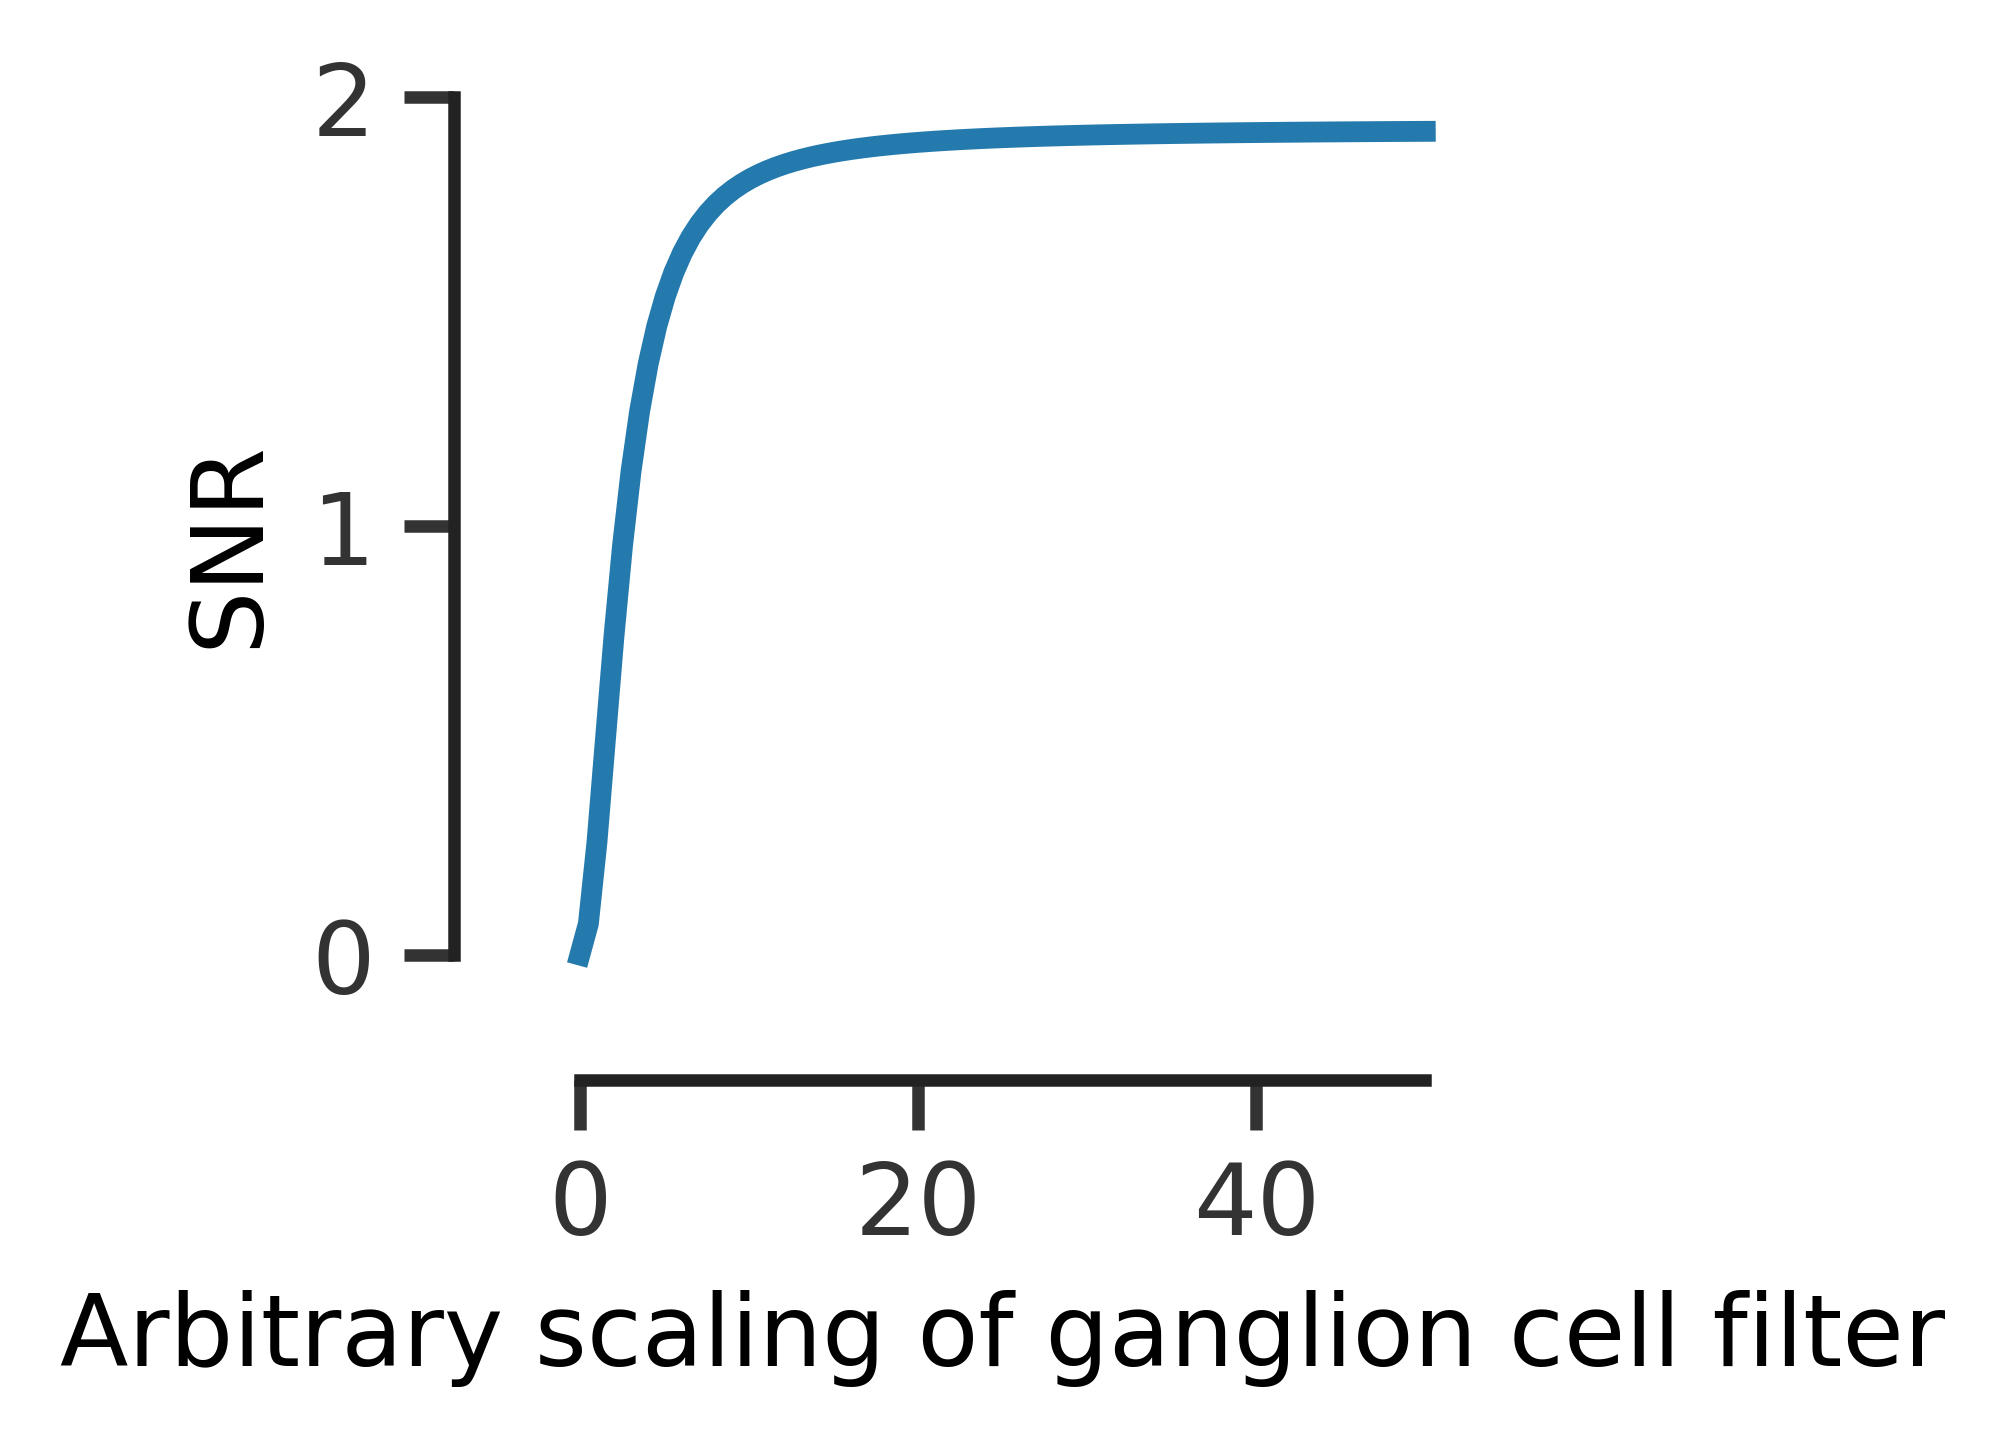

In [10]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

In [11]:
# SNR = 0.269 is total SNR from ganglion recordings of 112 repeats to 30 seconds natural scenes
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, output_noise, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

print(get_snr(input_noise, output_noise, signal, filt_const_opt.x*average_ganglion_fft, mode='variance'))

0.269124689452


### Ideal filter

In [12]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 2.44689914079e-07.


### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [13]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

Load David's 1721 ganglion cells

In [14]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

In [15]:
for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

Get center widths for each celltype

In [16]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [17]:
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [18]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

772it [01:34, 11.70it/s]
253it [01:51,  5.42it/s]
321it [00:49,  8.50it/s]
249it [00:55,  5.97it/s]
28it [00:09,  1.13it/s]
126it [00:32,  5.31it/s]


In [19]:
for f in fit_failures.keys():
    print("couldn't fit %d in %s" %(len(fit_failures[f]), f))

couldn't fit 31 in slow_off
couldn't fit 7 in medium_off_adapting
couldn't fit 5 in fast_on
couldn't fit 4 in fast_off_adapting
couldn't fit 5 in fast_off_sensitizing
couldn't fit 3 in ganglion


Plot the average profile across celltypes

In [20]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

In [21]:
median_center_widths

{'fast_off_adapting': 1.6921005209471627,
 'fast_off_sensitizing': 2.0511624440316076,
 'fast_on': 1.9647399410647877,
 'ganglion': 1.3731413963691115,
 'medium_off_adapting': 1.5794333469897559,
 'slow_off': 1.5642116399679997}

Bar charts to visualize diversity

## Run info maps

In [22]:
resolution = 150
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [23]:
init_filt_const = 10.9
info_maps = collections.defaultdict(list) # one info map per celltype (since they will be a function of center width)
failures = collections.defaultdict(list)
detailed_failures = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
        center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
        
        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
        
#         print('Information map for %s cells.' %celltype)
        
        infomap = np.zeros((resolution, resolution))
        for idh,hw in tqdm(enumerate(horz_weights)):
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))
                
                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    output_power = np.sum((signal*filt_const*rf_filt)**2 
                                          + (input_noise*filt_const*rf_filt)**2
                                          + output_noise**2)
                    
                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                iterations = 0
                new_init_filt_const = init_filt_const
                while not filt_const_opt.success:
                    iterations += 1
                    new_init_filt_const *= 10
                    filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                    if iterations > 10:
                        detailed_failures[celltype] = filt_const_opt
                        break
                
                filt_const = abs(filt_const_opt['x'])
                
                if not filt_const_opt.success:
                    failures[celltype].append([hw, cw])

                signal_power = (filt_const * rf_filt * signal)**2
                noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
                infomap[idh,idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
        info_maps[celltype] = infomap

150it [00:31,  4.85it/s]
150it [00:31,  4.81it/s]
150it [00:31,  4.90it/s]
150it [00:31,  4.76it/s]
150it [00:31,  4.83it/s]
150it [00:31,  4.81it/s]


## Fit cells to rf_model

In [24]:
colorscheme = {
    'ganglion': 'k',
    'fast_off_sensitizing': 'r',
    'fast_off_adapting': 'g',
    'slow_off': 'y',
    'fast_on': 'b',
    'medium_off_adapting': 'c'
}

## Fit cells

In [30]:
iterations = 25

fits = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(receptive_fields[celltype])):

            def rf_model(width, mean, horz_weight, center_weight):
                horz_weight = np.min([1.0, abs(horz_weight)])
                center_weight = np.min([1.0, abs(center_weight)])
                
                center = gaussian(x=space, sigma=abs(width), mu=mean)
                center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
                
                return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
            
            def model_error_to_ganglion_cells(weights):
                width, mean = weights[:2]
                hw, cw = weights[-2:]
                modeled_rf = rf_model(width, mean, hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                return sum(abs(normed_rf - rf))

            best_fit_err = np.inf
            for itr in range(iterations):
                this_popt = minimize(model_error_to_ganglion_cells, np.hstack([center_widths[celltype][i],
                                                                               0.01,
                                                                               np.random.rand(2)]))
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            modeled_rf = rf_model(*popt.x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
            x = np.where(abs(popt.x) > 1, 1, abs(popt.x))

            popts.append(x)
            abs_errors[celltype].append(popt.fun)
            mean_squared_errors[celltype].append(mse)
            variances[celltype].append(np.var(rf))

        fits[celltype] = np.stack(popts)


0it [00:00, ?it/s]
80it [32:00, 23.54s/it]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
89it [35:27, 23.64s/it]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
237it [1:34:42, 23.56s/it]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
240it [1:36:01, 25.72s/it]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
242it [1:36:48, 24.50s/it]/u

In [32]:
fits['medium_off_adapting'][:10,0]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


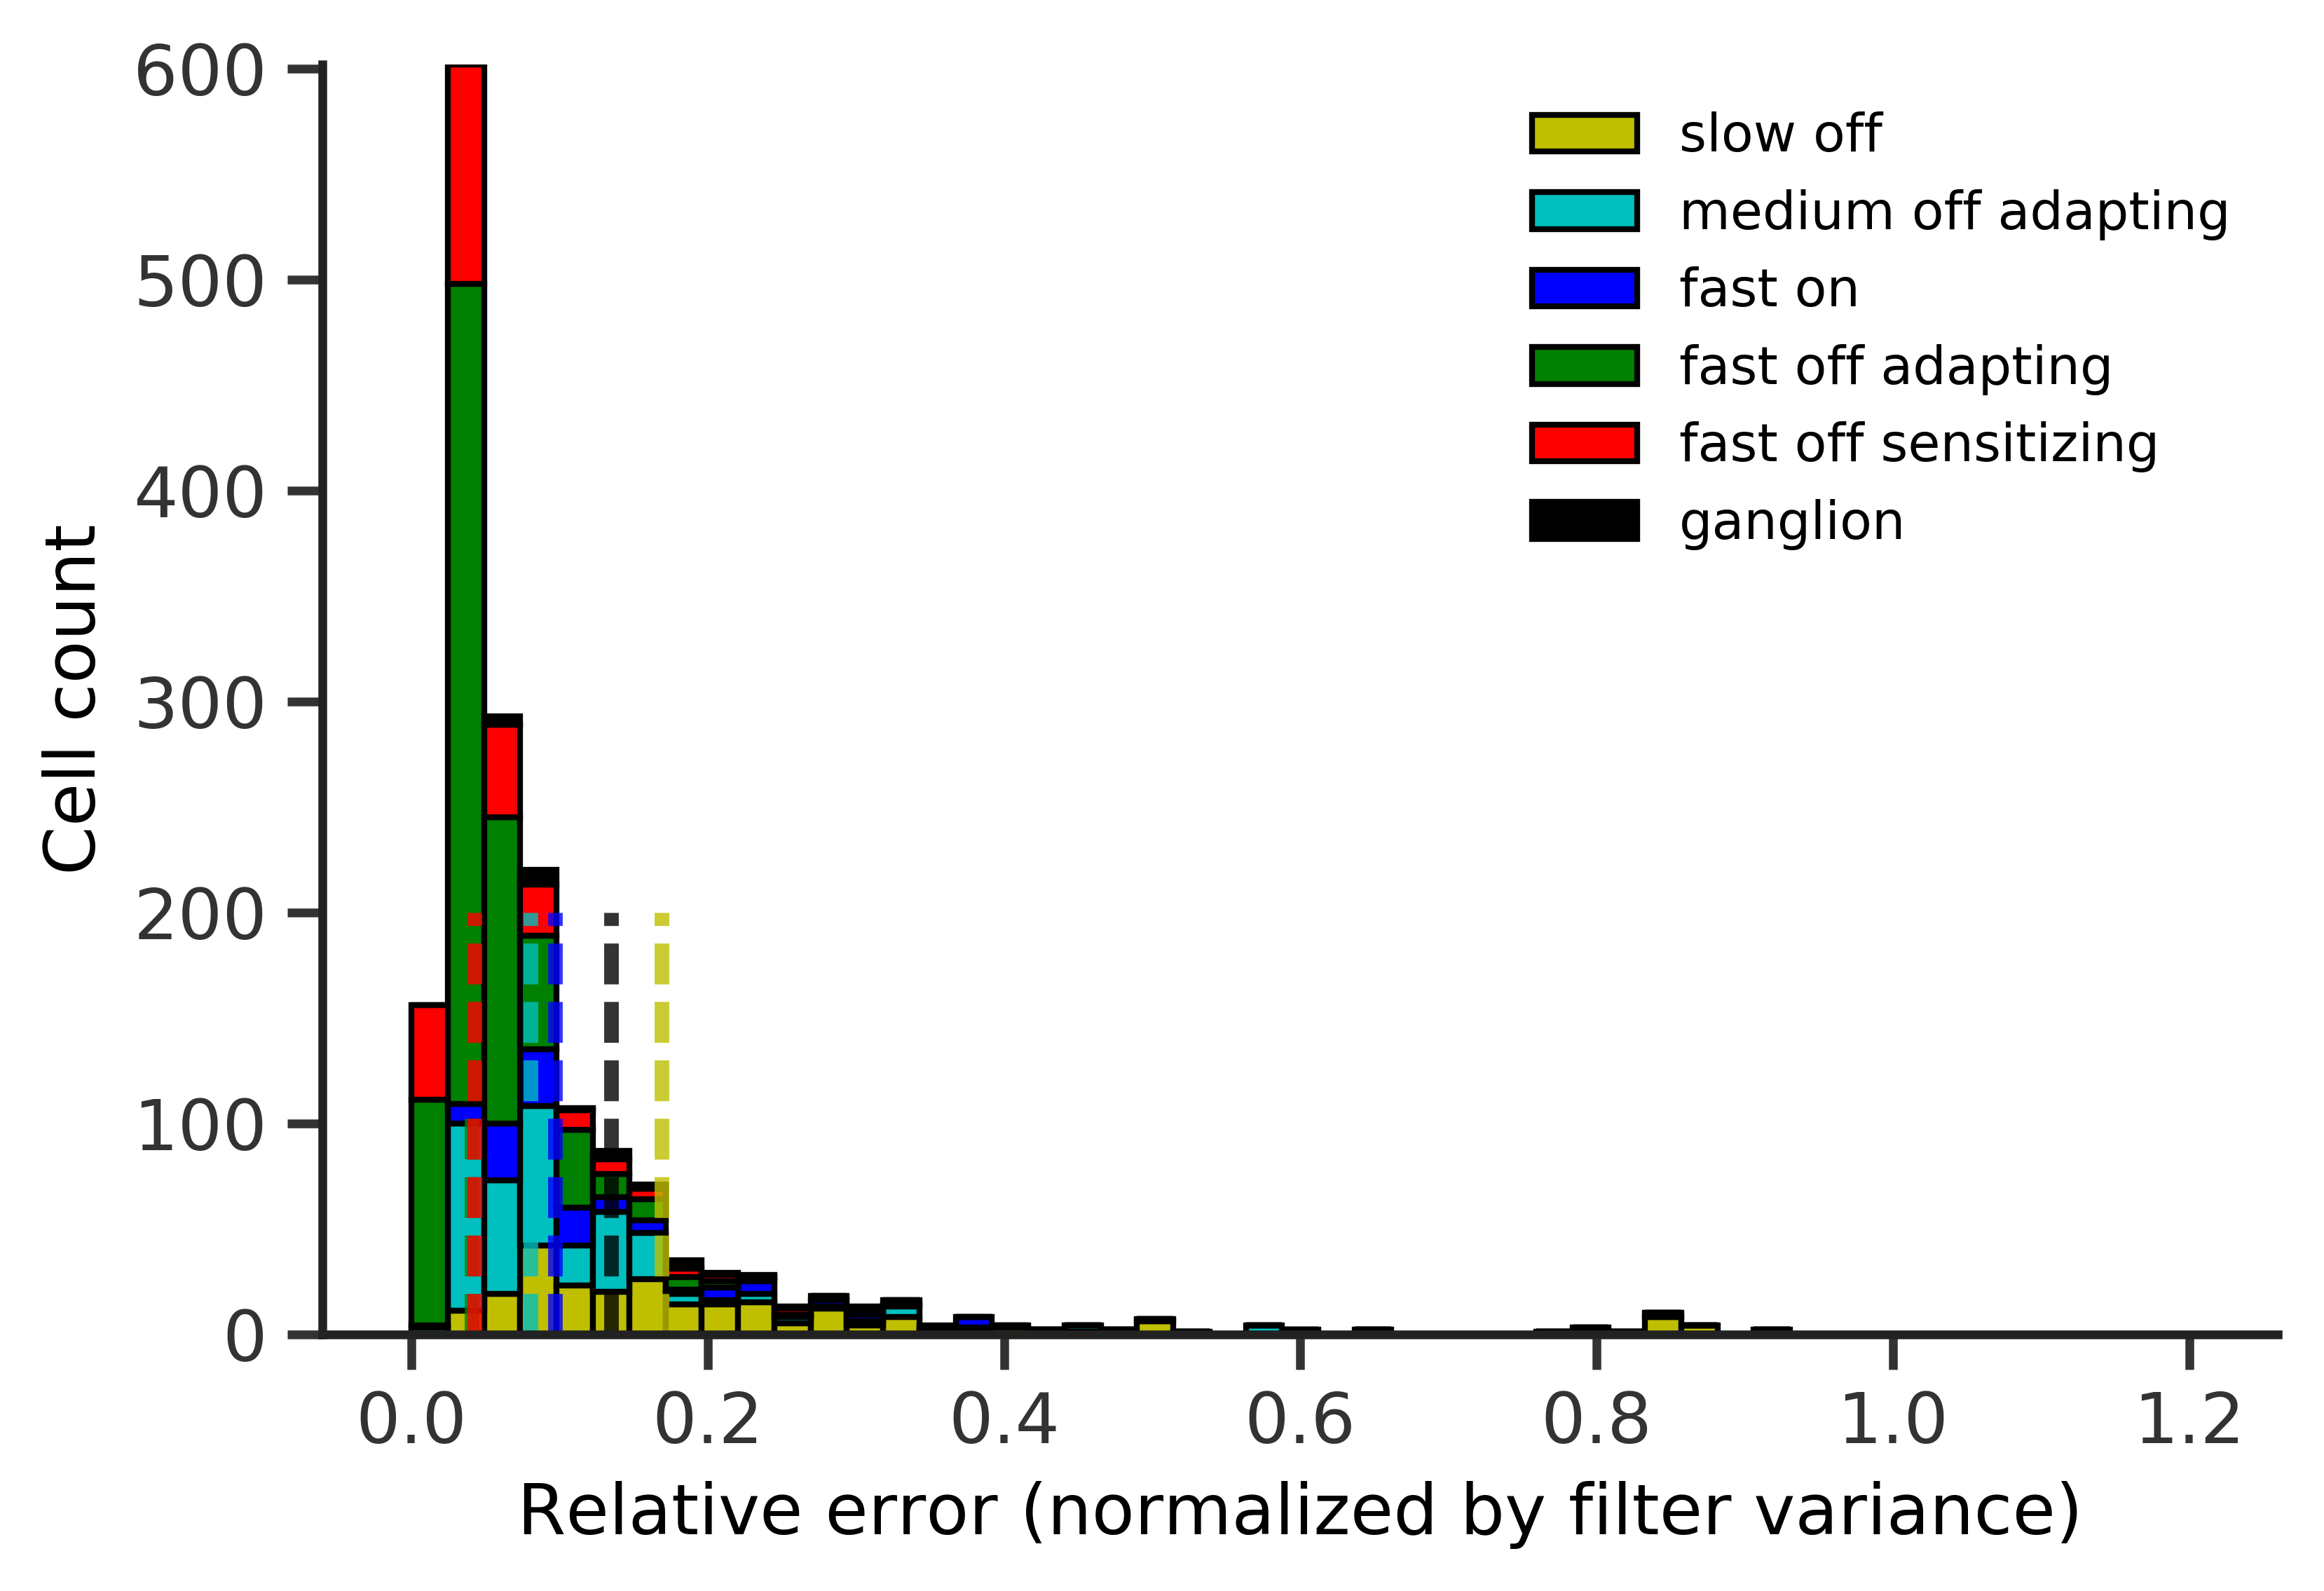

In [35]:
bins = np.linspace(0,1.2,50)
bin_width = np.mean(np.diff(bins))
prev_count = np.zeros_like(bins[:-1])
for celltype in mean_squared_errors.keys():
    rel_error = np.array(mean_squared_errors[celltype])/np.array(variances[celltype])
    count, bins = np.histogram(rel_error, bins=bins)

    plt.bar(bins[:-1]+bin_width/2, count, width=bin_width, color=colorscheme[celltype], 
            label=' '.join(celltype.split('_')), edgecolor='k', bottom=prev_count)
    prev_count += count
    
    plt.vlines(np.median(rel_error), 0, 200, color=colorscheme[celltype], linestyle='--', alpha=0.8)

plt.legend(loc='upper right', frameon=False, fontsize=9)
plt.xlabel('Relative error (normalized by filter variance)')
plt.ylabel('Cell count')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# plt.ylim(0,200)
# plt.savefig('Percent variance explained by model with median.png')

In [39]:
fits[celltype][:,-2:].shape

(253, 2)

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


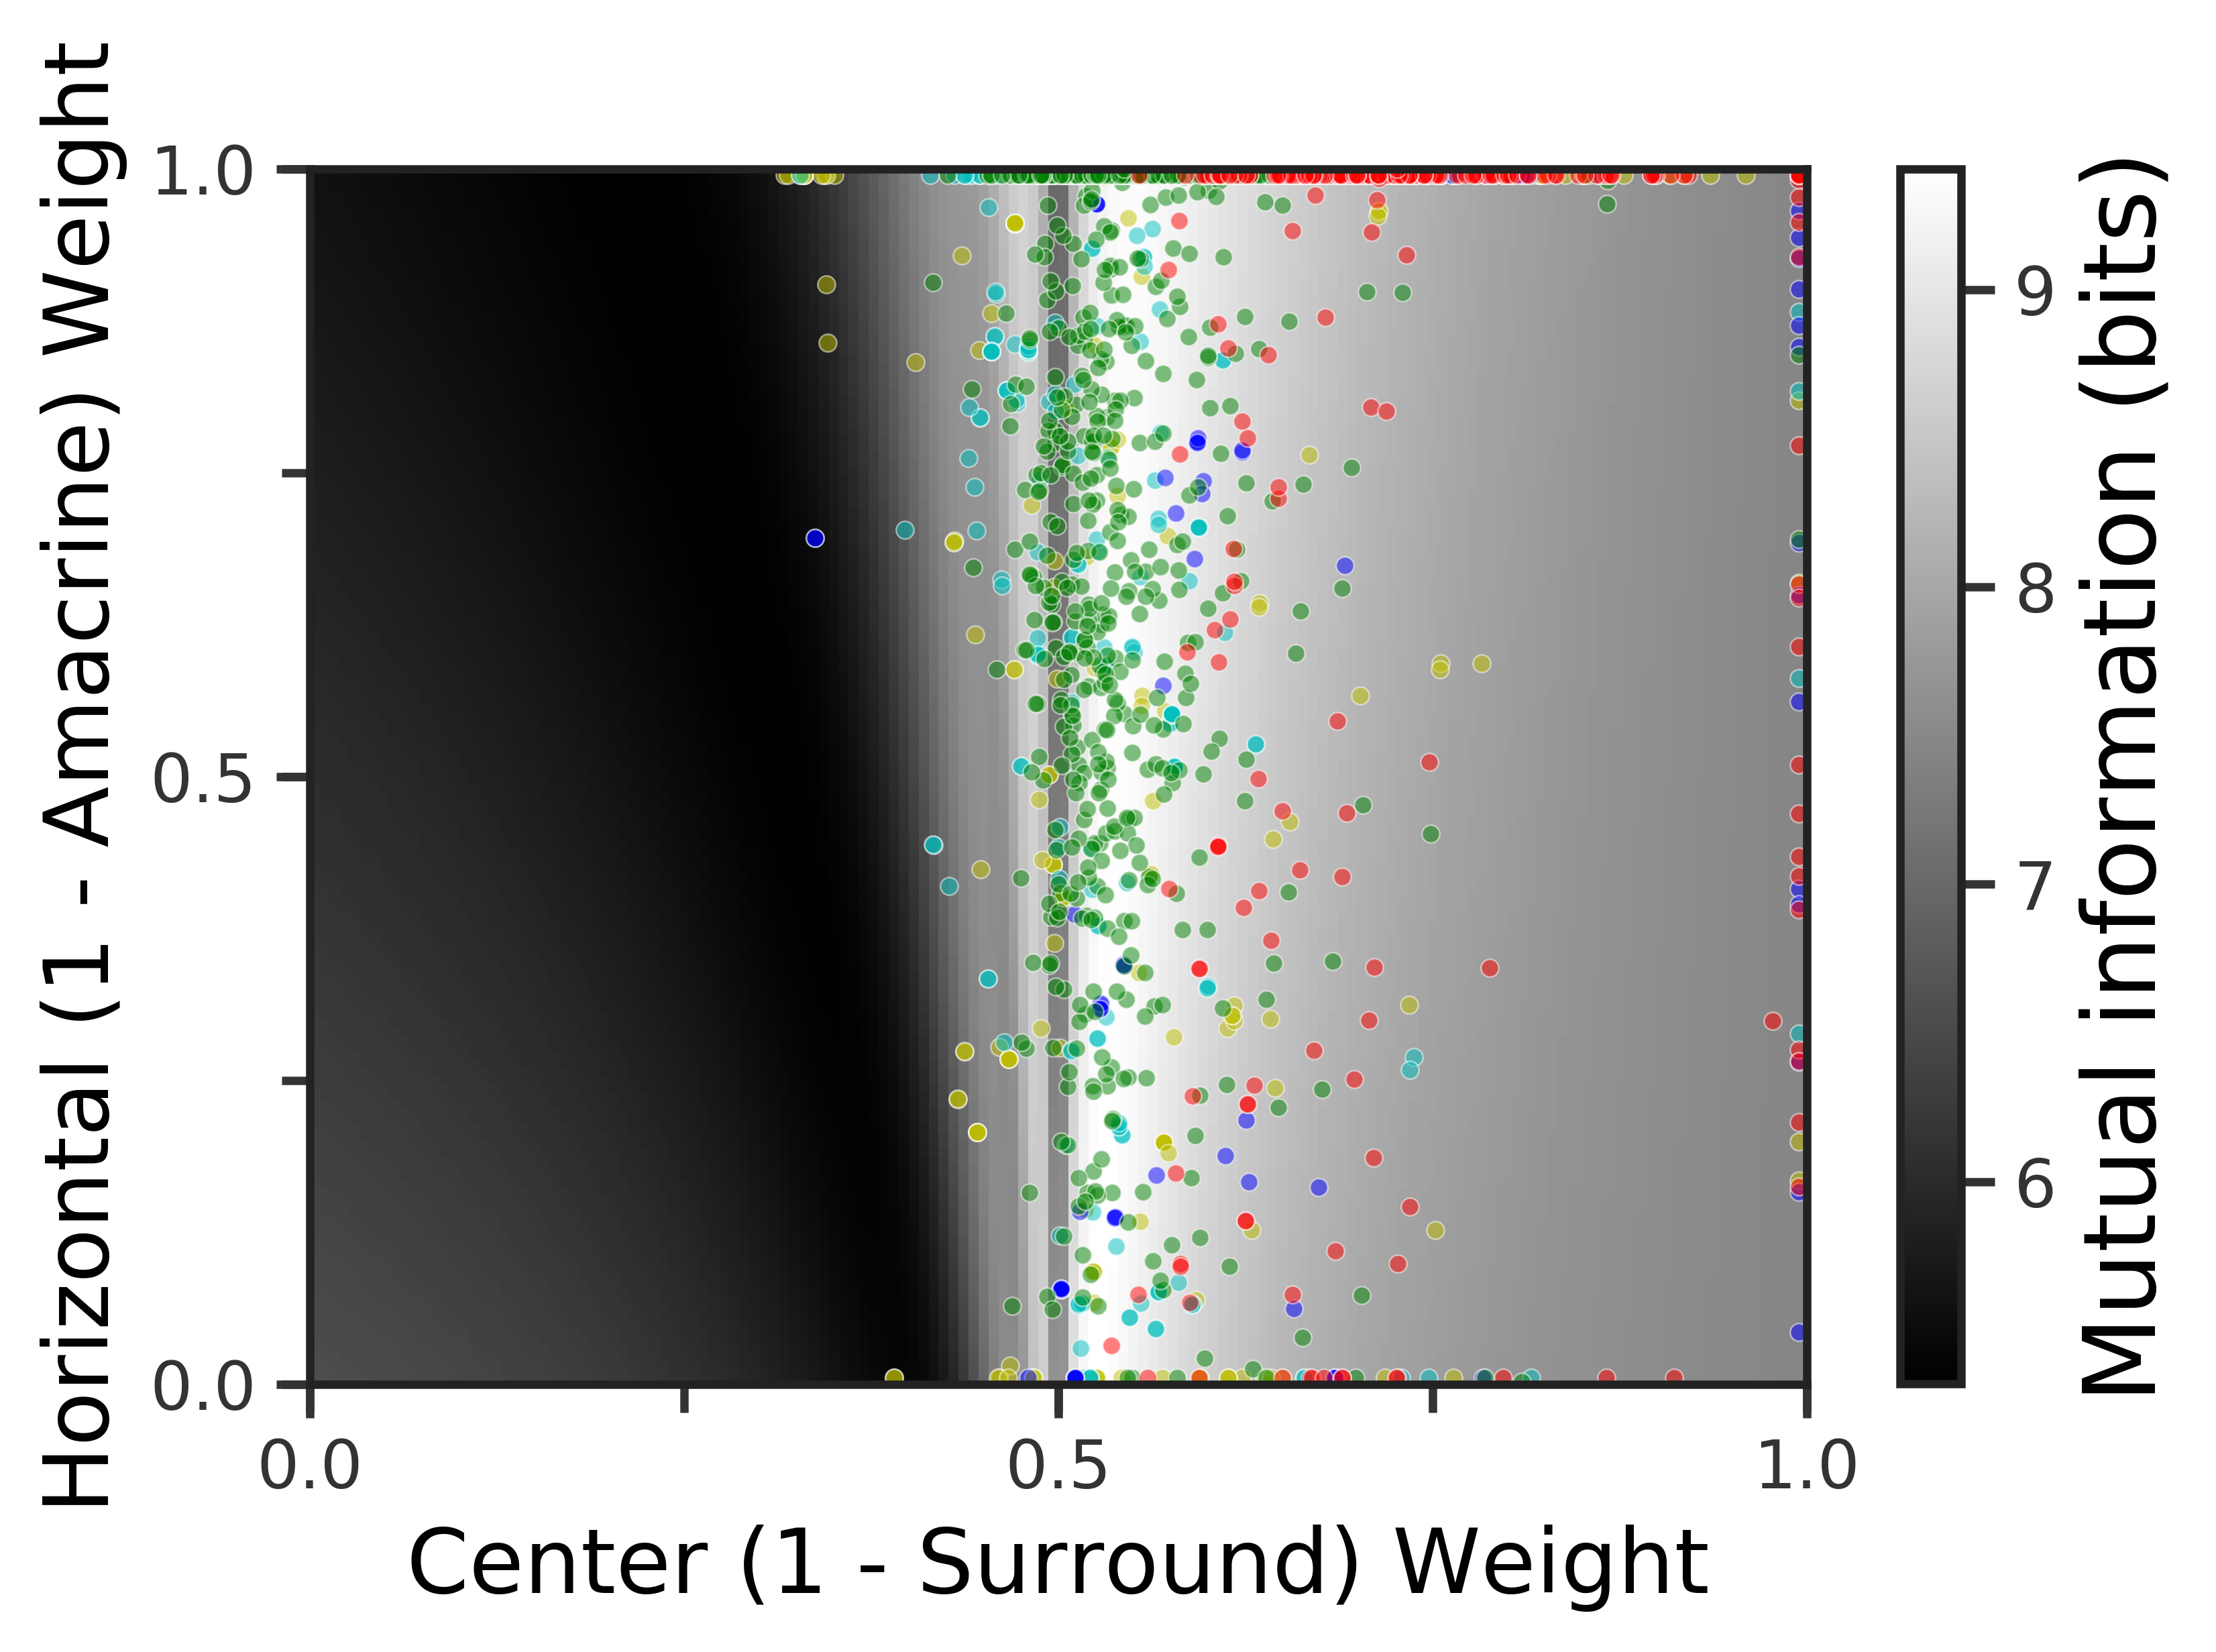

In [40]:
min_info = np.min(info_maps['medium_off_adapting'])
max_info = np.max(info_maps['medium_off_adapting'])

plt.imshow(info_maps['medium_off_adapting'], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
cbar.set_ticks([6,7,8,9])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)

for idc, celltype in enumerate([k for k in info_maps.keys() if k != 'ganglion']):
    these_fits = fits[celltype][:,-2:]
    # make the points lying on the edges more visible
    adjusted_fits1 = np.where(these_fits == 1, 0.995, these_fits)
    adjusted_fits = np.where(adjusted_fits1 < 0.001, 0.005, adjusted_fits1)
    plt.scatter(adjusted_fits[:,1], adjusted_fits[:,0],
                c=colorscheme[celltype], edgecolor='w', s=10, alpha=0.5, label=' '.join(celltype.split('_')),
                linewidth=0.3)
#     plt.scatter(adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,1],
#                adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,0],
#                c=colorscheme[celltype], edgecolor='k', s=60, marker='*', linewidth=0.7)


# plt.quiver(ideal_fit[1], ideal_fit[0], average_variance_direction[0], average_variance_direction[1],
#            angles='xy', scale_units='xy', scale=2.5, color='k', edgecolor='w', width=0.012, linewidth=1,
#           alpha=0.9)
# plt.quiver(ideal_fit[1], ideal_fit[0], average_least_info_direction[0], average_least_info_direction[1],
#            angles='xy', scale_units='xy', scale=2.5, color='w', edgecolor='k',
#           alpha=0.7, width=.012, linewidth=1.2)
# plt.scatter(ideal_fit[1], ideal_fit[0], c='k', edgecolor='k', s=150, marker='*', linewidth=0.7)

# l = plt.legend(loc='upper left', frameon=False, fontsize=8)
# for text in l.get_texts():
#     text.set_color("white")
plt.ylim([0,1])
plt.xlim([center_weights[0], center_weights[-1]])


# specify ticks
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
# plt.yticks([0, 0.25, 0.5, 0.75, 1])
majorLocator = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

# plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center (1 - Surround) Weight', fontsize=16)
plt.ylabel('Horizontal (1 - Amacrine) Weight', fontsize=16)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# plt.savefig('Figures for Steve IV.png')

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


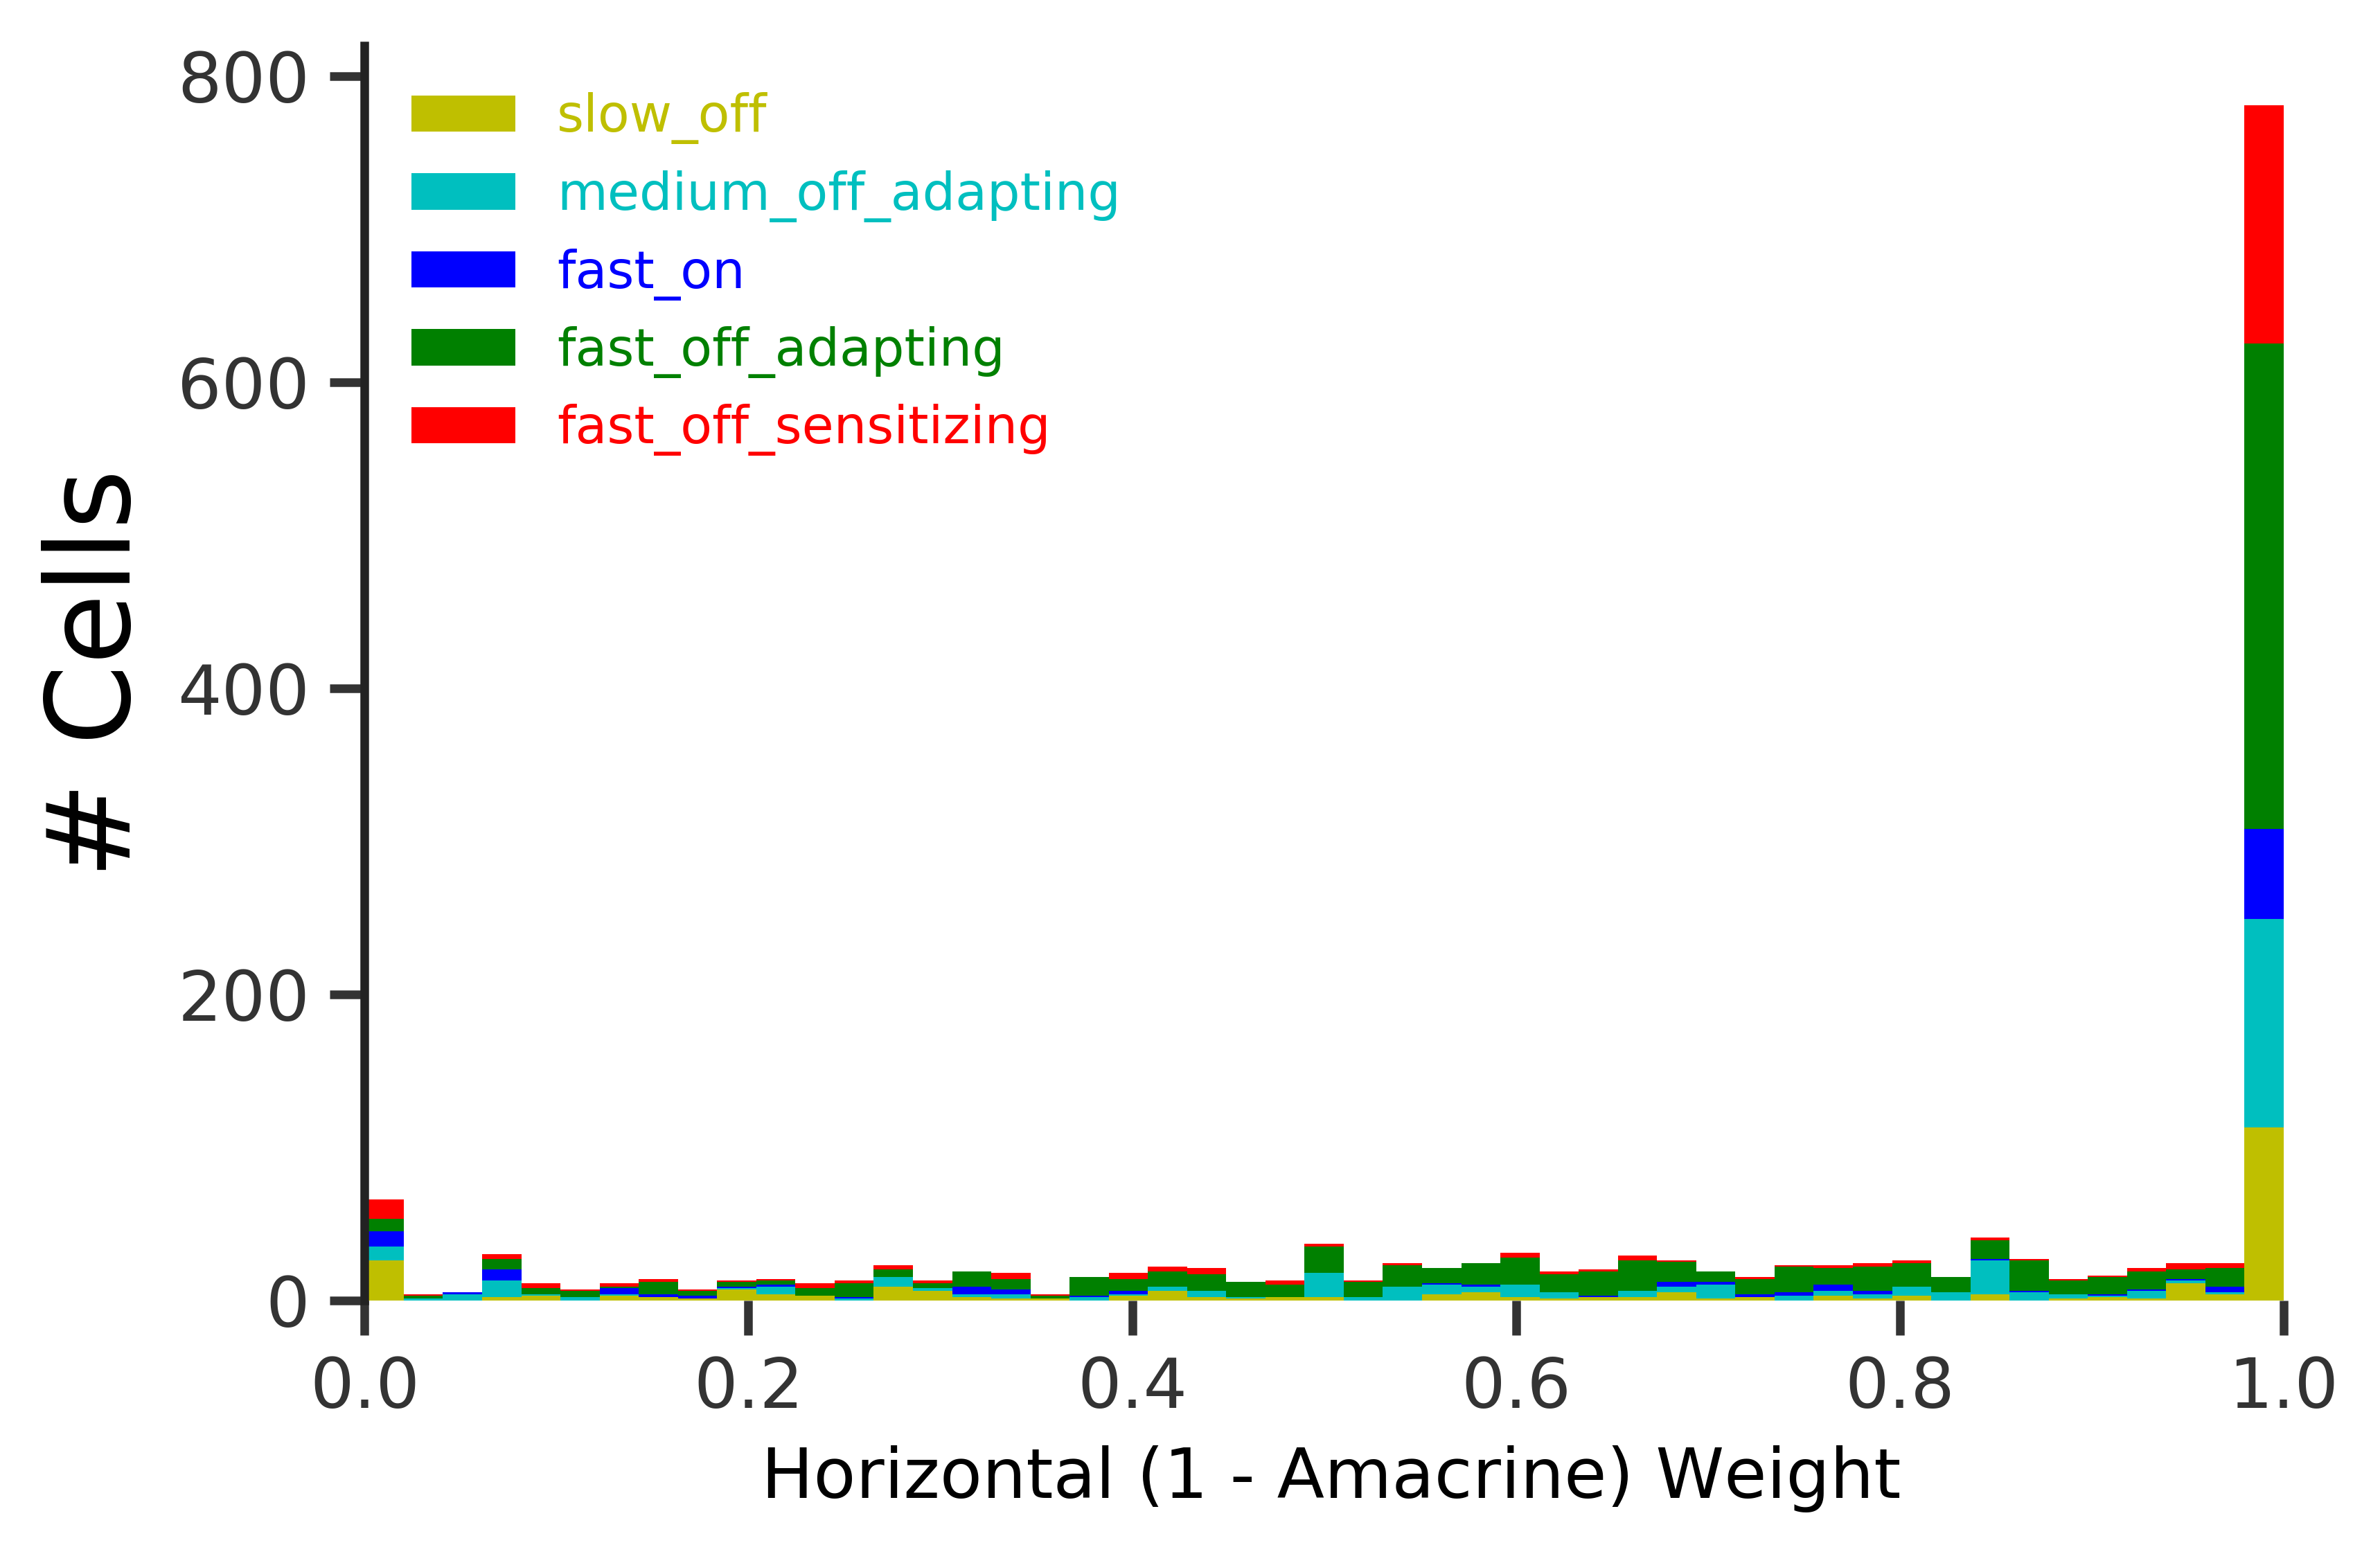

In [42]:
fig = plt.gcf()
ax = plt.gca()

# Histogram
bin_edges = np.linspace(0, 1, 50)
bin_width = np.mean(np.diff(bin_edges))
prev_count = np.zeros_like(bin_edges[:-1])
for c, celltype in enumerate(fits.keys()):
    if celltype != 'ganglion':
        this_count, bins = np.histogram(np.stack(fits[celltype])[:, 2], bins=bin_edges)
        ax.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
               bottom=prev_count, linewidth=0.5, label=' '.join(celltype.split(' ')))
        prev_count += this_count
        
l = plt.legend(frameon=False, fontsize=9, loc='upper left')
for text in l.get_texts():
    splitlabel = text.properties()['text'].split(' ')
    text.set_color(colorscheme['_'.join(splitlabel)])

        

plt.xlim(0,1.007)
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('# Cells', color='k', fontsize=20)
ax.set_xlabel('Horizontal (1 - Amacrine) Weight')
# ax.set_ylim(0,300)
# ax.set_yticks([0,100,200,300])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['bottom'].set_visible(False)

# ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')



majorLocator = MultipleLocator(200)
majorFormatter = FormatStrFormatter('%d')

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.xaxis.set_minor_locator(minorLocator)

# ax.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())
# plt.xlabel('Center (1 - surround) weight')
# plt.ylabel('# Cells')
# plt.savefig('1d y-axis distribution 3-2.png')

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


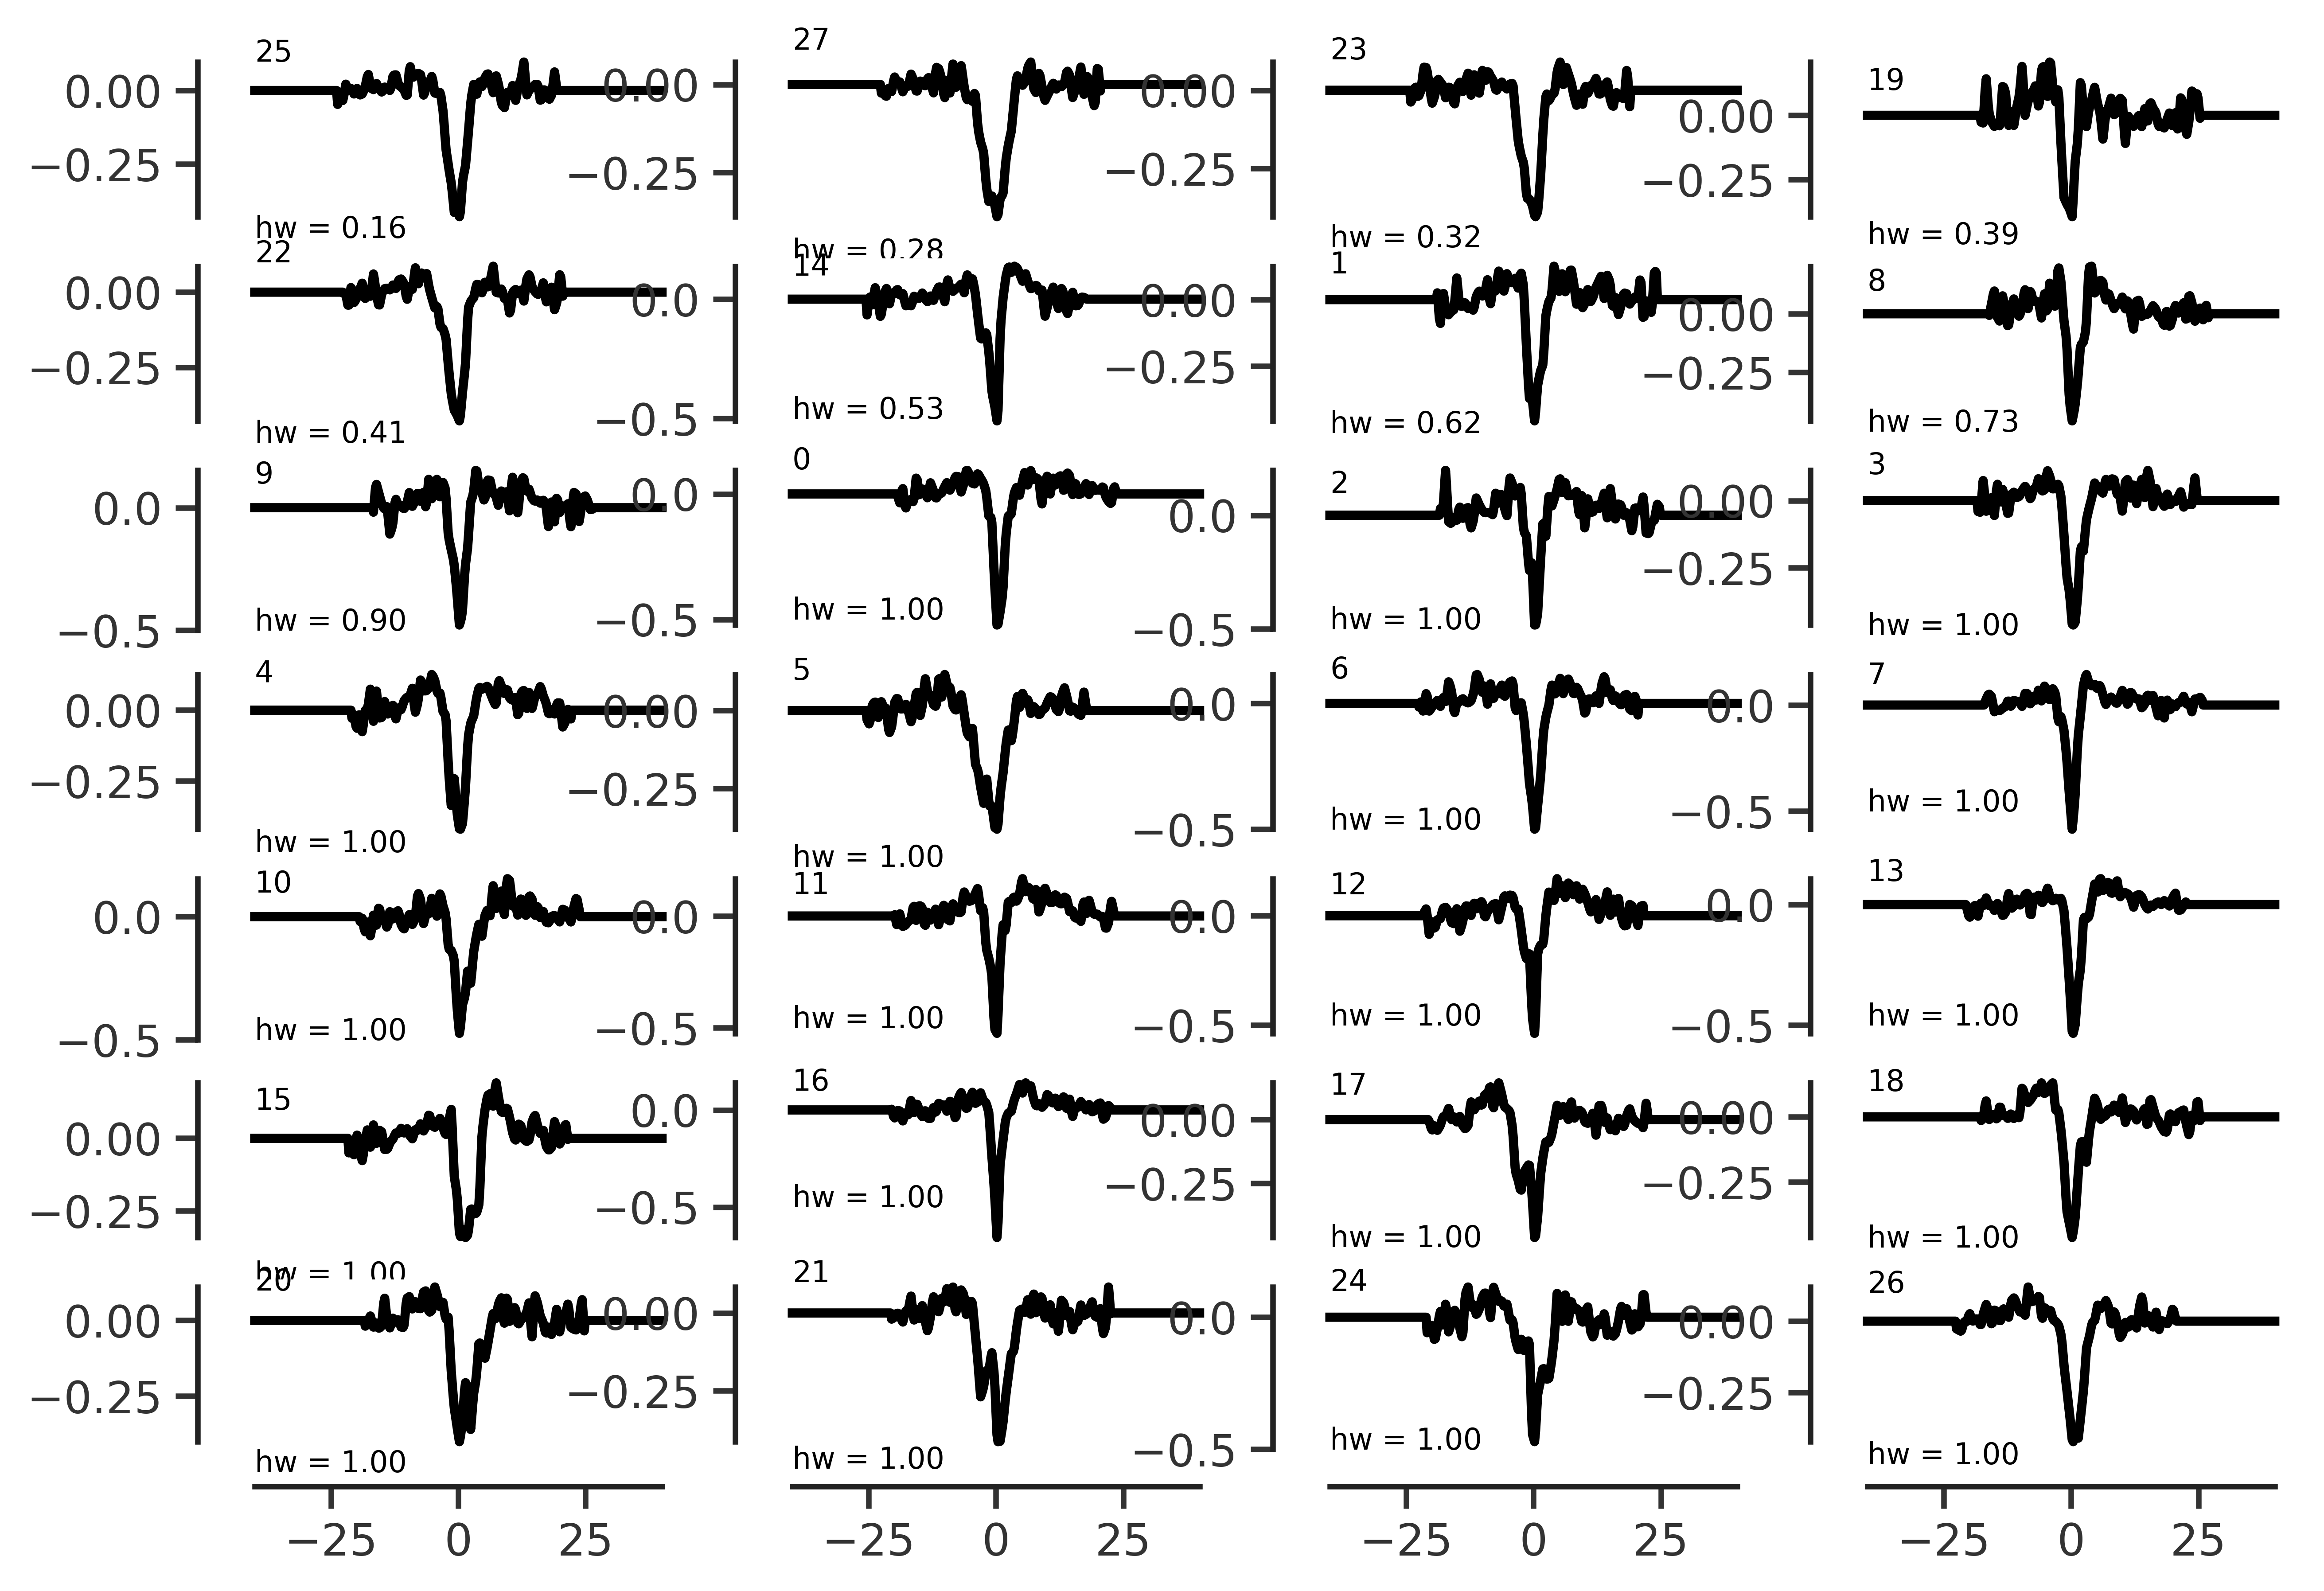

In [44]:
fig = plt.gcf()
fig.set_size_inches((10,10))

for celltype in fits.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                'medium_off_adapting', 'slow_off']:
        count = 0
        plt.clf()
        sorted_rf_ids = [x for (y,x) in sorted(zip(fits[celltype][:,2],
                                                  np.arange(fits[celltype].shape[0])))]
        for i,idf in enumerate(sorted_rf_ids):
            plt.subplot(10,4, count % 40 + 1)
            plt.plot(space, receptive_fields[celltype][idf], 'k')
            plt.text(-40, 0.1, '%d' %idf, fontsize=8)
            plt.text(-40, -0.5, 'hw = %0.2f' %fits[celltype][idf][2], fontsize=8)
            adjust_spines(plt.gca())
            count += 1

            if count % 40 == 0:
                if count >= 40:
                    page_num = int(count/40)
                    plt.savefig('%s rfs page %d.png' %(celltype, page_num))
                    plt.clf()
    

# Check for duplicates

In [75]:
corr_map = {}
for celltype in receptive_fields.keys():
    corr_map[celltype] = np.zeros((len(receptive_fields[celltype]), len(receptive_fields[celltype])))
    for idr1, rf1 in tqdm(enumerate(receptive_fields[celltype])):
        for idr2 in range(idr1+1, len(receptive_fields[celltype])):
            rf2 = receptive_fields[celltype][idr2]
            corr_map[celltype][idr1, idr2] = pearsonr(rf1, rf2)[0]

772it [00:19, 40.27it/s] 
253it [00:02, 122.60it/s]
321it [00:03, 97.41it/s] 
2it [00:00, 10242.50it/s]
249it [00:02, 123.93it/s]
2it [00:00, 15592.21it/s]
28it [00:00, 1123.59it/s]
126it [00:00, 246.57it/s]
2it [00:00, 8895.66it/s]


In [76]:
len(corr_map.keys())

9

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


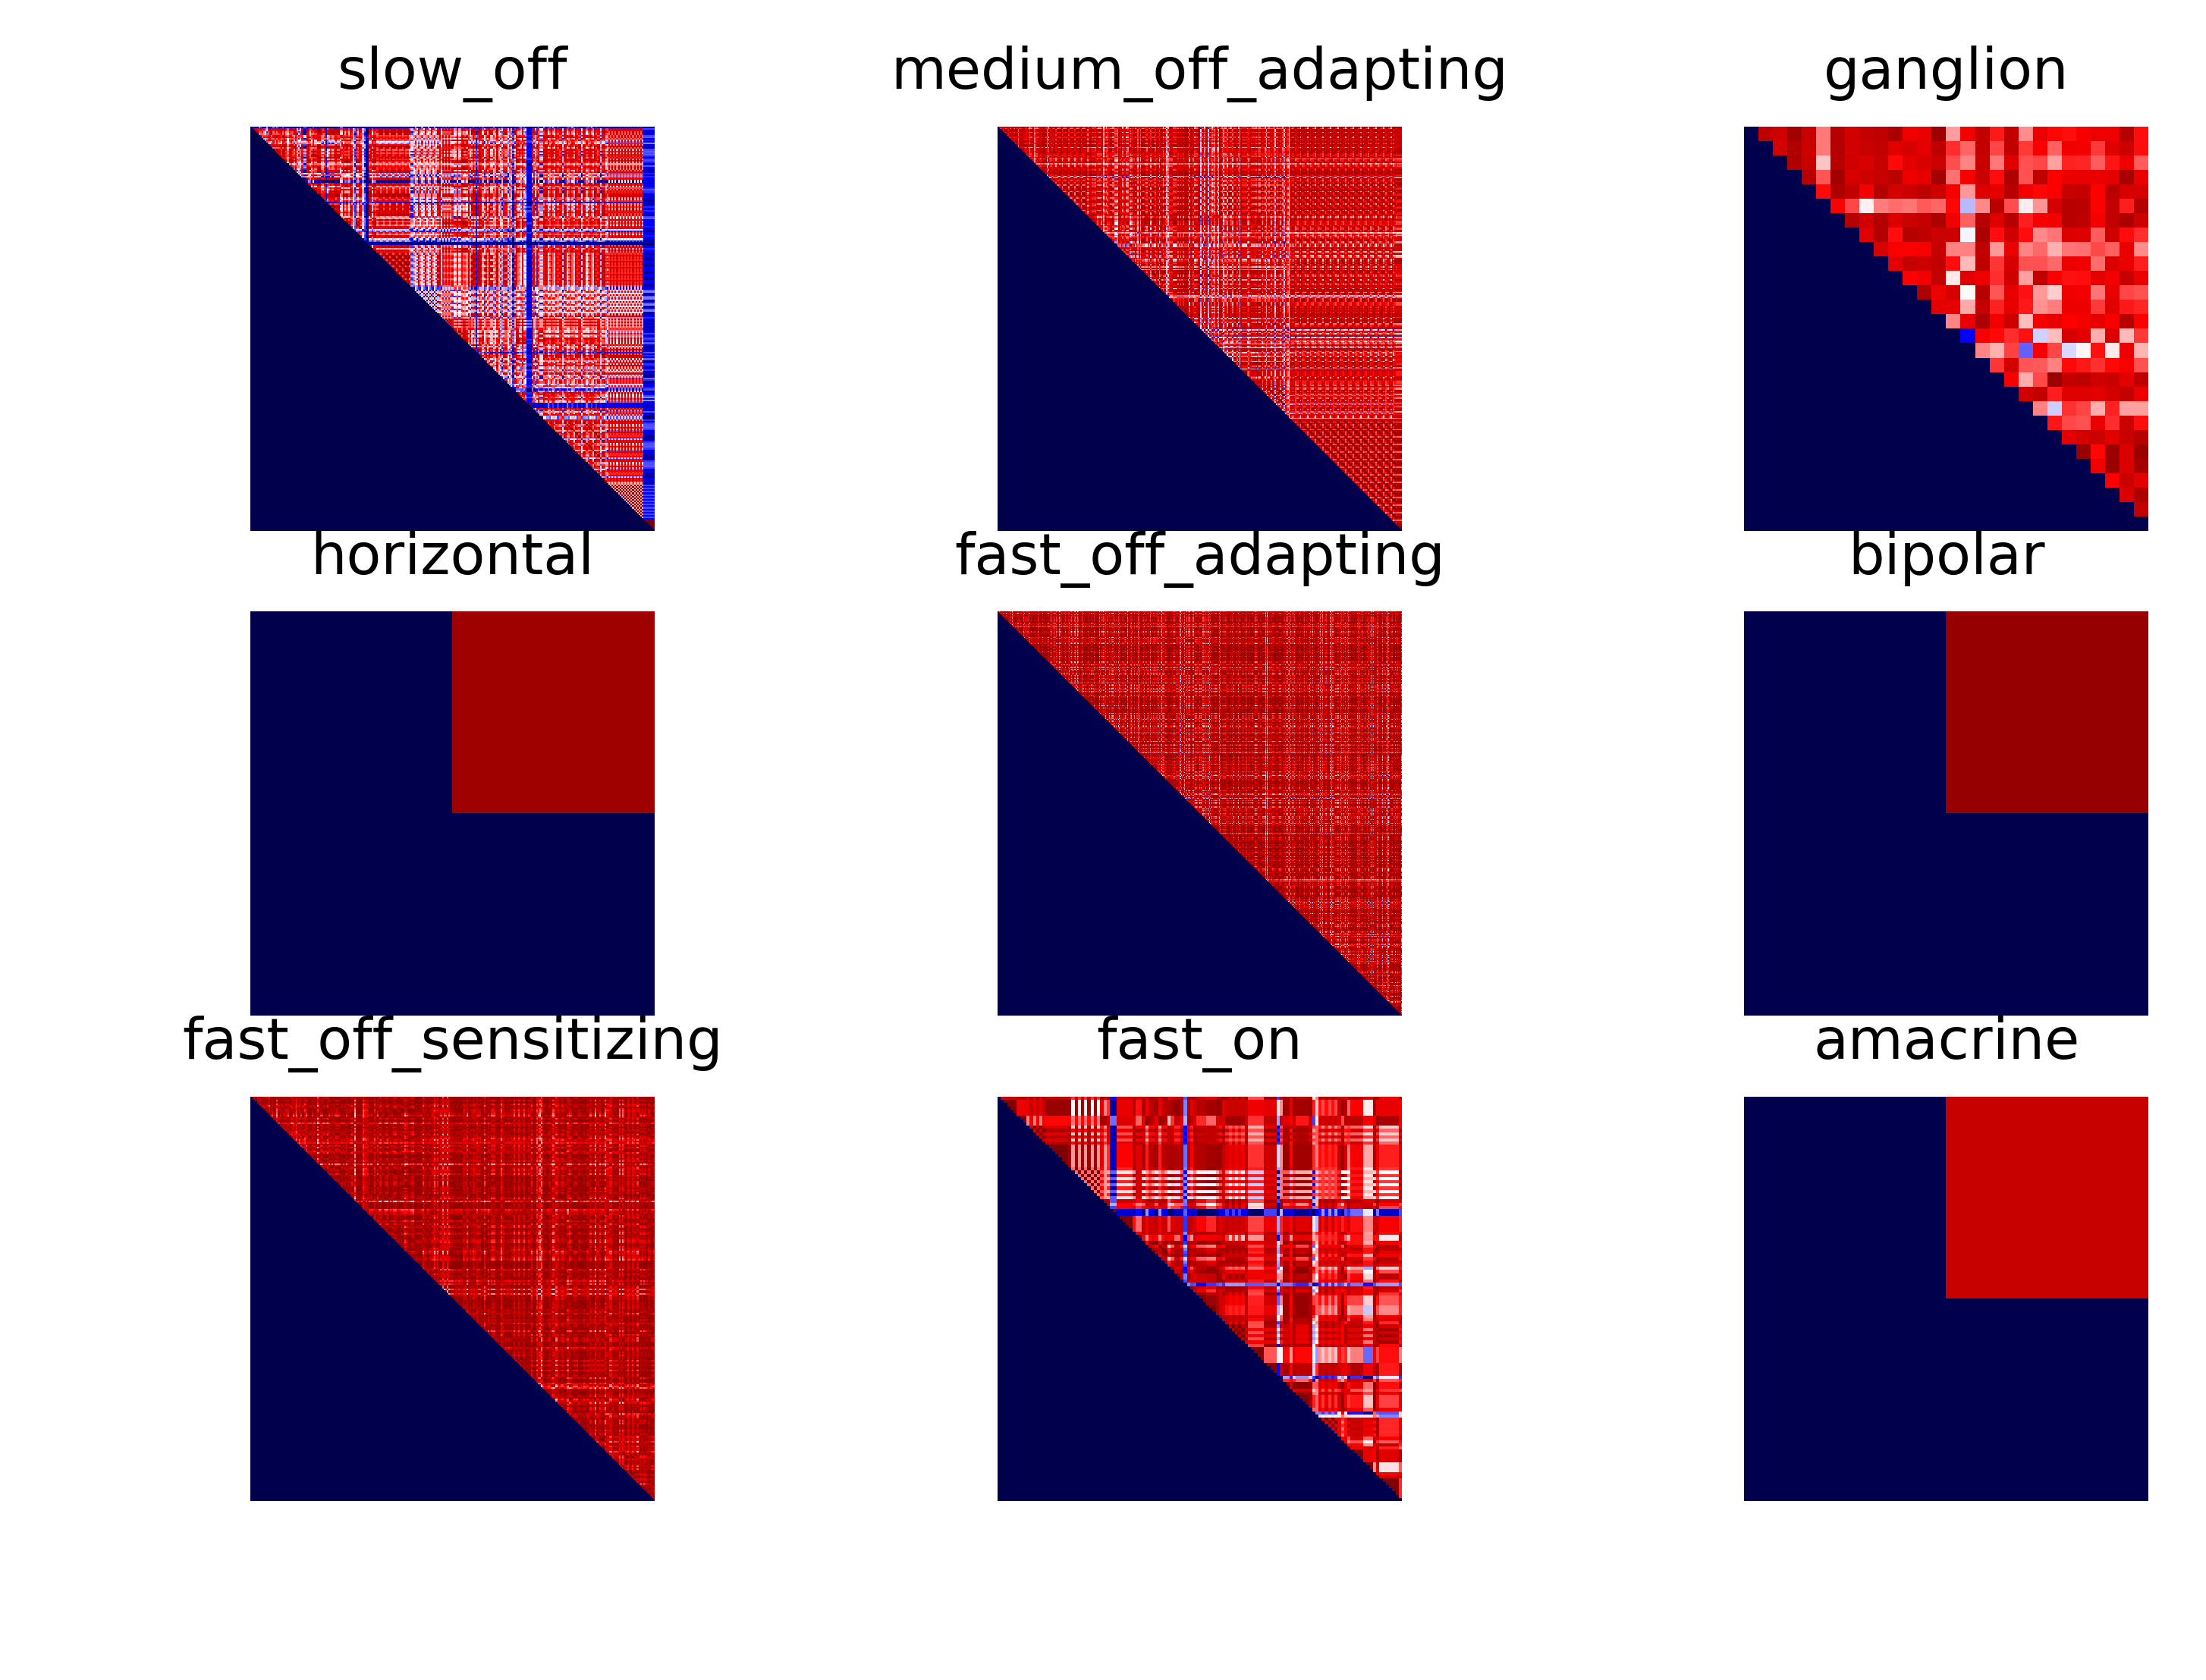

In [77]:
count = 1
for celltype in corr_map.keys():
    plt.subplot(3,3,count)
    plt.imshow(corr_map[celltype], clim=[0,1], cmap='seismic')
    plt.title('%s' %celltype, fontsize=9)
    plt.axis('off')
    count += 1

In [90]:
unduplicated_receptive_fields = collections.defaultdict(list)
duplicates = collections.defaultdict(list)

for celltype in corr_map.keys():
    these_dups = []
    for row in corr_map[celltype]:
        these_dups.append([i for i in range(len(row)) if row[i] == 1.0])
    duplicates[celltype] = np.unique(np.hstack(these_dups))

In [91]:
duplicates['slow_off']

array([  16.,   17.,   34.,   41.,   43.,   51.,   52.,   55.,   66.,
         67.,   68.,   69.,   70.,   71.,   83.,   84.,   85.,   86.,
         87.,   88.,   89.,   90.,   91.,   92.,   93.,   94.,   95.,
         96.,   97.,   98.,  101.,  106.,  107.,  108.,  109.,  110.,
        111.,  112.,  113.,  114.,  115.,  116.,  117.,  122.,  123.,
        124.,  125.,  130.,  131.,  132.,  151.,  160.,  174.,  175.,
        182.,  197.,  198.,  199.,  200.,  201.,  202.,  203.,  204.,
        205.,  206.,  207.,  208.,  209.,  210.,  211.,  212.,  213.,
        214.,  215.,  216.,  217.,  218.,  219.,  220.,  226.,  227.,
        228.,  229.,  230.,  231.,  232.,  233.,  234.,  235.,  236.,
        237.,  238.,  239.,  240.,  241.,  242.,  243.,  244.,  245.,
        247.,  248.,  249.,  250.,  251.,  252.])

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


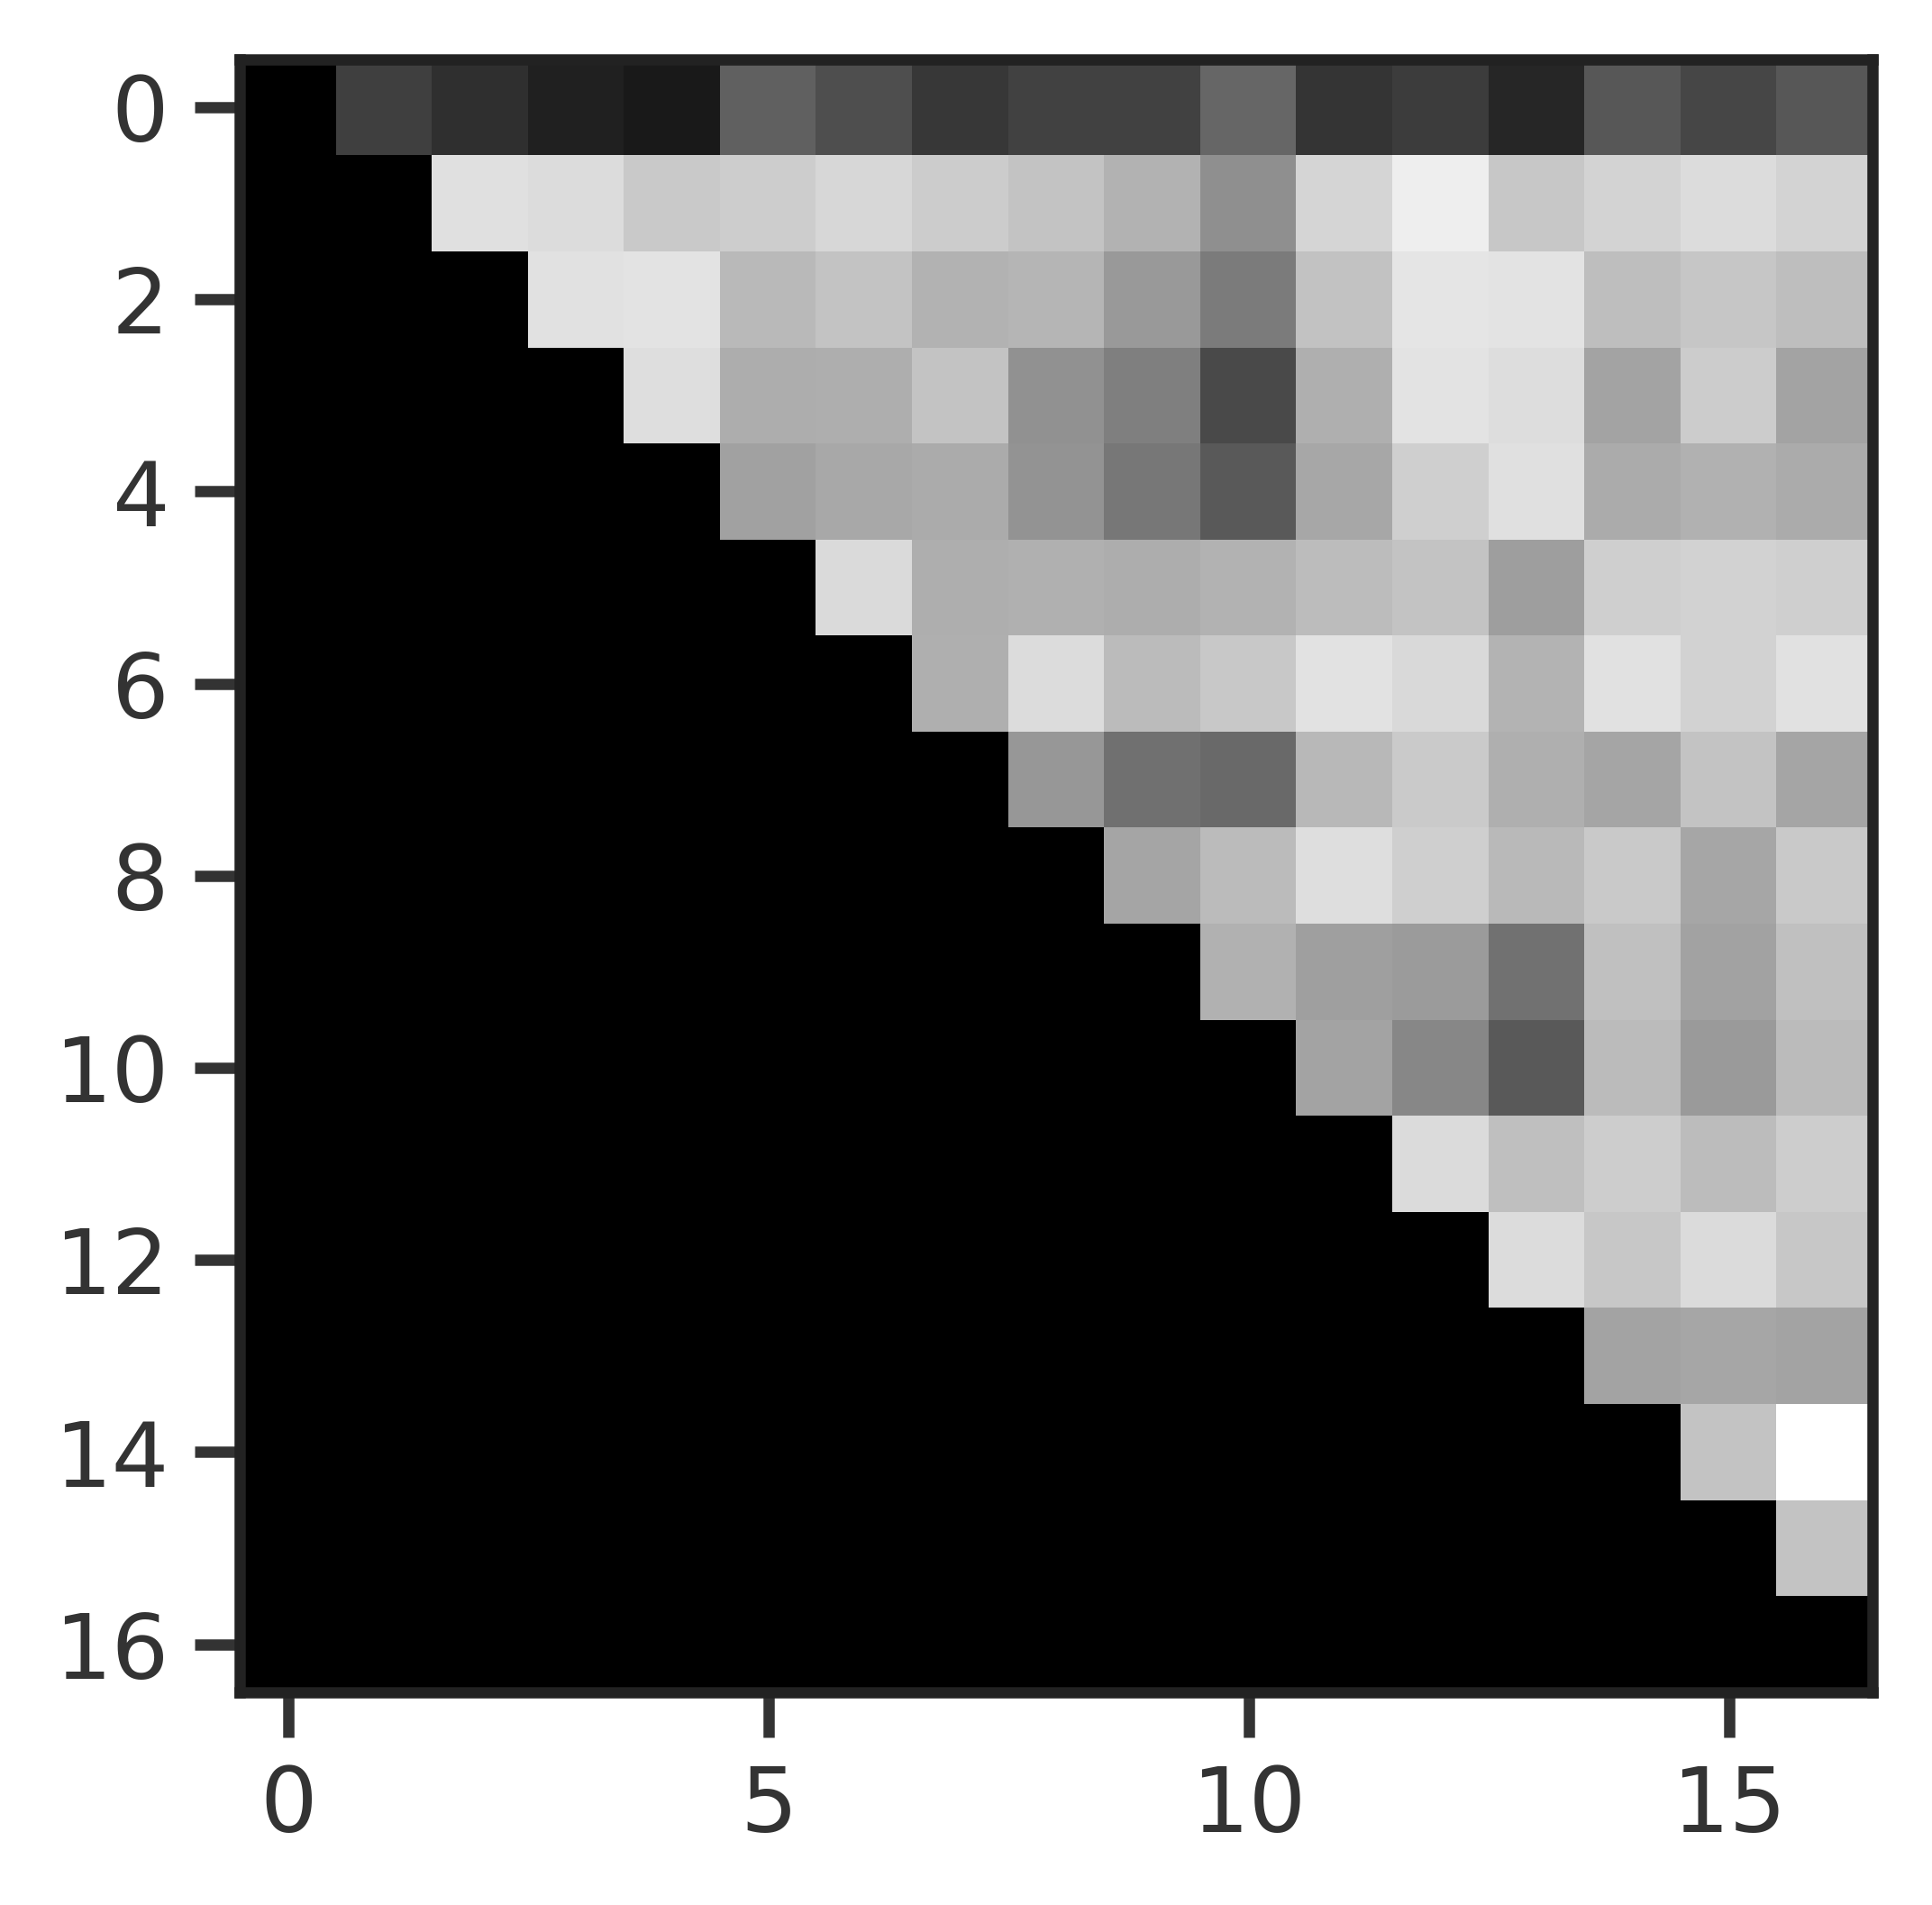

In [81]:
plt.imshow(corr_map['slow_off'][:17, :17])

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


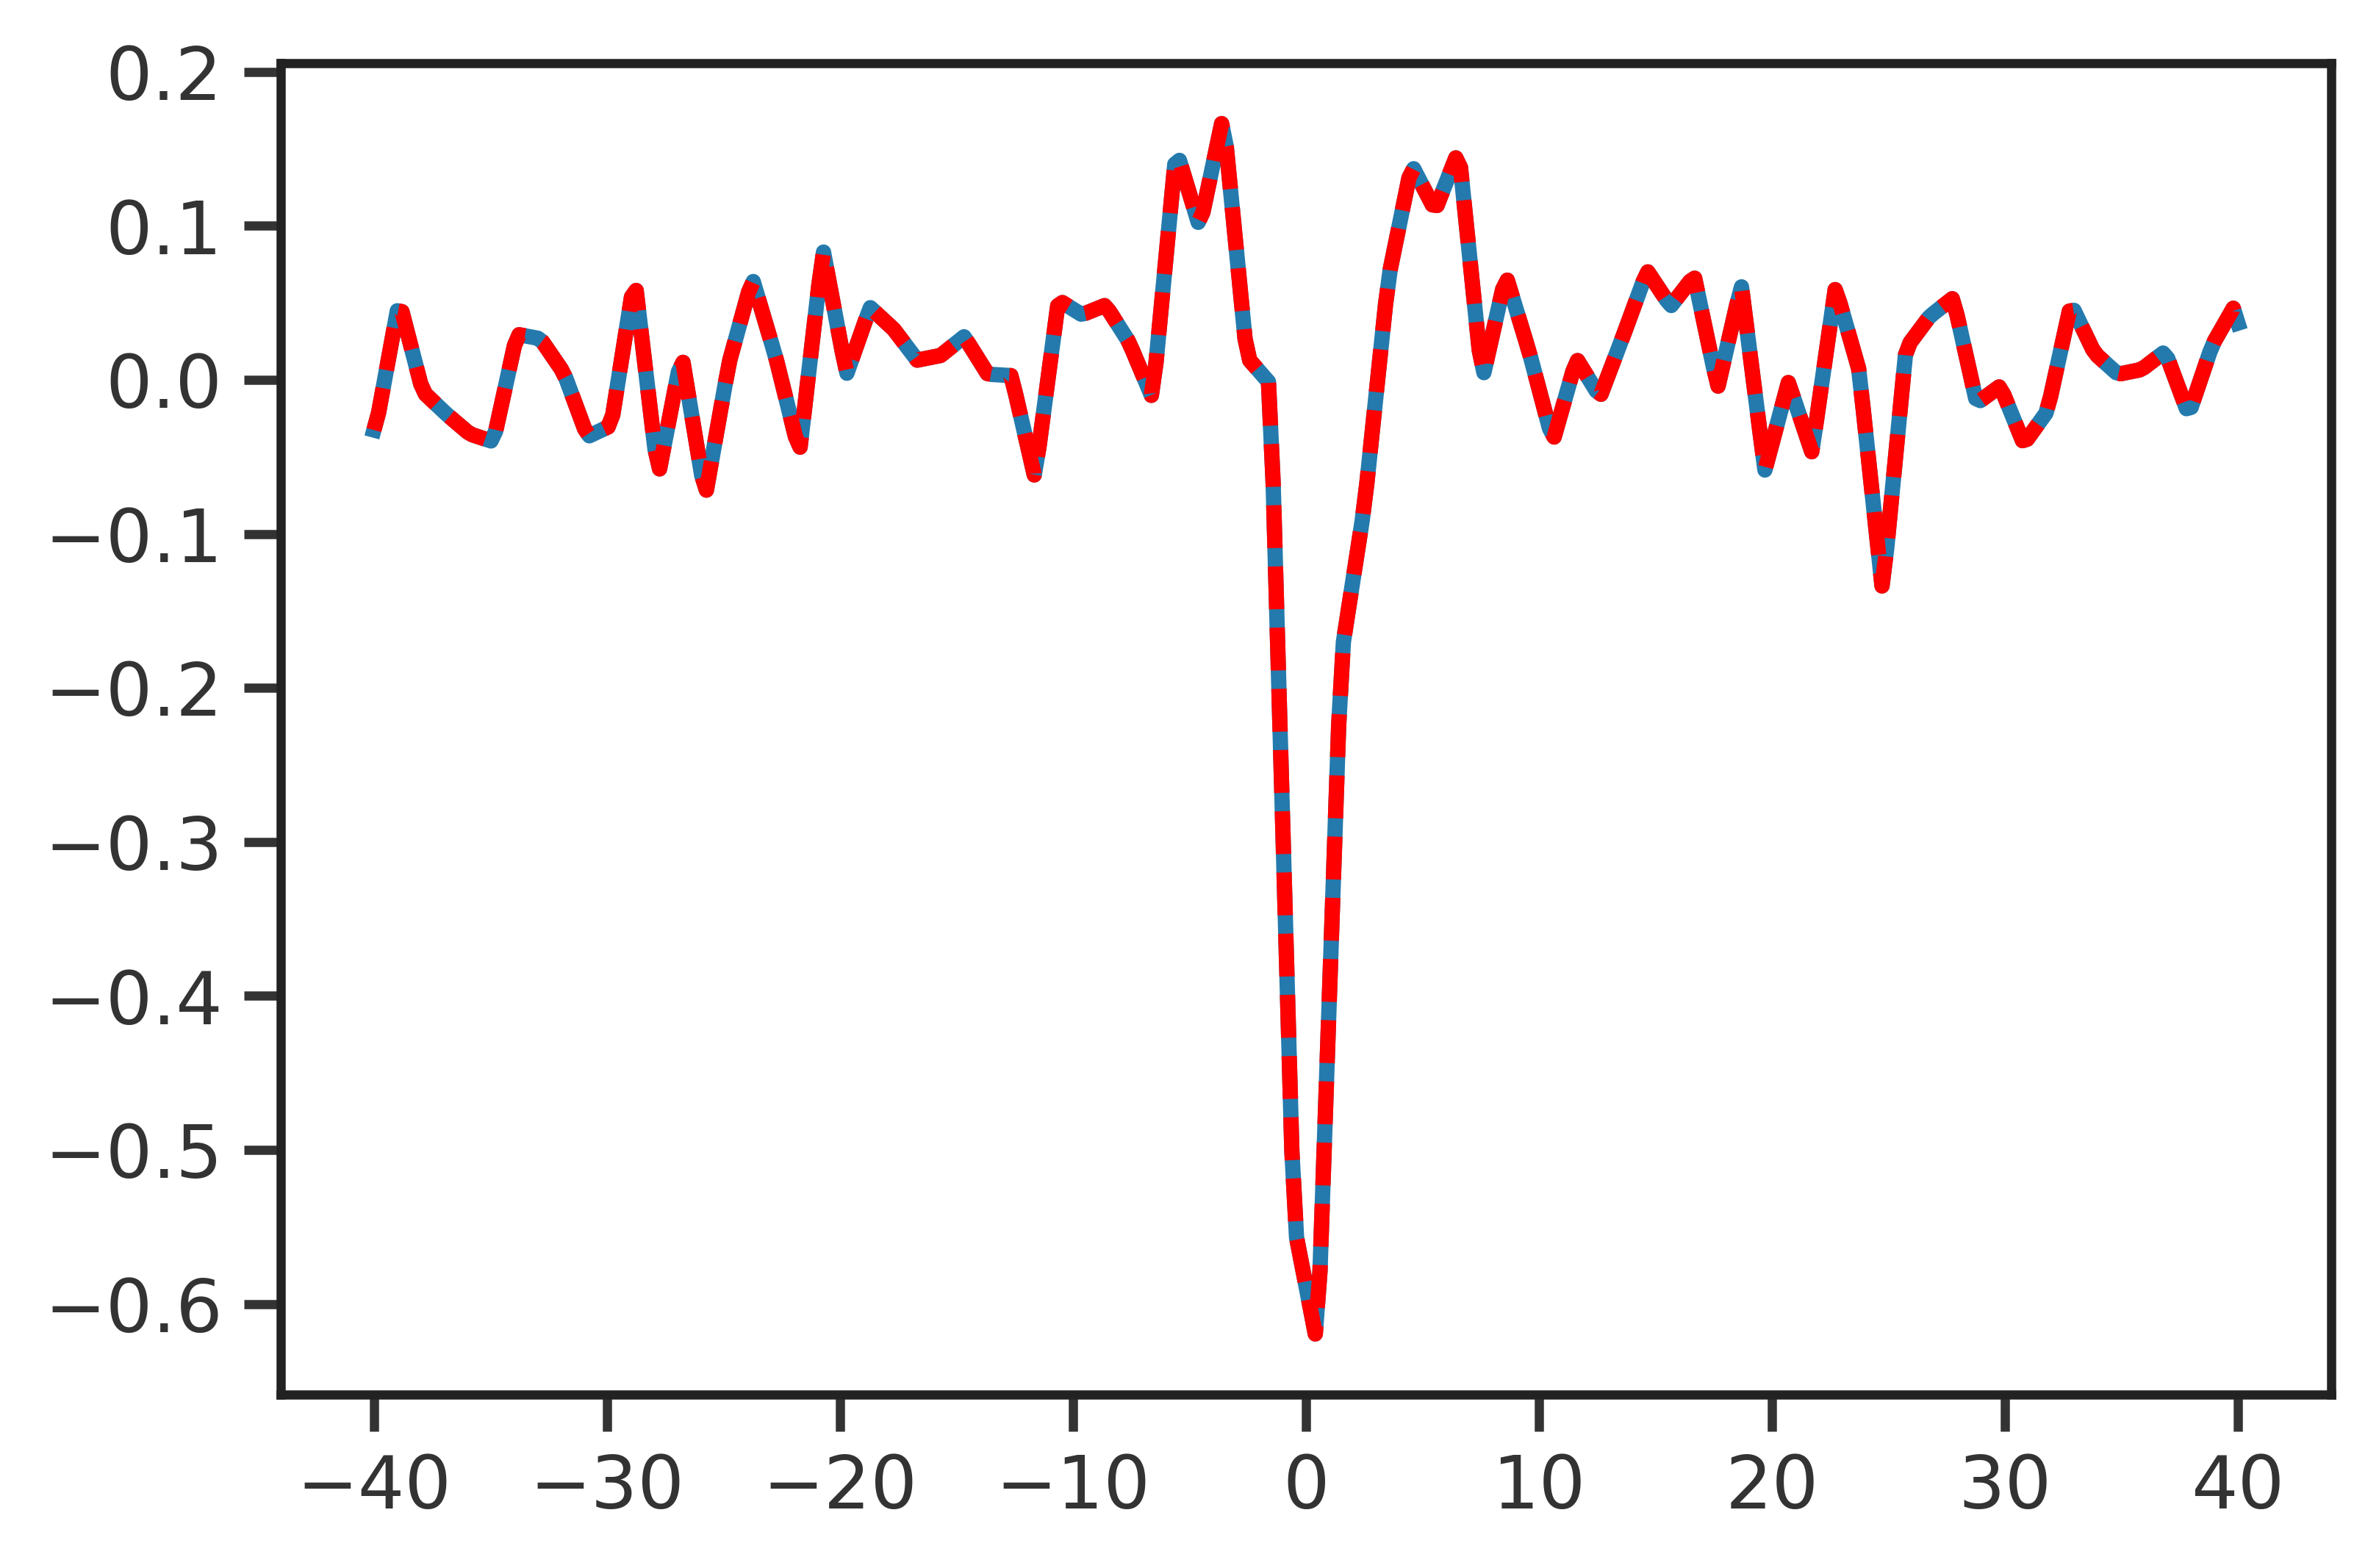

In [92]:
plt.plot(space, receptive_fields['slow_off'][16])
plt.plot(space, receptive_fields['slow_off'][14], 'r--')

### What percent of data were duplicates?

In [95]:
for celltype in corr_map.keys():
    print('%s had %d%% duplicated' %(celltype, (100.*len(duplicates[celltype]))/float(len(receptive_fields[celltype]))))

slow_off had 41% duplicated
medium_off_adapting had 50% duplicated
ganglion had 0% duplicated
horizontal had 0% duplicated
fast_off_adapting had 0% duplicated
bipolar had 0% duplicated
fast_off_sensitizing had 12% duplicated
fast_on had 53% duplicated
amacrine had 0% duplicated


In [97]:
unduplicated_receptive_fields = collections.defaultdict(list)

for celltype in corr_map.keys():
    for idr, rf in enumerate(receptive_fields[celltype]):
        if idr not in duplicates[celltype]:
            unduplicated_receptive_fields[celltype].append(rf)

In [98]:
np.sum([len(unduplicated_receptive_fields[k]) for k in unduplicated_receptive_fields.keys()])

1388

In [126]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in unduplicated_receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(unduplicated_receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)


0it [00:00, ?it/s]
1it [00:00,  5.75it/s]
3it [00:00,  6.57it/s]
4it [00:00,  7.08it/s]
6it [00:00,  7.72it/s]
7it [00:00,  7.61it/s]
8it [00:02,  1.94it/s]
9it [00:02,  2.54it/s]
10it [00:02,  3.24it/s]
11it [00:02,  4.00it/s]
12it [00:02,  4.43it/s]
13it [00:02,  4.58it/s]
15it [00:03,  5.35it/s]
16it [00:03,  3.52it/s]
18it [00:03,  4.26it/s]
19it [00:04,  5.05it/s]
21it [00:04,  6.06it/s]
22it [00:04,  5.86it/s]
24it [00:04,  6.79it/s]
25it [00:04,  7.22it/s]
27it [00:04,  8.00it/s]
28it [00:05,  7.23it/s]
29it [00:05,  7.81it/s]
30it [00:05,  8.33it/s]
31it [00:05,  8.62it/s]
32it [00:05,  7.89it/s]
33it [00:07,  1.47it/s]
36it [00:09,  1.50it/s]
148it [00:54,  2.08it/s]
159it [00:26,  8.66it/s]
217it [00:43,  5.26it/s]
772it [01:33,  8.29it/s]
28it [00:09,  1.15it/s]
58it [00:12,  5.34it/s]


## Now re-do receptive fitting after removing duplicates

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


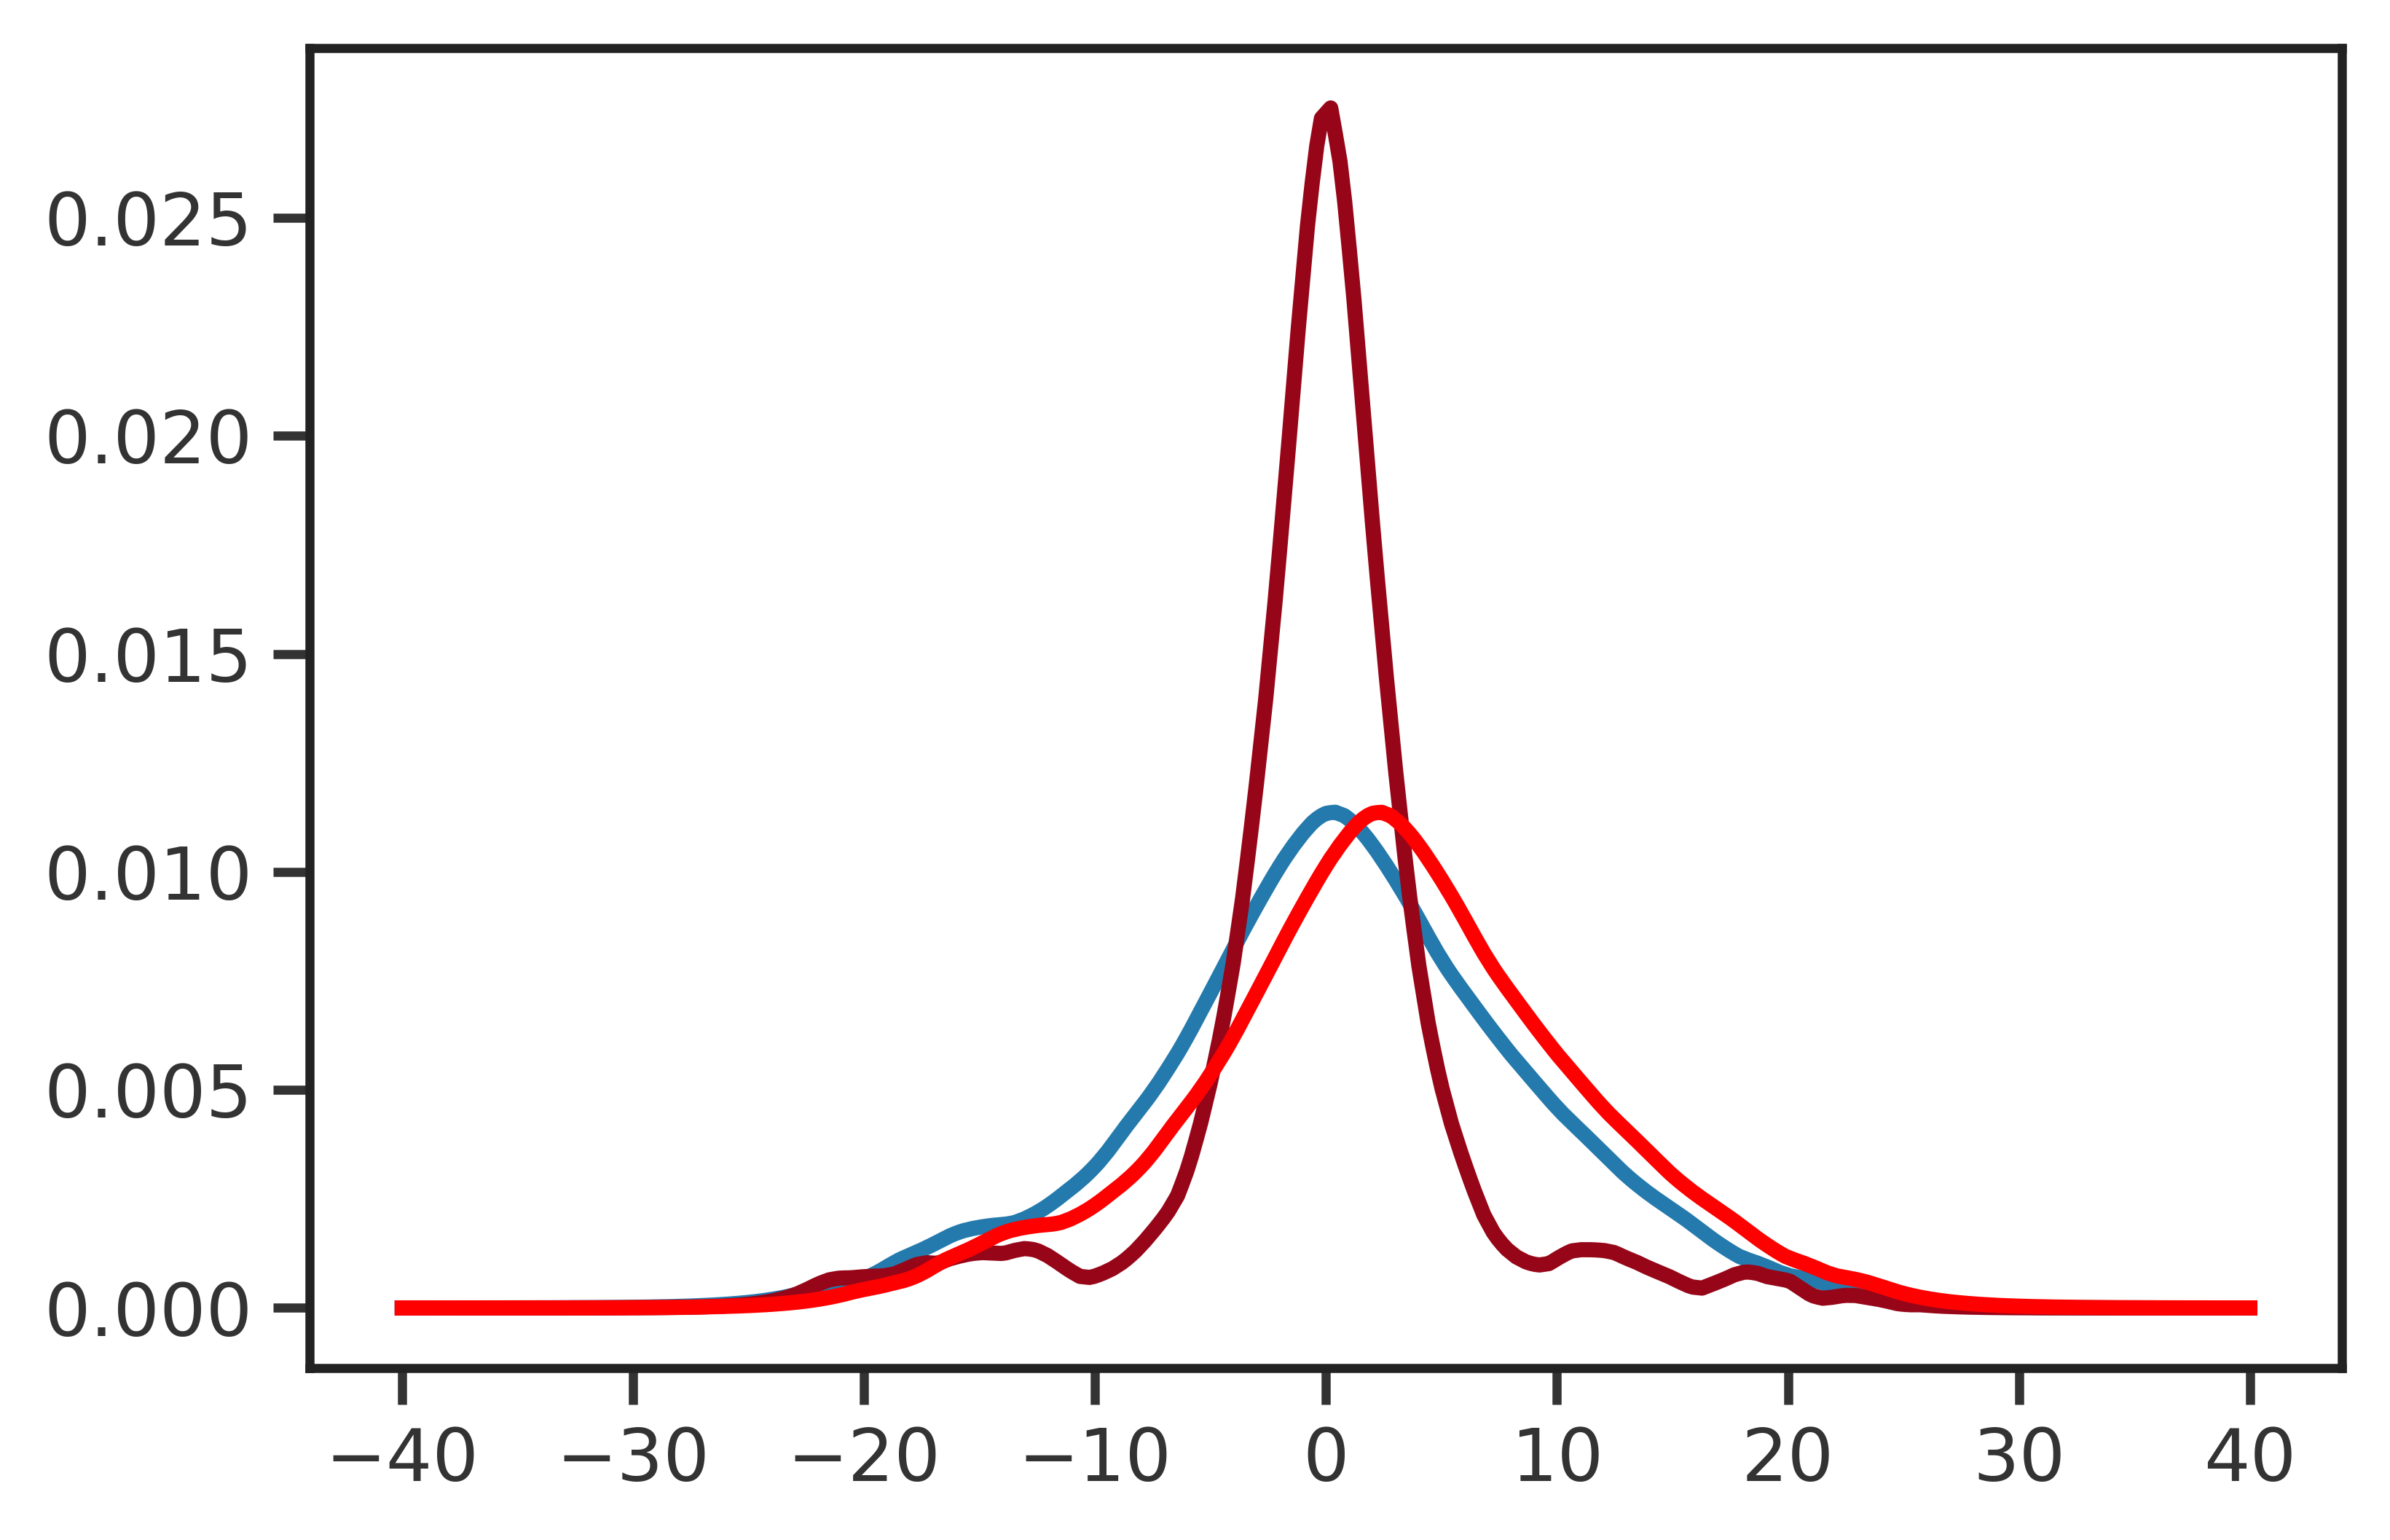

In [103]:
plt.plot(space, horz_pf)
plt.plot(space, ama_pf)

horz_pf_interp = interp1d(space, horz_pf, bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space, ama_pf, bounds_error=False, fill_value=[0])

horz_pos = 2
new_space = np.linspace(np.min(space)-horz_pos, np.max(space)-horz_pos, len(space))
plt.plot(space, horz_pf_interp(new_space), 'r')

In [105]:
np.sum(horz_pf_interp(space))

1.0

In [104]:
np.sum(horz_pf_interp(new_space))

0.99999708954374777

In [137]:
iterations = 25

fits = collections.defaultdict(list)
all_params = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)

horz_pf_interp = interp1d(space, horz_pf, bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space, ama_pf, bounds_error=False, fill_value=[0])

def rf_model(width, mean, ama_pos, horz_pos, horz_weight, center_weight):
    horz_weight = np.min([1.0, abs(horz_weight)])
    center_weight = np.min([1.0, abs(center_weight)])

    center = gaussian(x=space, sigma=abs(width), mu=mean)
    center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

    new_ama_space = np.linspace(np.min(space)-ama_pos, np.max(space)-ama_pos, len(space))
    new_horz_space = np.linspace(np.min(space)-horz_pos, np.max(space)-horz_pos, len(space))
    ama = ama_pf_interp(new_ama_space)/np.sum(ama_pf_interp(new_ama_space))
    horz = horz_pf_interp(new_horz_space)/np.sum(horz_pf_interp(new_horz_space))

    return center_weight*center + (1-center_weight)*(horz_weight*horz + (1-horz_weight)*ama)

for celltype in unduplicated_receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        params = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(unduplicated_receptive_fields[celltype])):
            
            def model_error_to_ganglion_cells(weights):
                width, mean, ama_pos, horz_pos, hw, cw = weights
                modeled_rf = rf_model(width, mean, ama_pos, horz_pos, hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                return sum(abs(normed_rf - rf)**2)

            best_fit_err = np.inf
            for itr in range(iterations):
                # center width
                # center position
                # ama position
                # horz position
                # horz/ama weight
                # center/surr weight
                this_popt = minimize(model_error_to_ganglion_cells, np.hstack([center_widths[celltype][i]+0.5*np.random.randn(1),
                                                                               0.1*np.random.randn(3),
                                                                               np.random.rand(2)]))
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            modeled_rf = rf_model(*popt.x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
            # push fits between 0 and 1
            x = np.where(abs(popt.x[-2:]) > 1, 1, abs(popt.x[-2:]))

            popts.append(x)
            params.append(popt.x)
            abs_errors[celltype].append(popt.fun)
            mean_squared_errors[celltype].append(mse)
            variances[celltype].append(np.var(rf))

        fits[celltype] = np.stack(popts)
        all_params[celltype] = np.stack(params)


0it [00:00, ?it/s]
2it [00:33, 21.61s/it]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encounter

KeyboardInterrupt: 

Reconstruct model

In [129]:
# #width, mean, ama_pos, horz_pos, hw, cw = all_params['medium_off_adapting'][0]
# cell_id = 0
# rf = unduplicated_receptive_fields['medium_off_adapting'][cell_id]
# modeled_rf = rf_model(*all_params['medium_off_adapting'][cell_id])
# normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
# plt.plot(space, rf, 'k')
# plt.plot(space, normed_rf, 'r')

In [138]:
params

[array([  4.20507215e-01,   1.20319356e-01,   2.77149267e+00,
         -1.29604407e-01,  -1.96470804e-09,   5.25459527e-01]),
 array([ 1.72233889,  0.1948318 , -0.23917077, -1.12239432,  1.7473567 ,
         0.56597303]),
 array([  2.59730642,  -0.70197339,  -2.21115225,  13.1600264 ,
         -0.06028937,   0.51990578]),
 array([ 2.63056498,  0.46460713,  0.5297078 , -2.0891323 ,  0.2866603 ,
         0.56396236]),
 array([ 3.2962048 ,  0.53314866, -3.34815146,  1.81174914, -0.5783821 ,
        -0.52948499]),
 array([  0.67551715,   0.09431   ,   0.03893122,  10.25118988,
          3.90034935,   0.71666803]),
 array([ 0.7897909 ,  0.38039651,  0.18605242,  5.71326422,  3.8269818 ,
         0.6984637 ]),
 array([  1.68468833,   0.15260347,   2.29202328,   3.41730078,
         11.09569749,   0.86772391]),
 array([ 0.89072386,  0.76562976, -1.80977463,  4.61965237,  0.69338372,
         0.5140187 ])]

In [139]:
center_widths[celltype][1]

1.8029288202999045

In [149]:
cw

0.69846369838438294

# These fits are really crappy... by hand I can get an order of magnitude lower error

165.24514965


/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


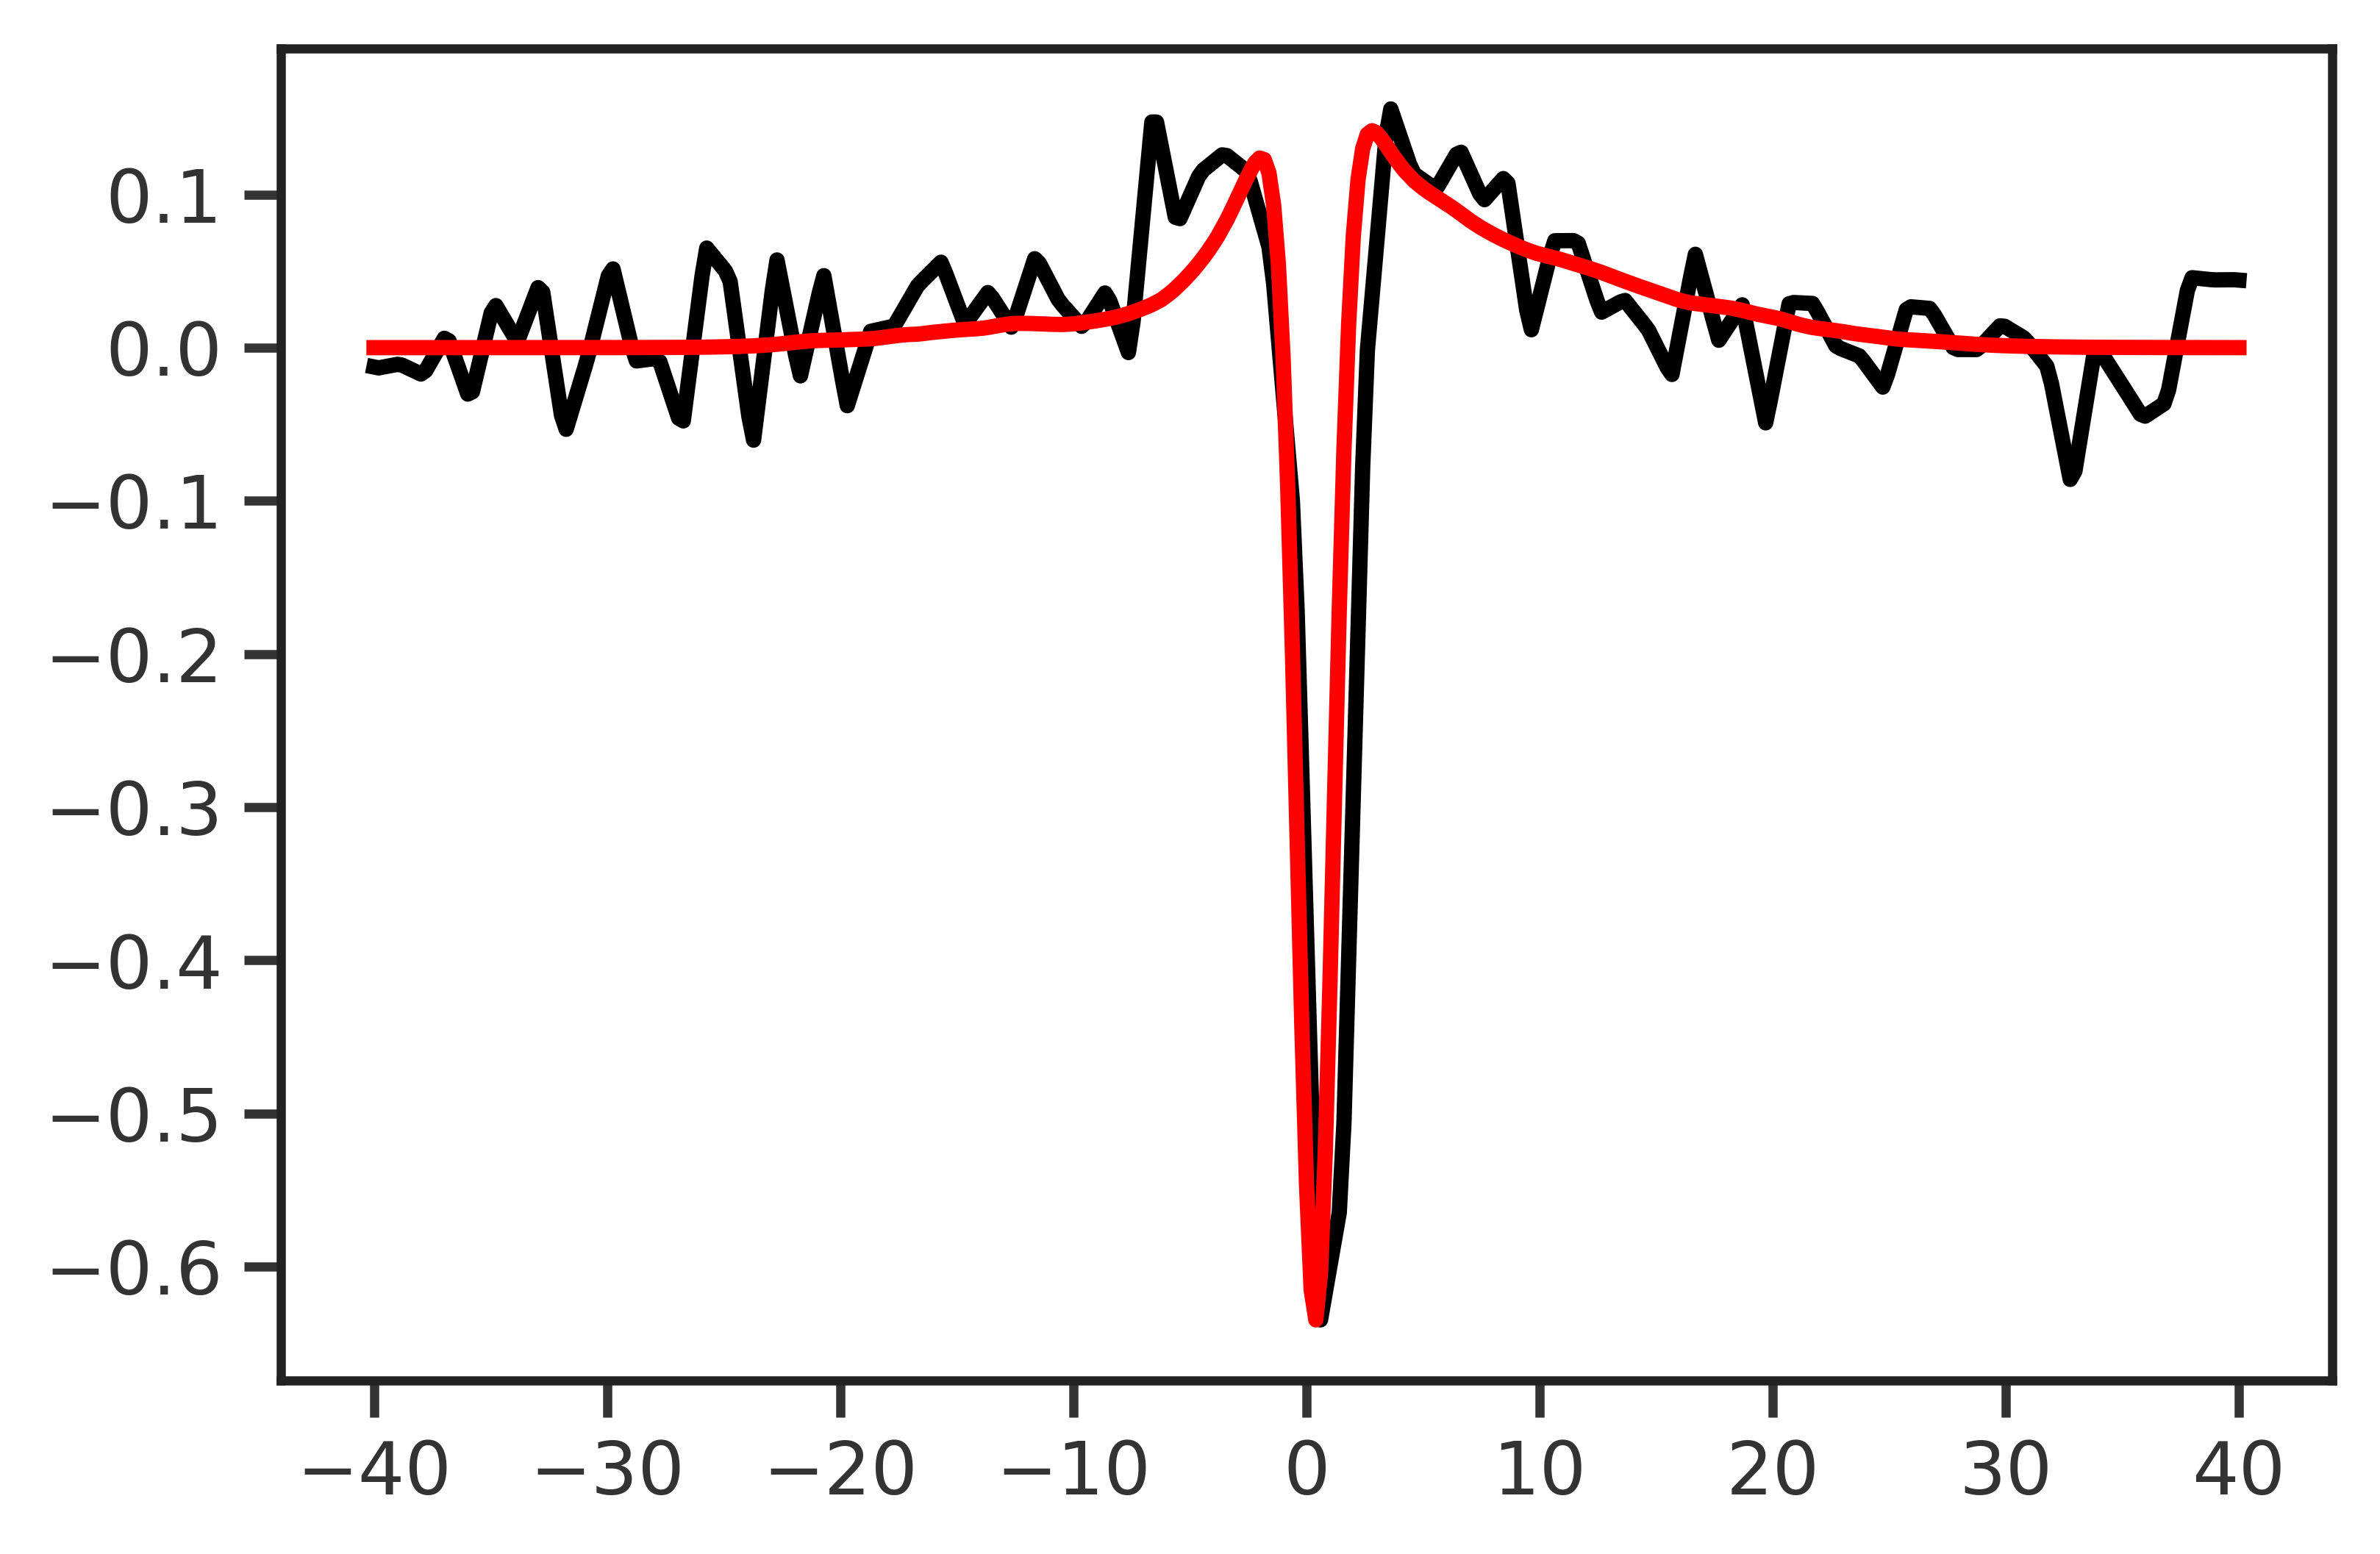

In [154]:
cell_id = 6
rf = unduplicated_receptive_fields['medium_off_adapting'][cell_id]
# width, mean, ama_pos, horz_pos, hw, cw = all_params['medium_off_adapting'][cell_id]
width, mean, ama_pos, horz_pos, hw, cw = params[cell_id]
# modeled_rf = rf_model(*params[cell_id])
# modeled_rf = rf_model(2.72419965,  0.17496017, -0.20530527, -0.81051504,  1.25692458, 0.56142647)
modeled_rf = rf_model(width, mean, ama_pos, horz_pos, 0.5, 0.4)
normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
print(np.sum(abs(normed_rf - rf))**2)
plt.plot(space, rf, 'k')
plt.plot(space, normed_rf, 'r')

In [158]:
iterations = 25

fits = collections.defaultdict(list)
all_params = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)

horz_pf_interp = interp1d(space, horz_pf, bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space, ama_pf, bounds_error=False, fill_value=[0])

def rf_model(width, mean, ama_pos, horz_pos, horz_weight, center_weight):
    horz_weight = np.min([1.0, abs(horz_weight)])
    center_weight = np.min([1.0, abs(center_weight)])

    center = gaussian(x=space, sigma=abs(width), mu=mean)
    center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

    new_ama_space = np.linspace(np.min(space)-ama_pos, np.max(space)-ama_pos, len(space))
    new_horz_space = np.linspace(np.min(space)-horz_pos, np.max(space)-horz_pos, len(space))
    ama = ama_pf_interp(new_ama_space)/np.sum(ama_pf_interp(new_ama_space))
    horz = horz_pf_interp(new_horz_space)/np.sum(horz_pf_interp(new_horz_space))

    return center_weight*center + (1-center_weight)*(horz_weight*horz + (1-horz_weight)*ama)

for celltype in unduplicated_receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        params = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(unduplicated_receptive_fields[celltype])):
            
            def model_error_to_ganglion_cells(weights):
                width, mean, ama_pos, horz_pos, hw, cw = weights
                modeled_rf = rf_model(width, mean, ama_pos, horz_pos, hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                return sum(abs(normed_rf - rf)**2)

            best_fit_err = np.inf
            for itr in range(iterations):
                # center width
                # center position
                # ama position
                # horz position
                # horz/ama weight
                # center/surr weight
                this_popt = minimize(model_error_to_ganglion_cells, np.hstack([center_widths[celltype][i]+0.5*np.random.randn(1),
                                                                               0.1*np.random.randn(3),
                                                                               np.random.rand(2)]),
                                    method='L-BFGS-B')
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            modeled_rf = rf_model(*popt.x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
            # push fits between 0 and 1
            x = np.where(abs(popt.x[-2:]) > 1, 1, abs(popt.x[-2:]))

            popts.append(x)
            params.append(popt.x)
            abs_errors[celltype].append(popt.fun)
            mean_squared_errors[celltype].append(mse)
            variances[celltype].append(np.var(rf))

        fits[celltype] = np.stack(popts)
        all_params[celltype] = np.stack(params)


0it [00:00, ?it/s]
2it [00:16,  9.43s/it]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide
8it [01:09,  8.28s/it]

KeyboardInterrupt: 

254.124404072


/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


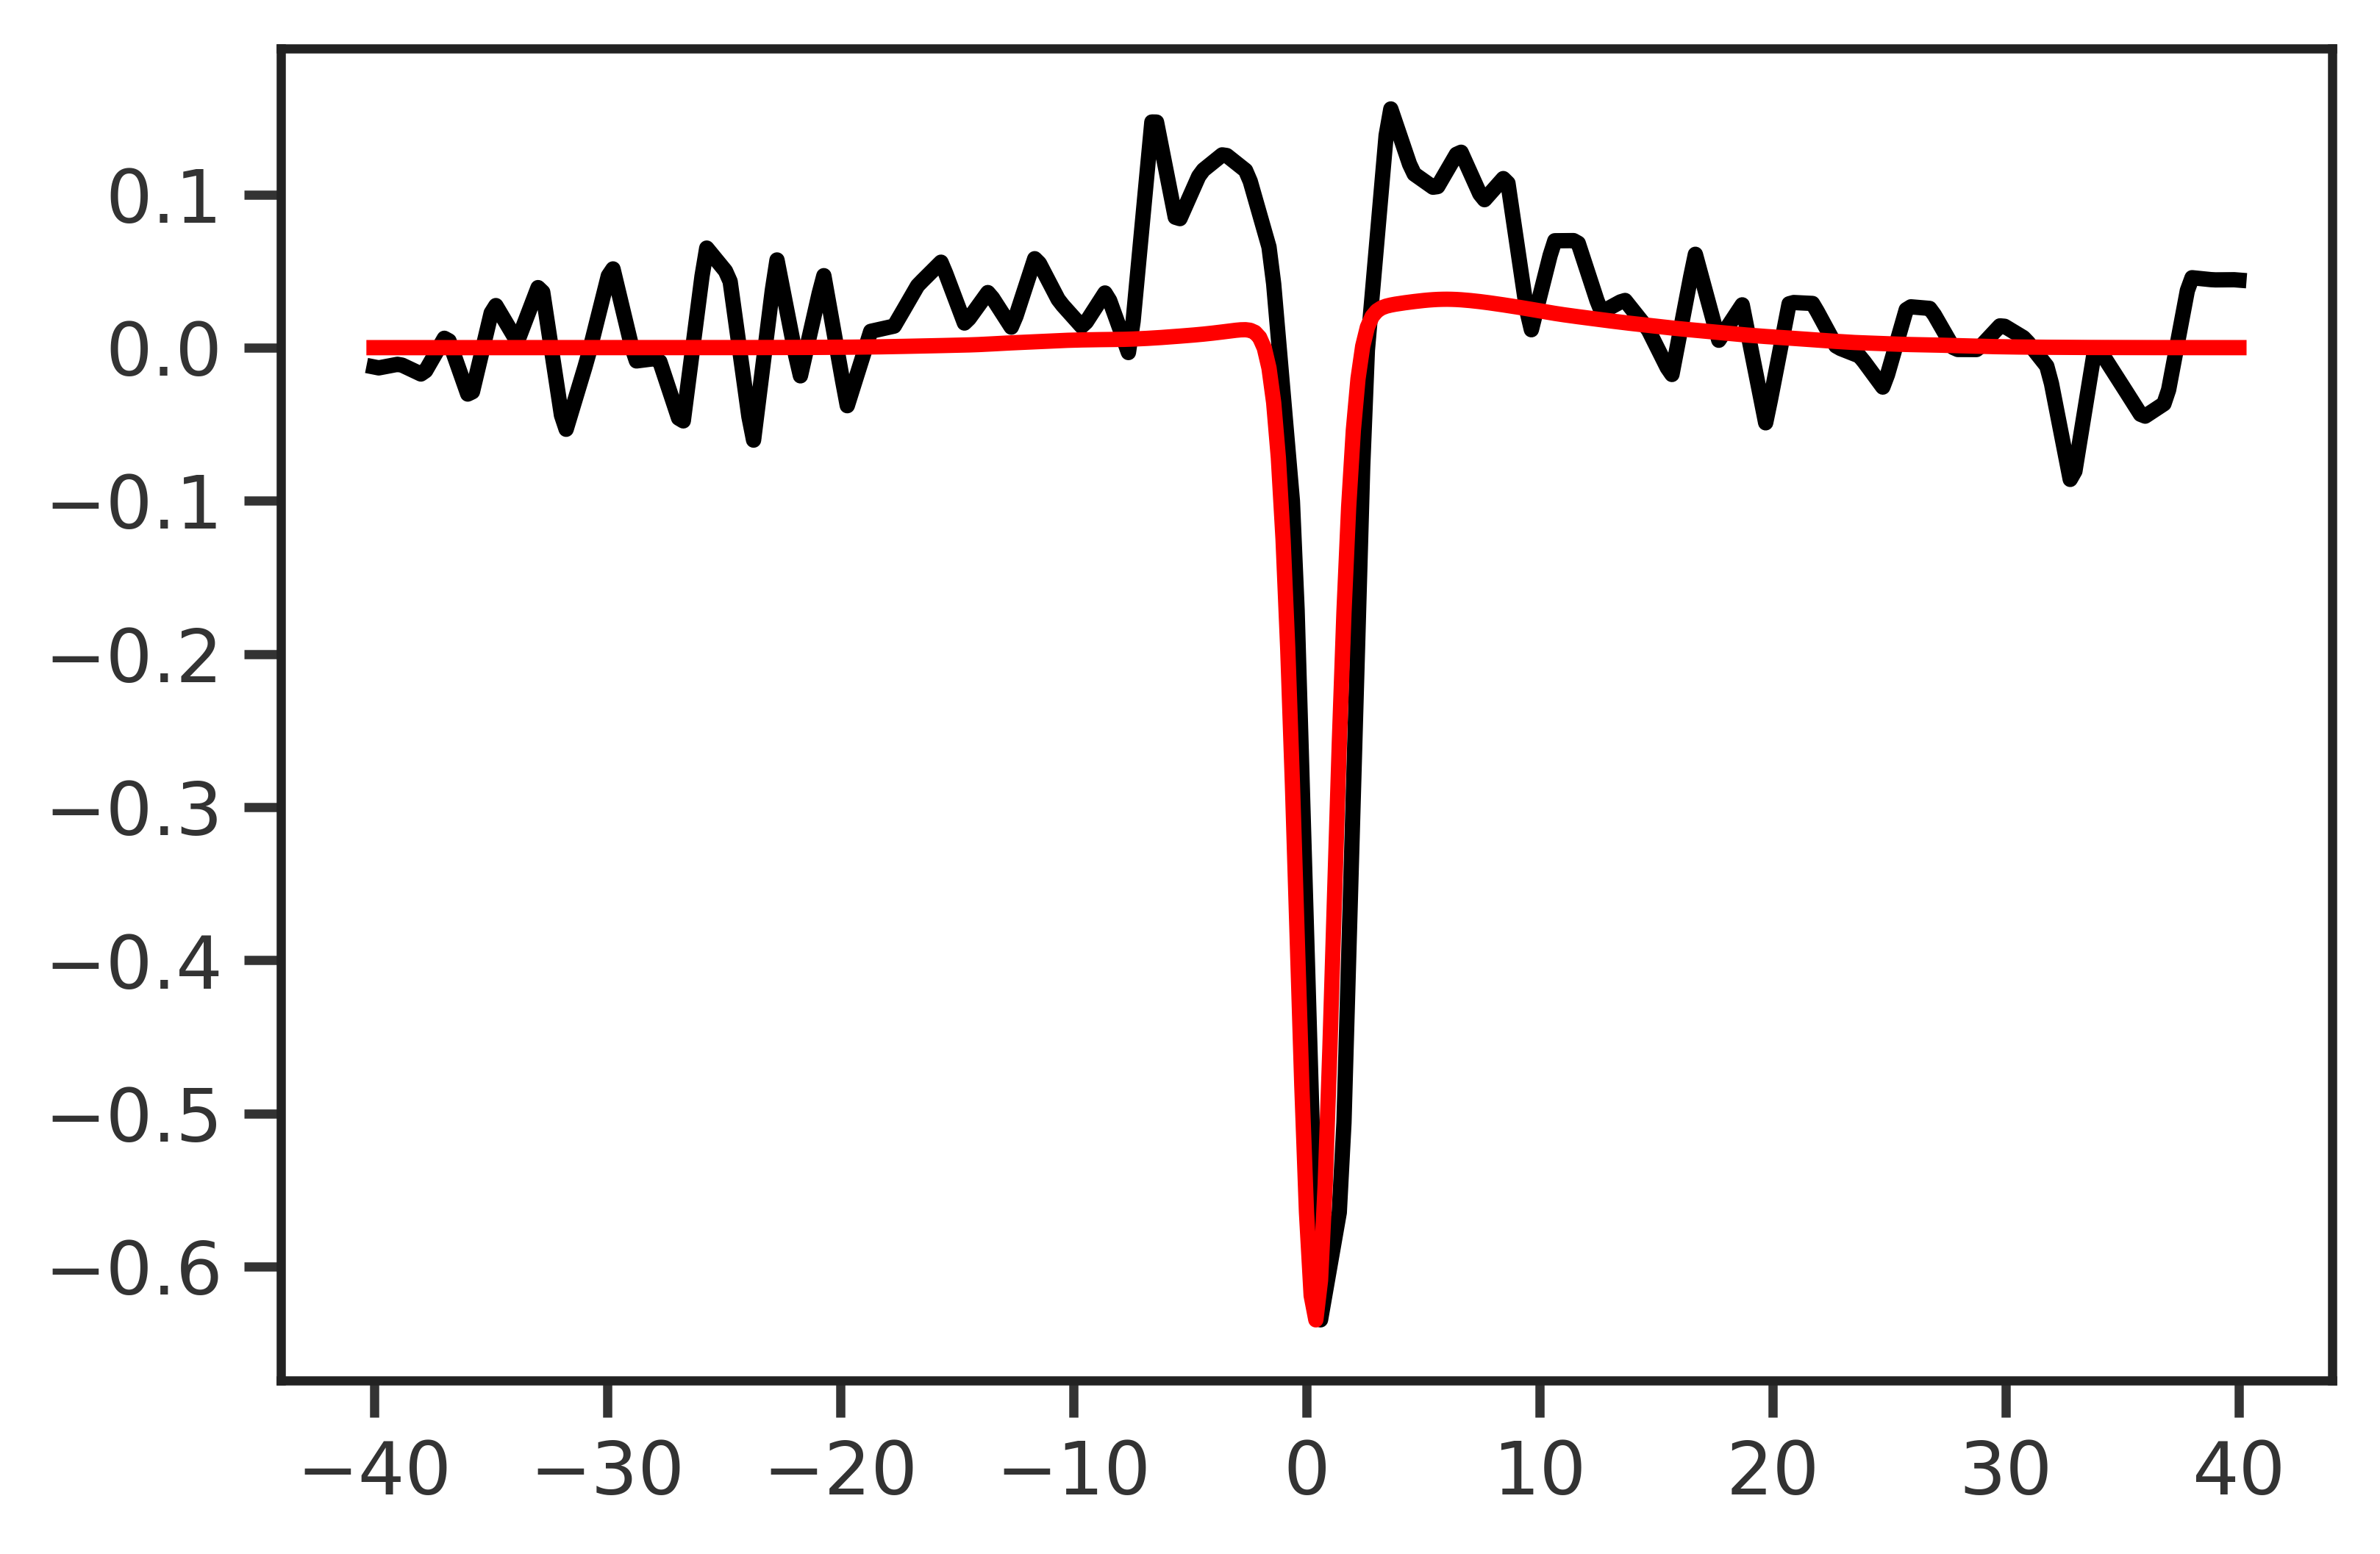

In [160]:
cell_id = 6
rf = unduplicated_receptive_fields['medium_off_adapting'][cell_id]
# width, mean, ama_pos, horz_pos, hw, cw = all_params['medium_off_adapting'][cell_id]
# width, mean, ama_pos, horz_pos, hw, cw = params[cell_id]
modeled_rf = rf_model(*params[cell_id])
# modeled_rf = rf_model(2.72419965,  0.17496017, -0.20530527, -0.81051504,  1.25692458, 0.56142647)
# modeled_rf = rf_model(width, mean, ama_pos, horz_pos, 0.5, 0.4)
normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
print(np.sum(abs(normed_rf - rf))**2)
plt.plot(space, rf, 'k')
plt.plot(space, normed_rf, 'r')

In [161]:
params[cell_id]

array([ 0.78979089,  0.38039668,  0.50590871,  5.71327562,  3.66759308,
        0.69846362])

In [163]:
this_popt.fun

0.57865138805846794

In [164]:
this_popt.x

array([ 0.89784651,  0.79120097,  0.52461053,  0.60301637,  3.08681281,
        0.51028357])

In [165]:
i

8

In [166]:
model_error_to_ganglion_cells(this_popt.x)

0.46009401020862578

In [167]:
best_fit_err

0.57865138594339982

In [170]:
celltype

'slow_off'

In [180]:
params

[array([  4.20508888e-01,   1.20322732e-01,   2.77148792e+00,
         -3.10807474e-02,  -5.23292970e-09,   5.25449419e-01]),
 array([ 1.72233886,  0.19483199, -0.30653816, -1.12239095,  3.00879992,
         0.56597303]),
 array([  2.59717223,  -0.70142069,  -2.21105528,  13.14253991,
         -0.06037426,  -0.51992045]),
 array([ 2.6305638 ,  0.4646078 ,  0.52970708, -2.08914466,  0.2866577 ,
         0.56396223]),
 array([ 2.81047998,  1.10755694, -0.04827616, -0.90109986,  1.50409088,
         0.53708315]),
 array([  0.67264778,   0.12180895,   5.41531864,  10.24976138,
         73.05996079,   0.71538213]),
 array([ 0.78979089,  0.38039668,  0.50590871,  5.71327562,  3.66759308,
         0.69846362]),
 array([  1.81123392e+00,   3.10692751e-01,   2.61310879e+00,
          8.33740113e-01,  -1.33584480e-09,  -7.87404437e-01])]

82.8316258559


/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


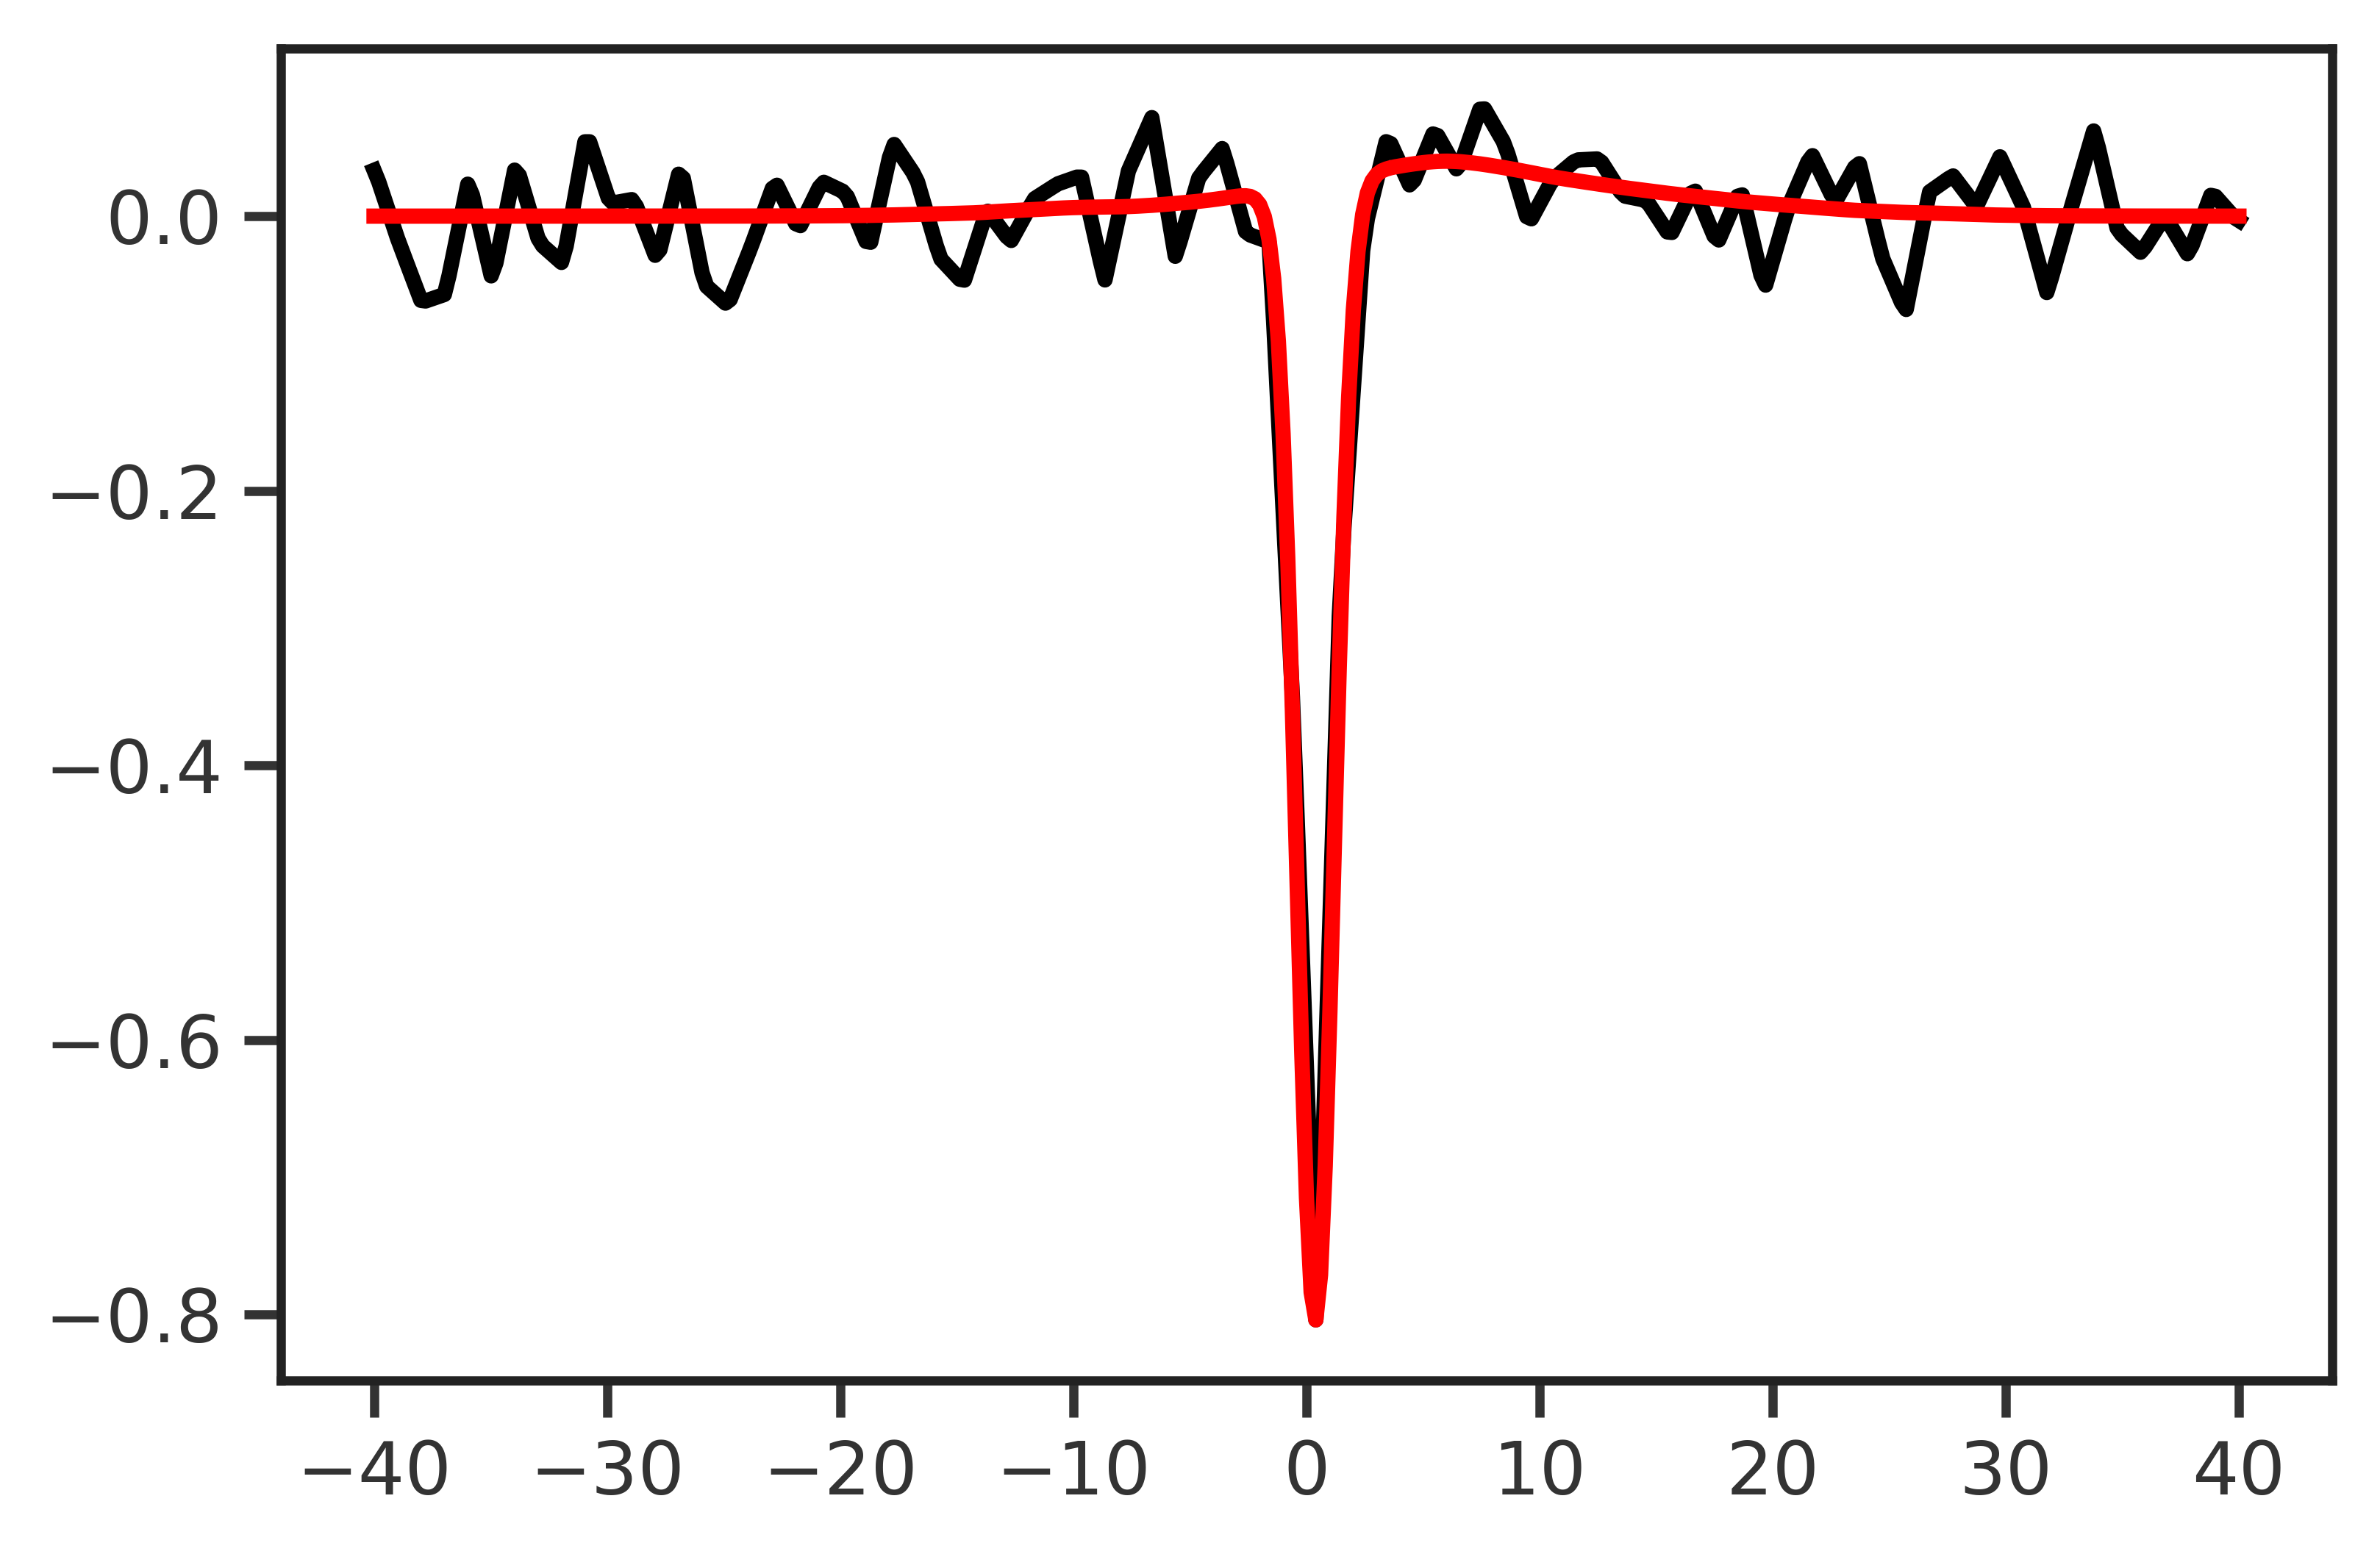

In [179]:
cell_id = 6
rf = unduplicated_receptive_fields[celltype][cell_id]
# width, mean, ama_pos, horz_pos, hw, cw = all_params['medium_off_adapting'][cell_id]
# width, mean, ama_pos, horz_pos, hw, cw = params[cell_id]
# modeled_rf = rf_model(*this_popt.x)
modeled_rf = rf_model(*params[cell_id])
# modeled_rf = rf_model(2.72419965,  0.17496017, -0.20530527, -0.81051504,  1.25692458, 0.56142647)
# modeled_rf = rf_model(width, mean, ama_pos, horz_pos, 0.5, 0.4)
normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
print(np.sum(abs(normed_rf - rf))**2)
plt.plot(space, rf, 'k')
plt.plot(space, normed_rf, 'r')

0.578651388058


/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


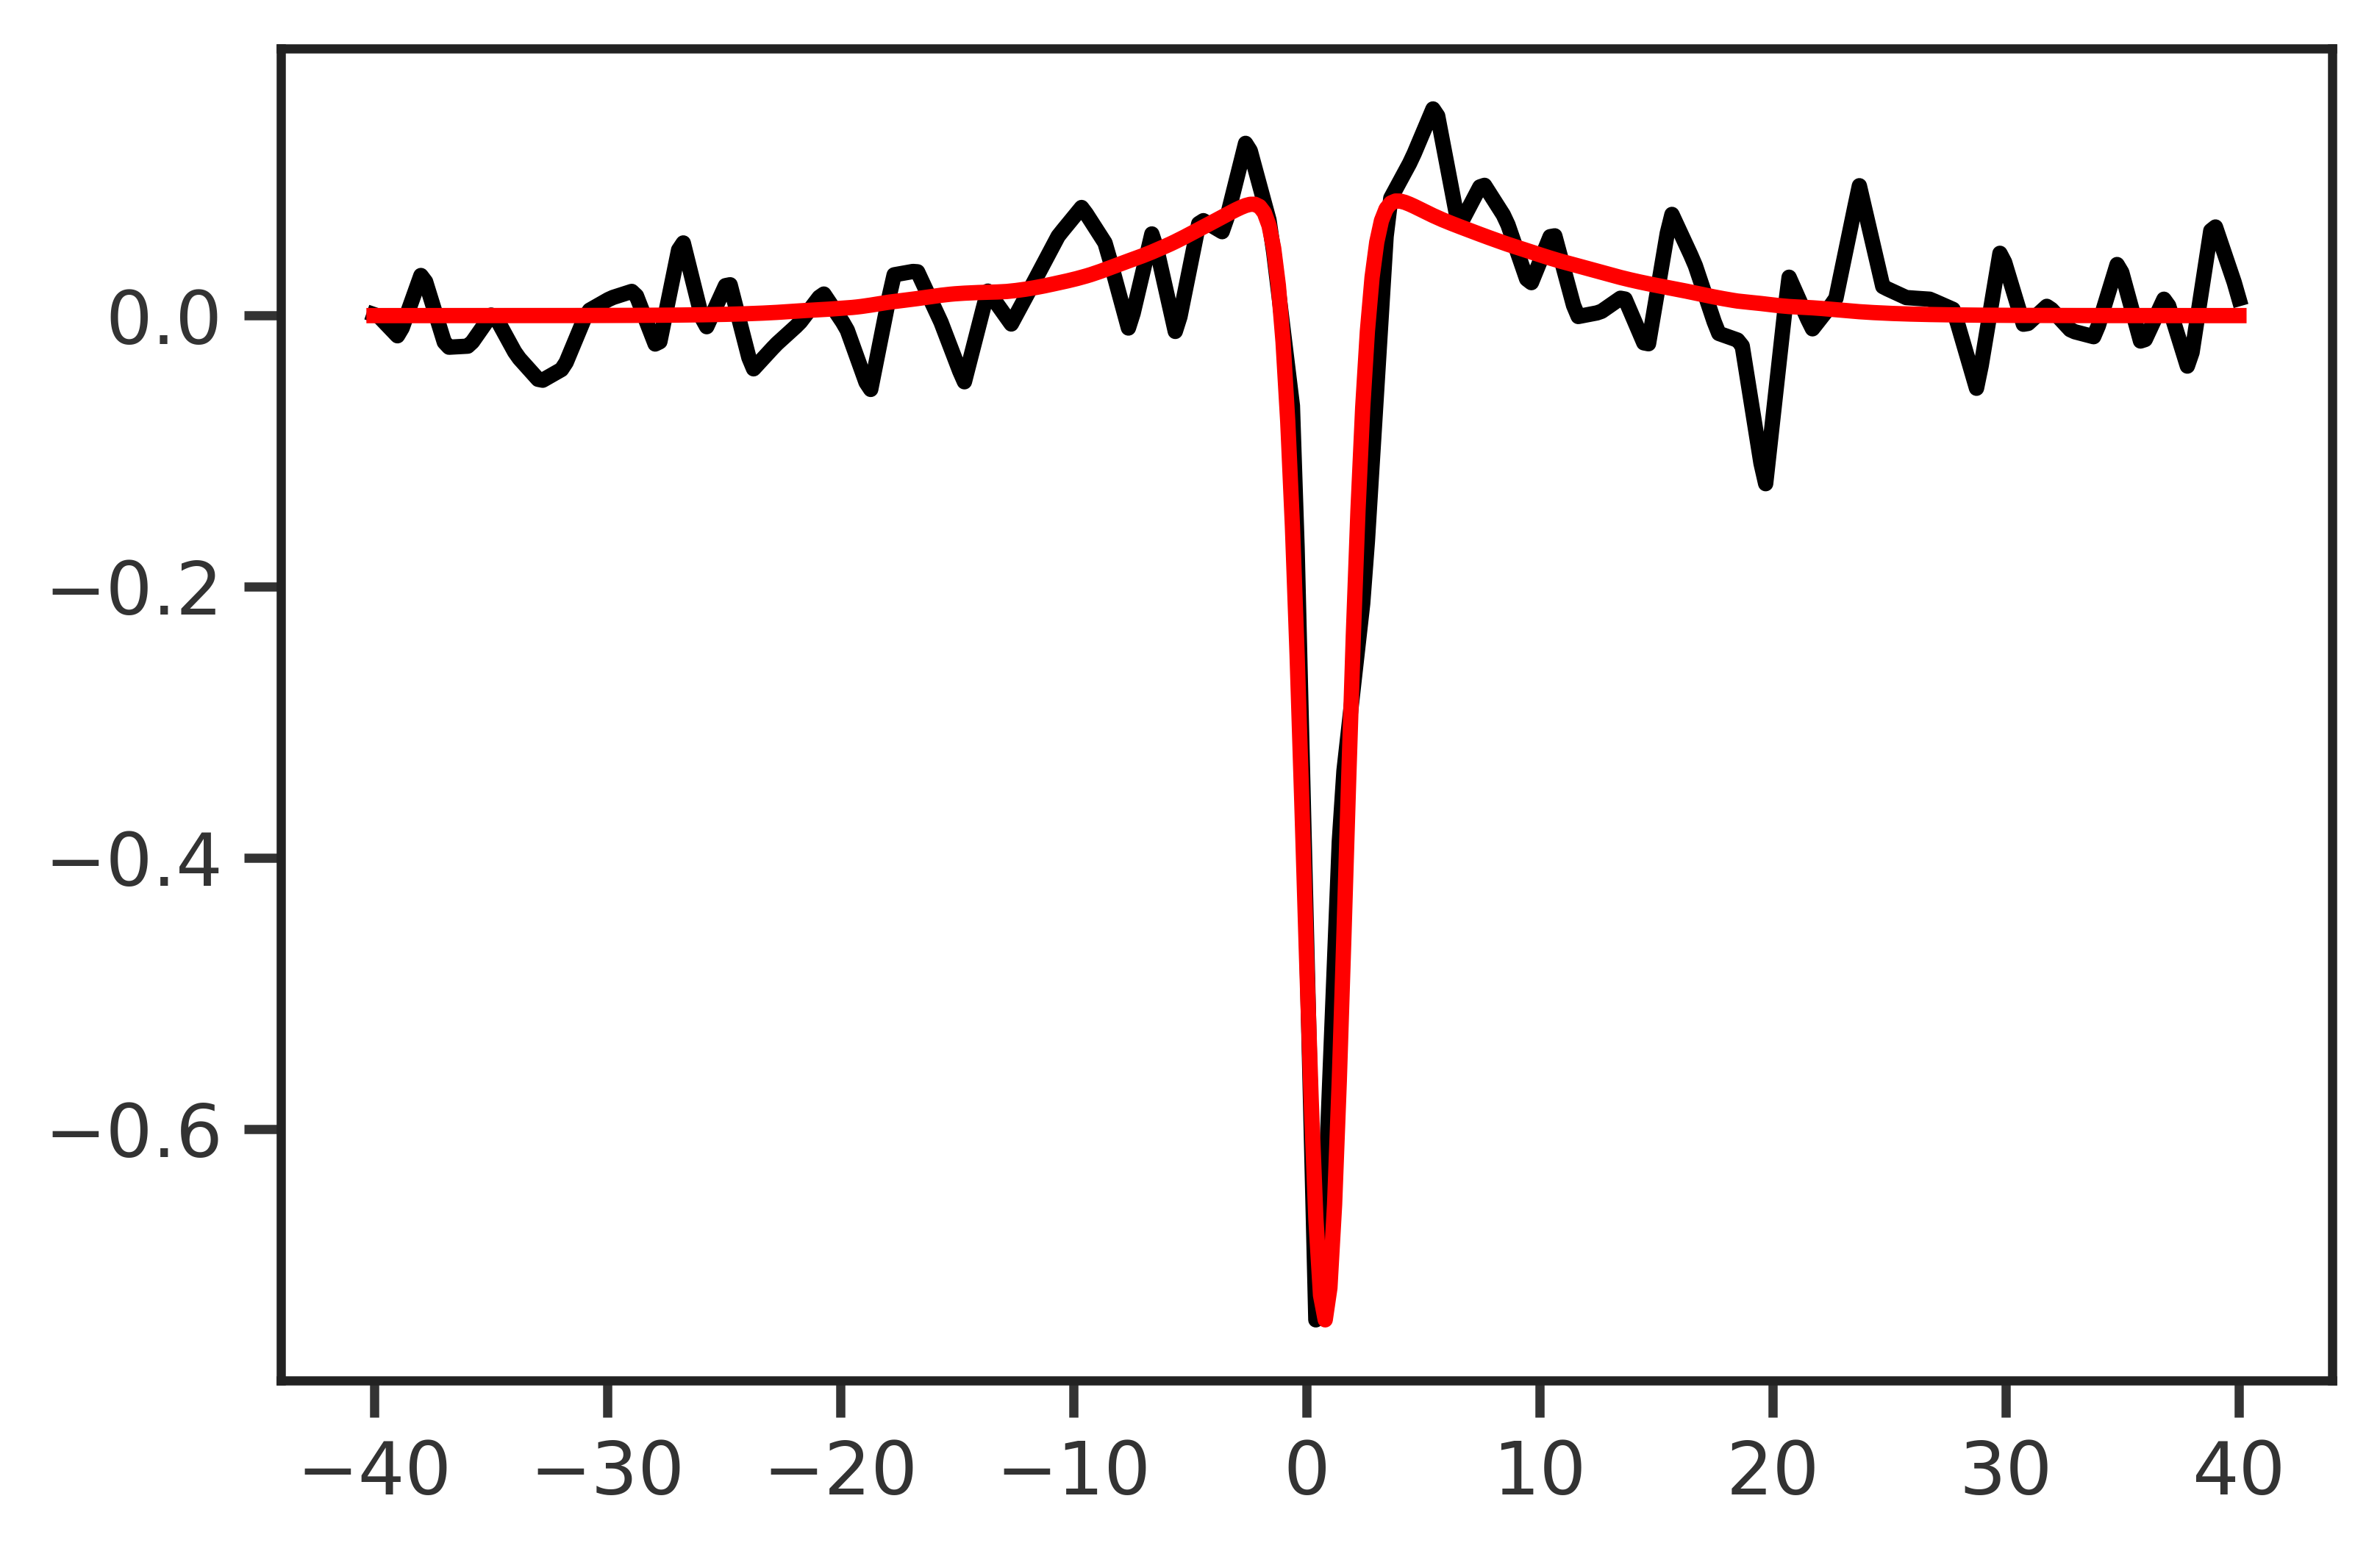

In [183]:
cell_id = i
rf = unduplicated_receptive_fields[celltype][cell_id]
# width, mean, ama_pos, horz_pos, hw, cw = all_params['medium_off_adapting'][cell_id]
# width, mean, ama_pos, horz_pos, hw, cw = params[cell_id]
modeled_rf = rf_model(*this_popt.x)
# modeled_rf = rf_model(*params[cell_id])
# modeled_rf = rf_model(2.72419965,  0.17496017, -0.20530527, -0.81051504,  1.25692458, 0.56142647)
# modeled_rf = rf_model(width, mean, ama_pos, horz_pos, 0.5, 0.4)
normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
print(np.sum(abs(normed_rf - rf)**2))
plt.plot(space, rf, 'k')
plt.plot(space, normed_rf, 'r')

In [181]:
rf = unduplicated_receptive_fields[celltype][i]
width, mean, ama_pos, horz_pos, hw, cw = this_popt.x
modeled_rf = rf_model(width, mean, ama_pos, horz_pos, hw, cw)
normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
sum(abs(normed_rf - rf)**2)

0.57865138805846794

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


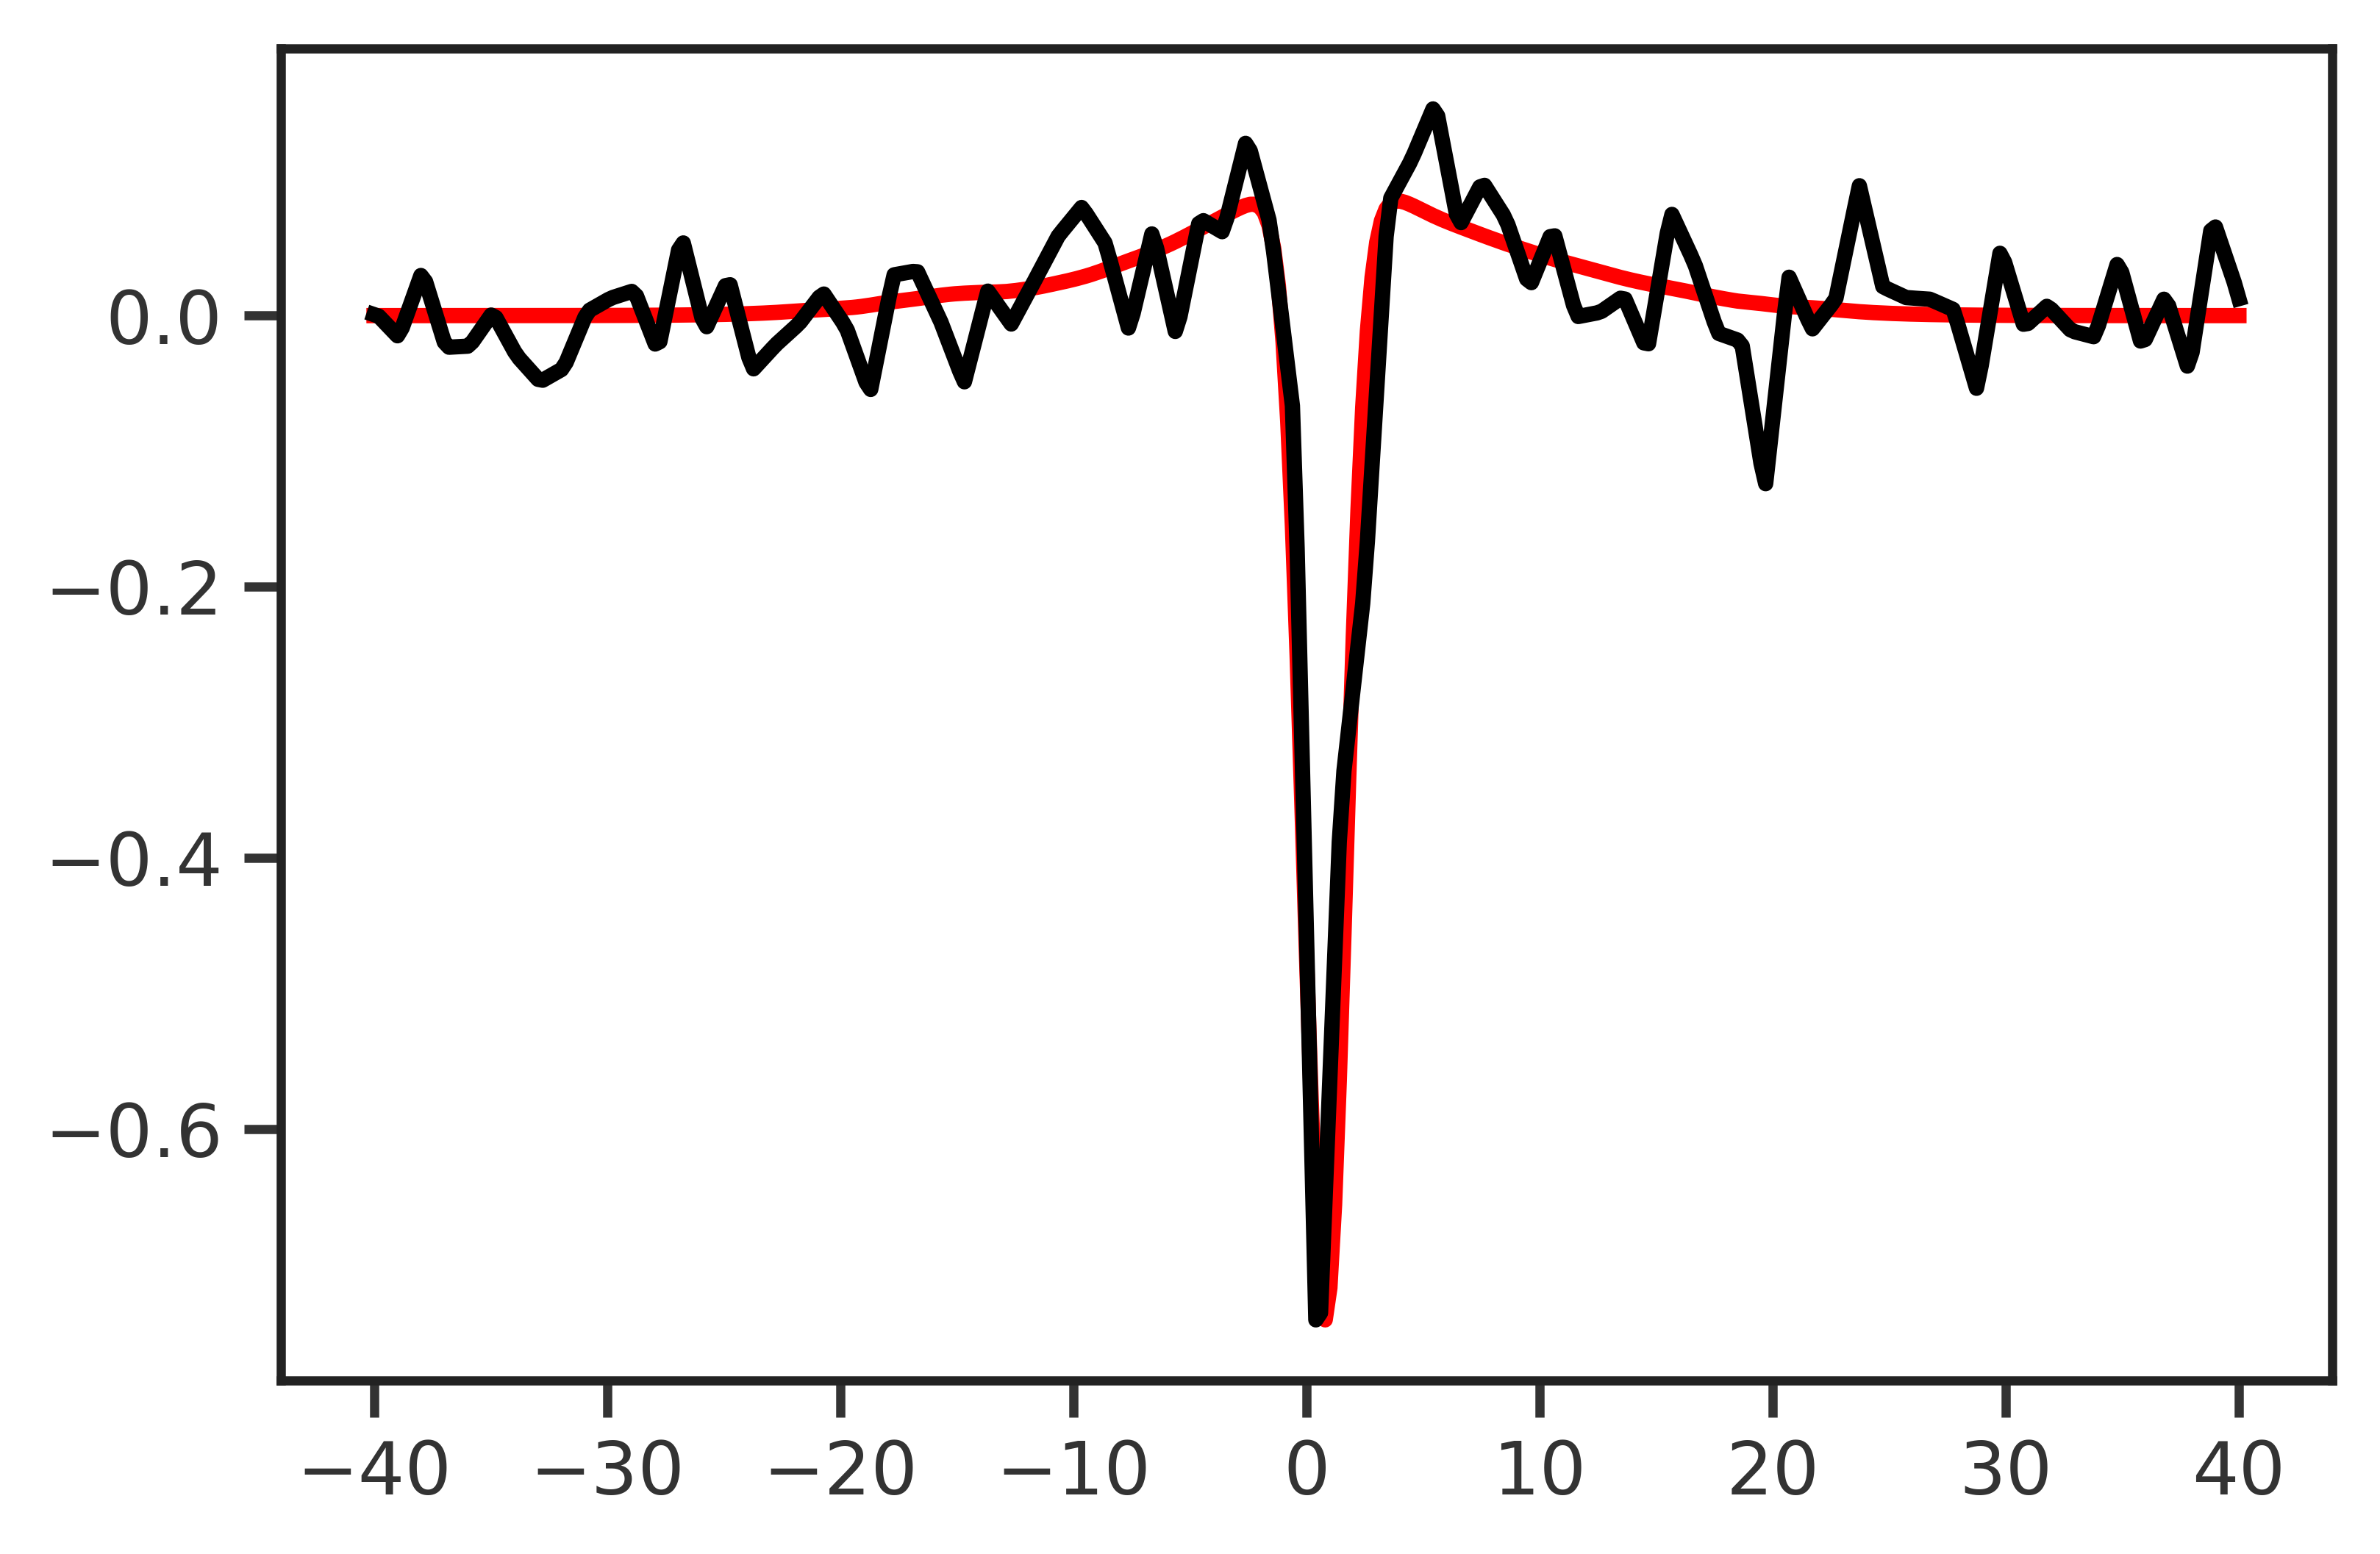

In [182]:
plt.plot(space, normed_rf, 'r')
plt.plot(space, rf, 'k')

# Perhaps one issue of the fit getting stuck at horz weight = 1 is the vanishing gradient issue... hw = 1 is an absorbing boundary, since I take min(1, abs(hw))

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


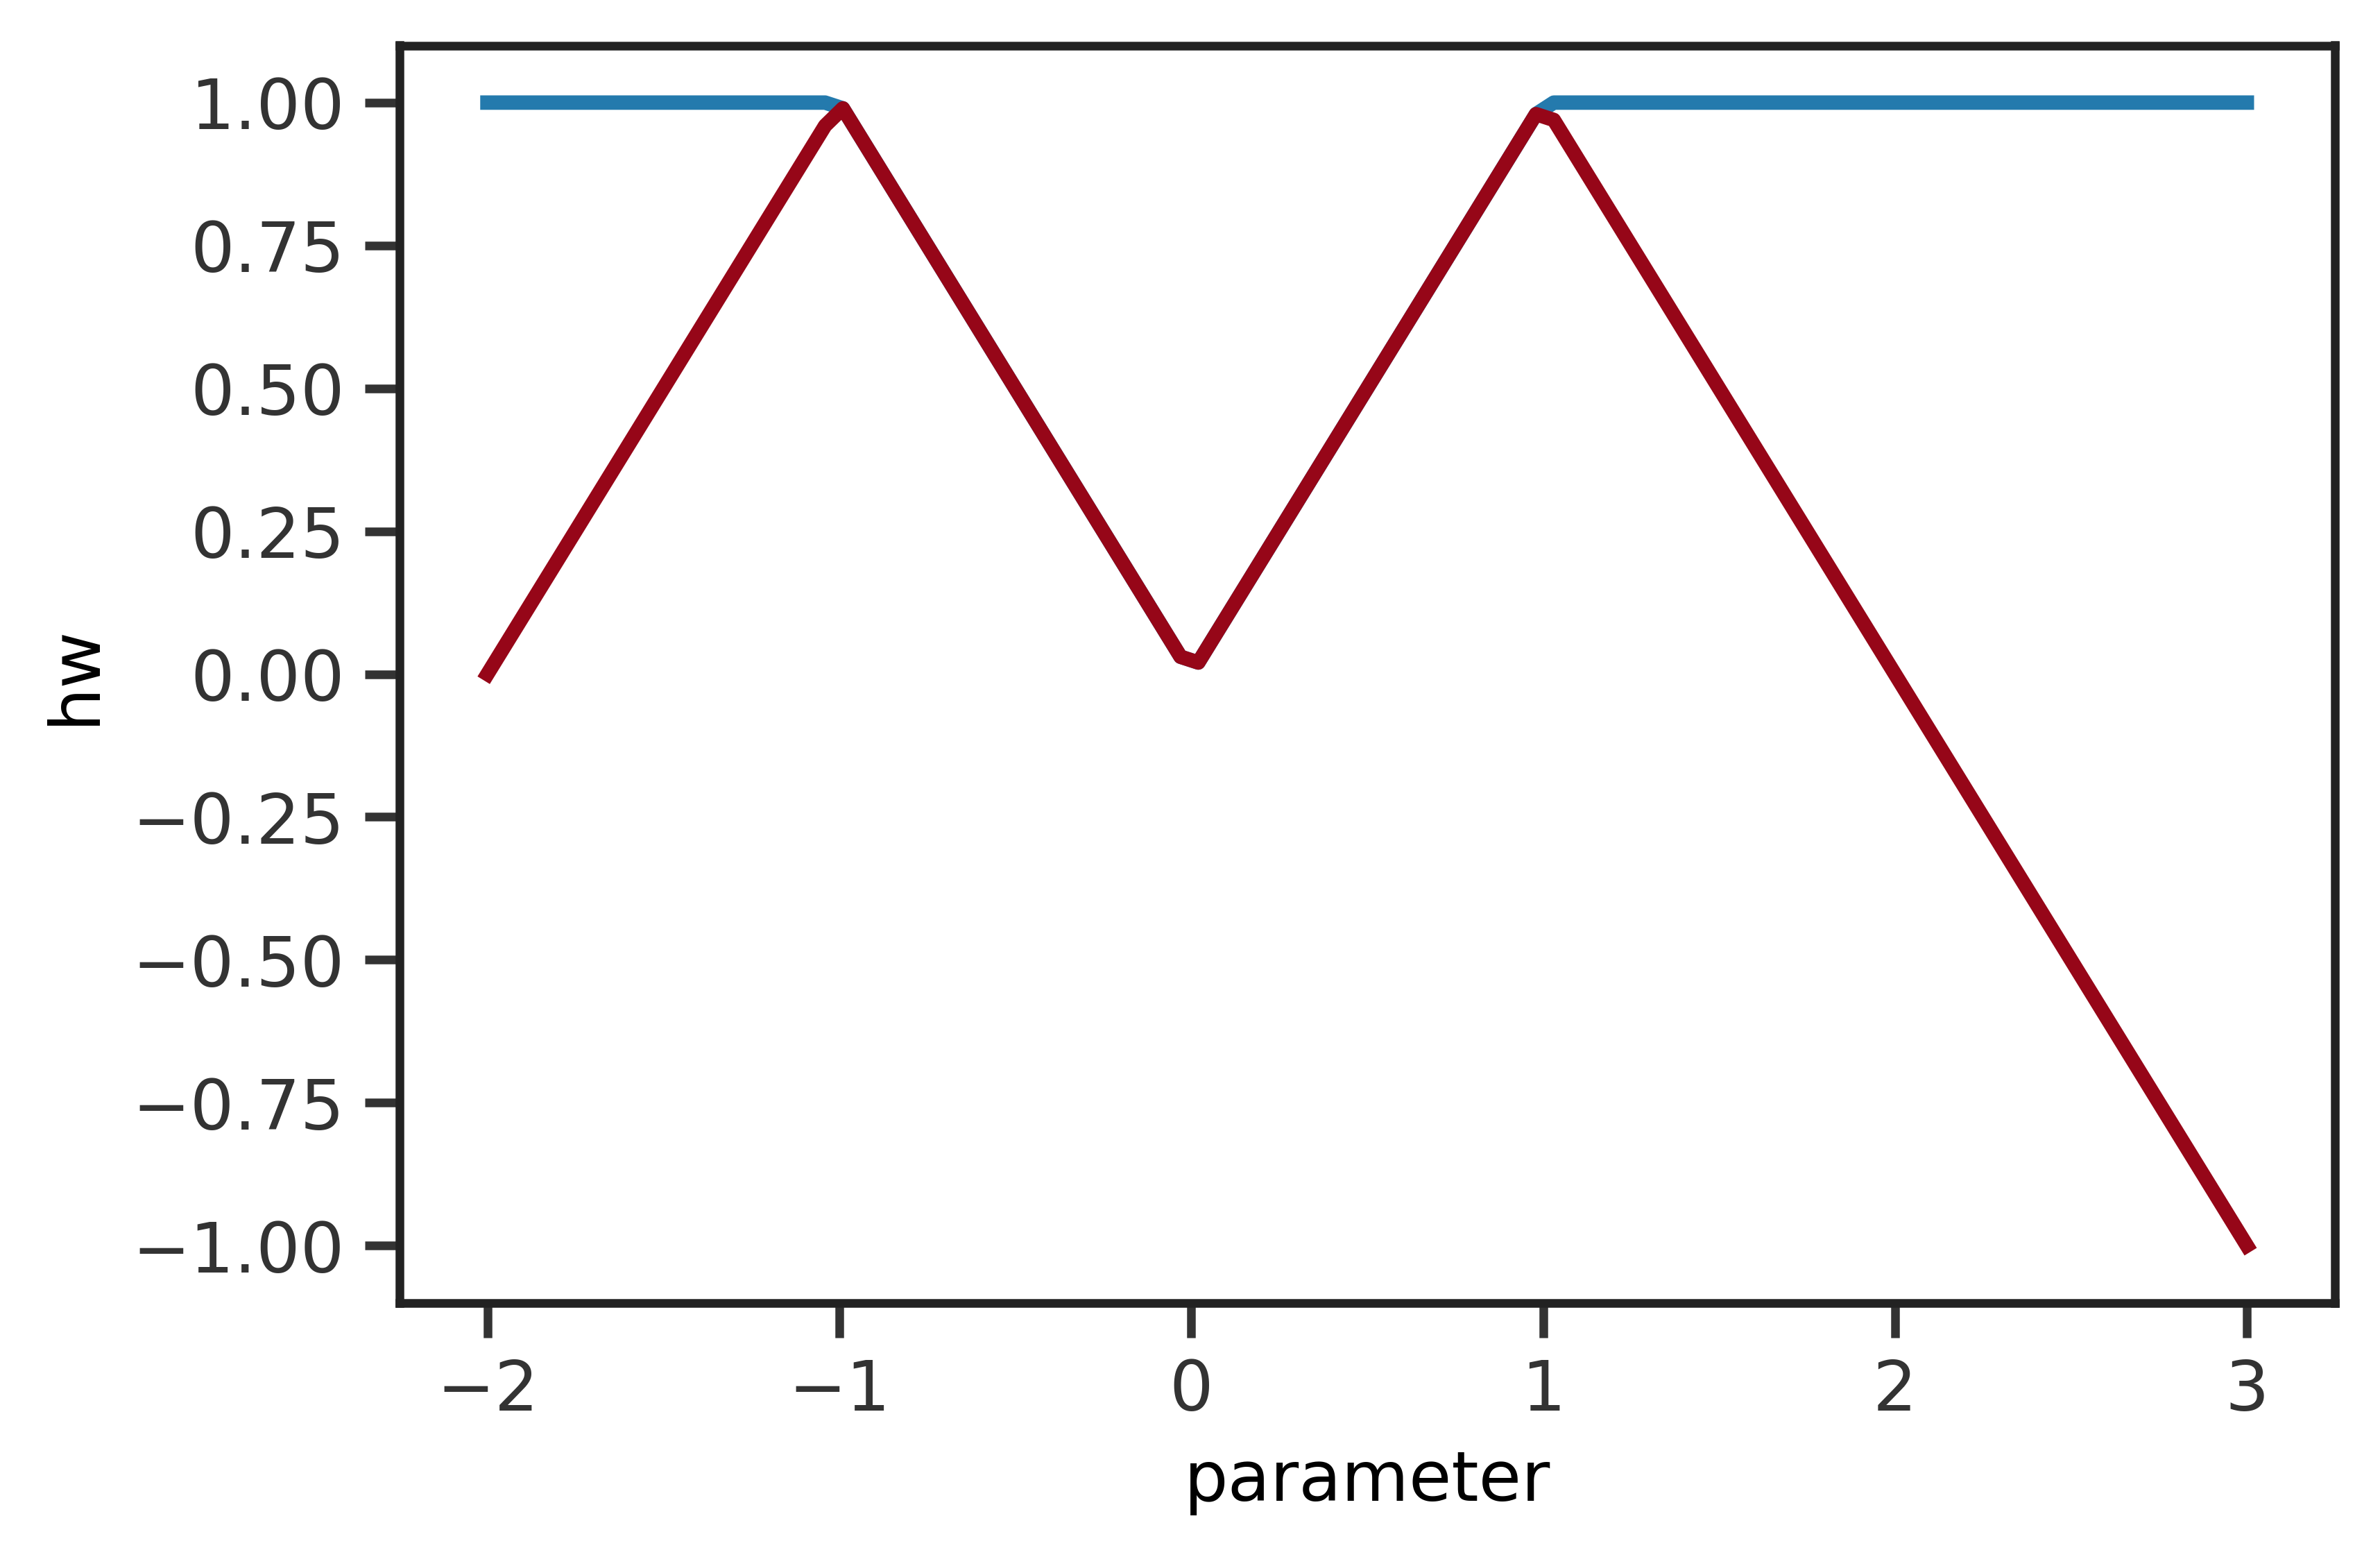

In [196]:
xs = np.linspace(-2,3,100)
plt.plot(xs, [np.min([1.0, abs(x)]) for x in xs])
first_pass = np.where(xs > 1, 1-abs(xs-1), abs(xs))
plt.plot(xs, np.where(first_pass > 1, 1-abs(first_pass-1), first_pass)) 
plt.xlabel('parameter')
plt.ylabel('hw')

In [216]:
iterations = 25

fits = collections.defaultdict(list)
all_params = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)

horz_pf_interp = interp1d(space, horz_pf, bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space, ama_pf, bounds_error=False, fill_value=[0])

def rf_model(width, mean, ama_pos, horz_pos, horz_weight, center_weight):
    #horz_weight = np.min([1.0, abs(horz_weight)])
    first_pass = np.where(horz_weight > 1, 1-abs(horz_weight-1), abs(horz_weight))
    horz_weight = np.where(first_pass > 1, 1-abs(first_pass-1), first_pass)

    center_weight = np.min([1.0, abs(center_weight)])

    center = gaussian(x=space, sigma=abs(width), mu=mean)
    center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

    new_ama_space = np.linspace(np.min(space)-ama_pos, np.max(space)-ama_pos, len(space))
    new_horz_space = np.linspace(np.min(space)-horz_pos, np.max(space)-horz_pos, len(space))
    ama = ama_pf_interp(new_ama_space)/np.sum(ama_pf_interp(new_ama_space))
    horz = horz_pf_interp(new_horz_space)/np.sum(horz_pf_interp(new_horz_space))

    return center_weight*center + (1-center_weight)*(horz_weight*horz + (1-horz_weight)*ama)

for celltype in unduplicated_receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        params = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(unduplicated_receptive_fields[celltype])):
            
            def model_error_to_ganglion_cells(weights):
                width, mean, ama_pos, horz_pos, hw, cw = weights
                modeled_rf = rf_model(width, mean, ama_pos, horz_pos, hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                return sum(abs(normed_rf - rf)**2)

            best_fit_err = np.inf
            for itr in range(iterations):
                # center width
                # center position
                # ama position
                # horz position
                # horz/ama weight
                # center/surr weight
                this_popt = minimize(model_error_to_ganglion_cells, np.hstack([center_widths[celltype][i]+0.5*np.random.randn(1),
                                                                               0.1*np.random.randn(3),
                                                                               np.random.rand(2)]),
                                    method='L-BFGS-B',
                                    bounds=[(1e-6,None), (np.min(space),np.max(space)), (np.min(space),np.max(space)),
                                           (np.min(space),np.max(space)), (-0.2,1.2), (0,1)])
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            modeled_rf = rf_model(*popt.x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
            # push fits between 0 and 1
            x = np.where(abs(popt.x[-2:]) > 1, 1, abs(popt.x[-2:]))

            popts.append(x)
            params.append(popt.x)
            abs_errors[celltype].append(popt.fun)
            mean_squared_errors[celltype].append(mse)
            variances[celltype].append(np.var(rf))

        fits[celltype] = np.stack(popts)
        all_params[celltype] = np.stack(params)


0it [00:00, ?it/s]
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/scipy/interpolate/interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/usr/local/lib/python3.5/dist-packages/scipy/interpolate/interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
8it [02:15, 17.04s/it]

KeyboardInterrupt: 

In [217]:
params

[array([  4.20504745e-01,   1.20334631e-01,   2.77132097e+00,
          1.13570030e-01,  -2.29515351e-09,   5.25427439e-01]),
 array([ 1.93804075,  0.73639832,  1.80904523, -9.87587013, -0.2       ,
         0.53148852]),
 array([  2.59727386,  -0.70168993,  -2.21105527,  13.13934662,
          0.06032193,   0.51991901]),
 array([ 2.63056544,  0.46460755,  0.52970837, -2.0891298 ,  0.28666037,
         0.56396237]),
 array([ 2.9761236 ,  1.02411873, -3.77828368,  0.83912988,  1.2       ,
         0.53565058]),
 array([  0.67148859,   0.12217031,   6.63330341,  11.2562661 ,
          1.2       ,   0.70668707]),
 array([ 0.77150521,  0.37707289,  7.18937101, -4.82408139, -0.2       ,
         0.74132096]),
 array([  1.81161921e+00,   3.11018955e-01,   2.61306533e+00,
          7.33852962e-04,   6.88778030e-08,   7.87395277e-01])]

0.316156833312


/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


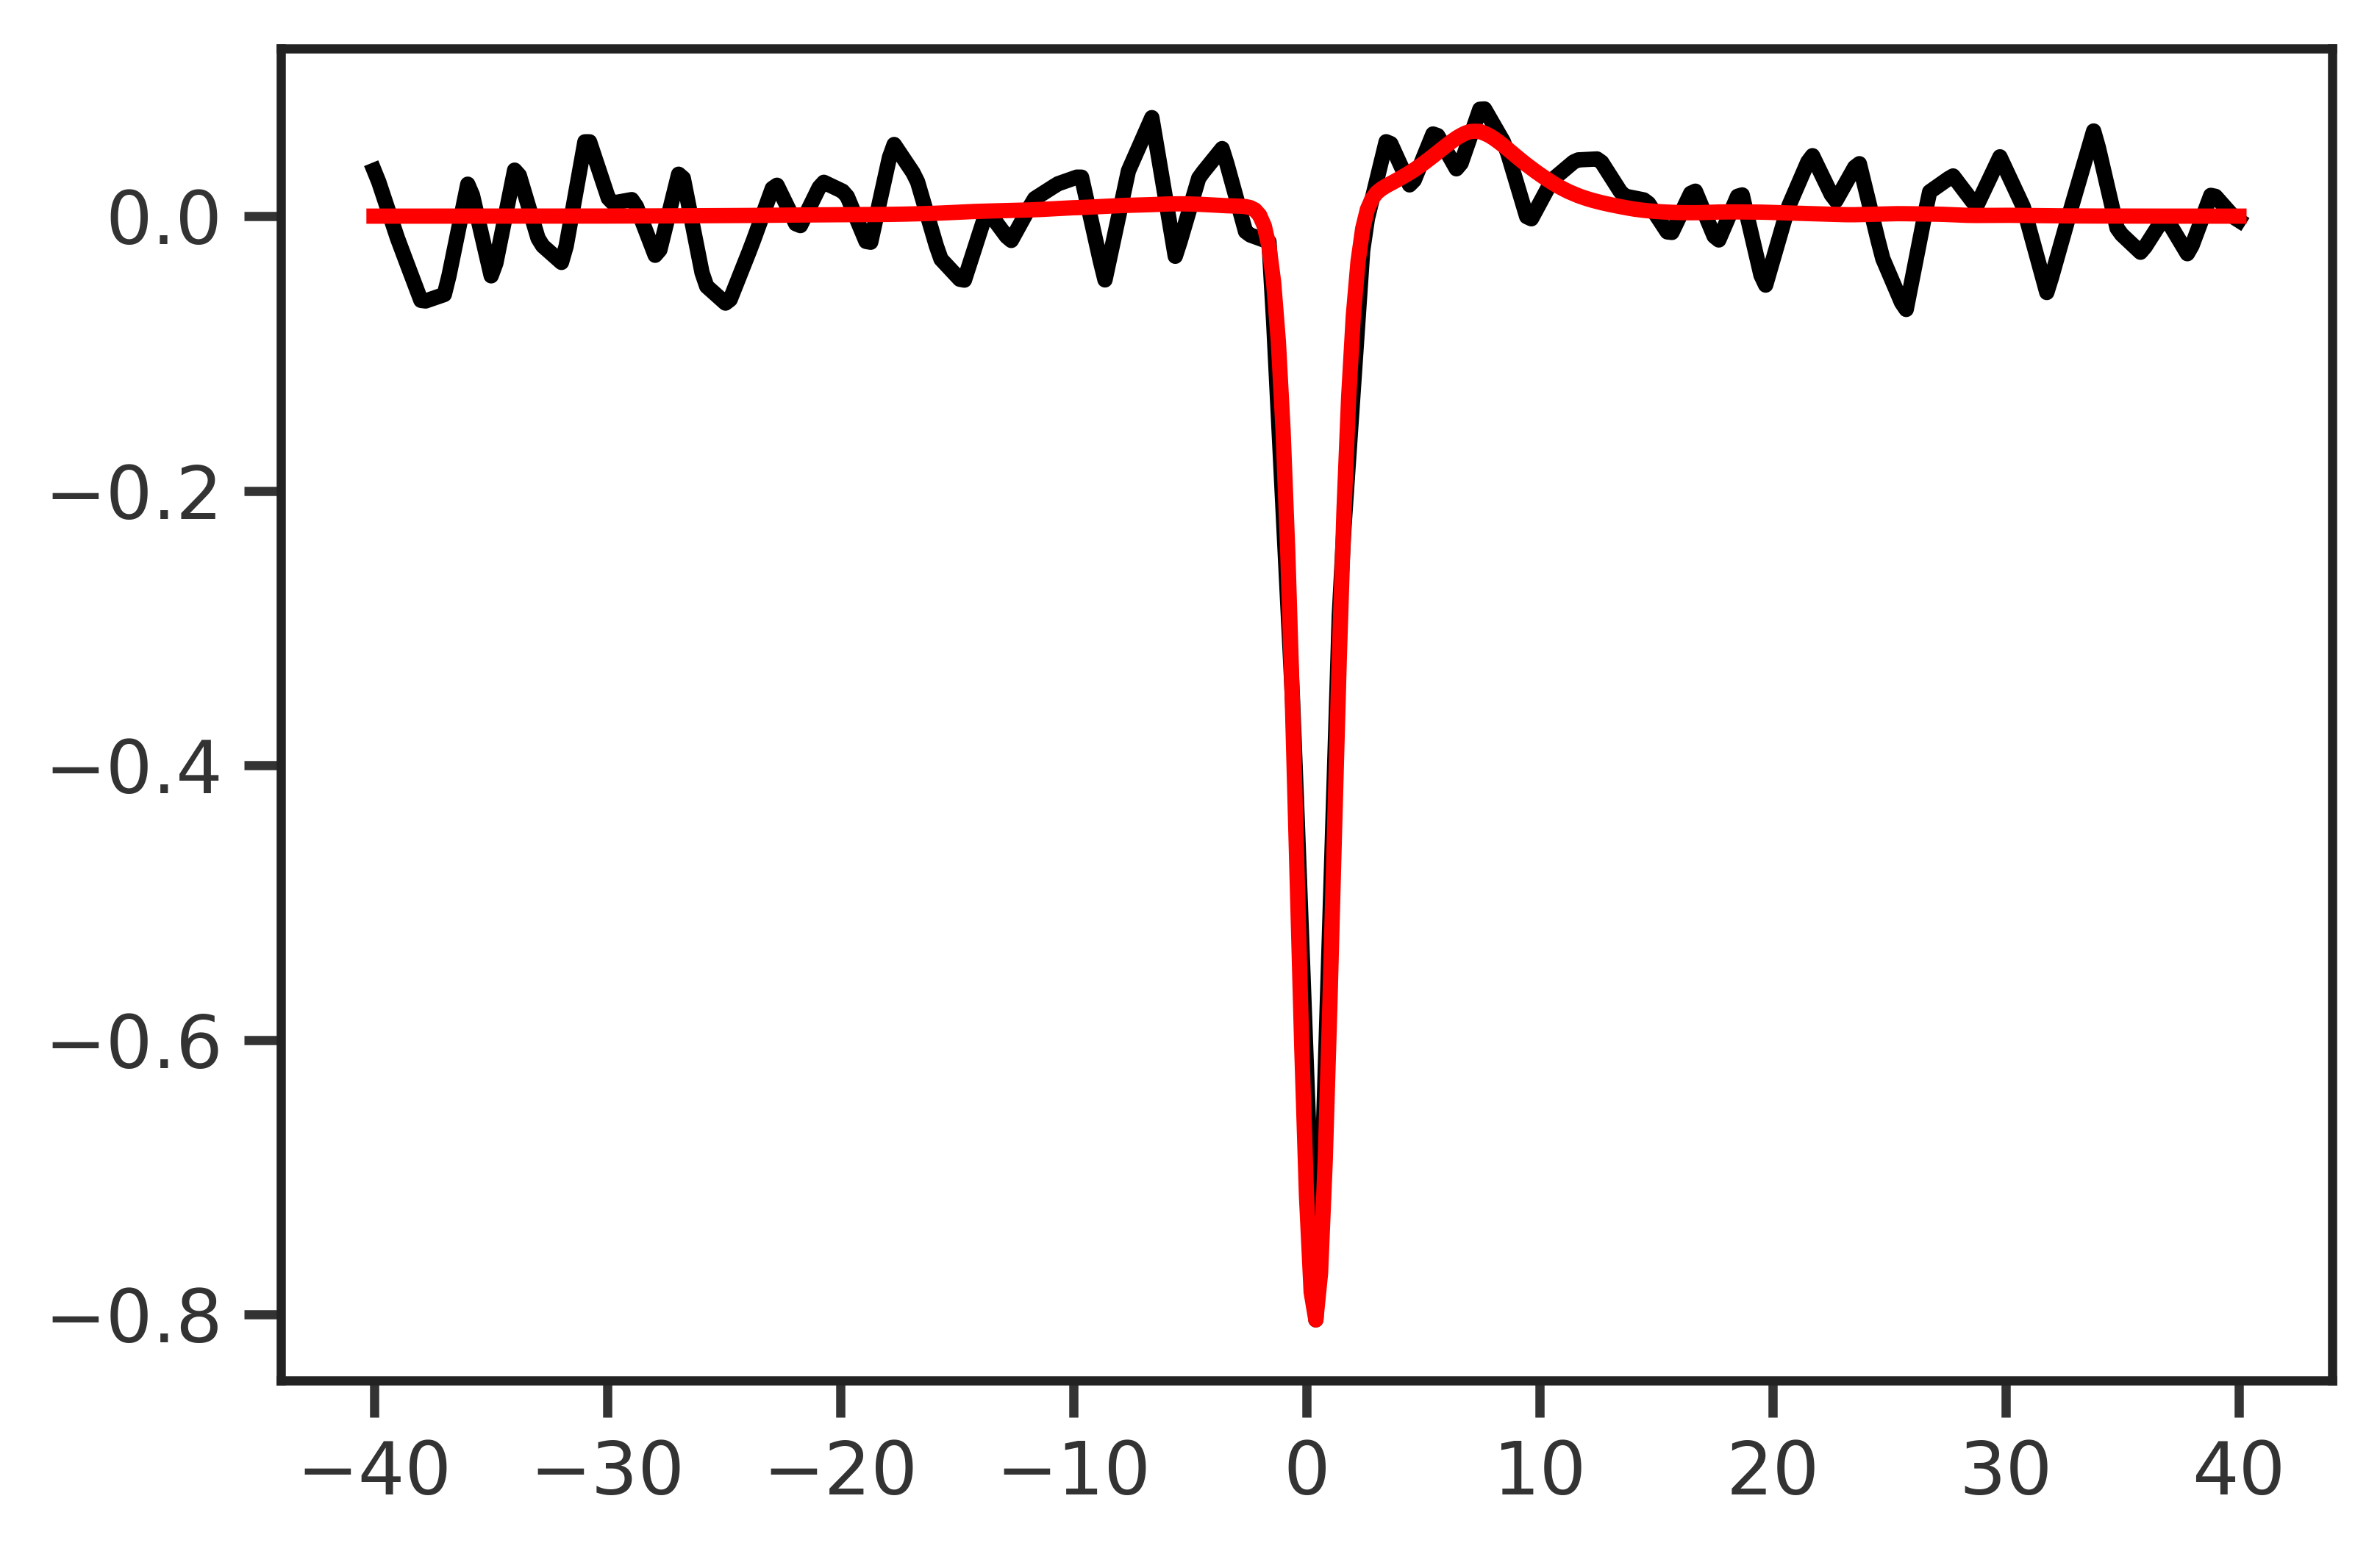

In [218]:
cell_id = 6
rf = unduplicated_receptive_fields[celltype][cell_id]
# width, mean, ama_pos, horz_pos, hw, cw = all_params['medium_off_adapting'][cell_id]
# width, mean, ama_pos, horz_pos, hw, cw = params[cell_id]
# modeled_rf = rf_model(*this_popt.x)
modeled_rf = rf_model(*params[cell_id])
# modeled_rf = rf_model(2.72419965,  0.17496017, -0.20530527, -0.81051504,  1.25692458, 0.56142647)
# modeled_rf = rf_model(width, mean, ama_pos, horz_pos, 0.5, 0.4)
normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
print(np.sum(abs(normed_rf - rf)**2))
plt.plot(space, rf, 'k')
plt.plot(space, normed_rf, 'r')

0.578651386954


/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


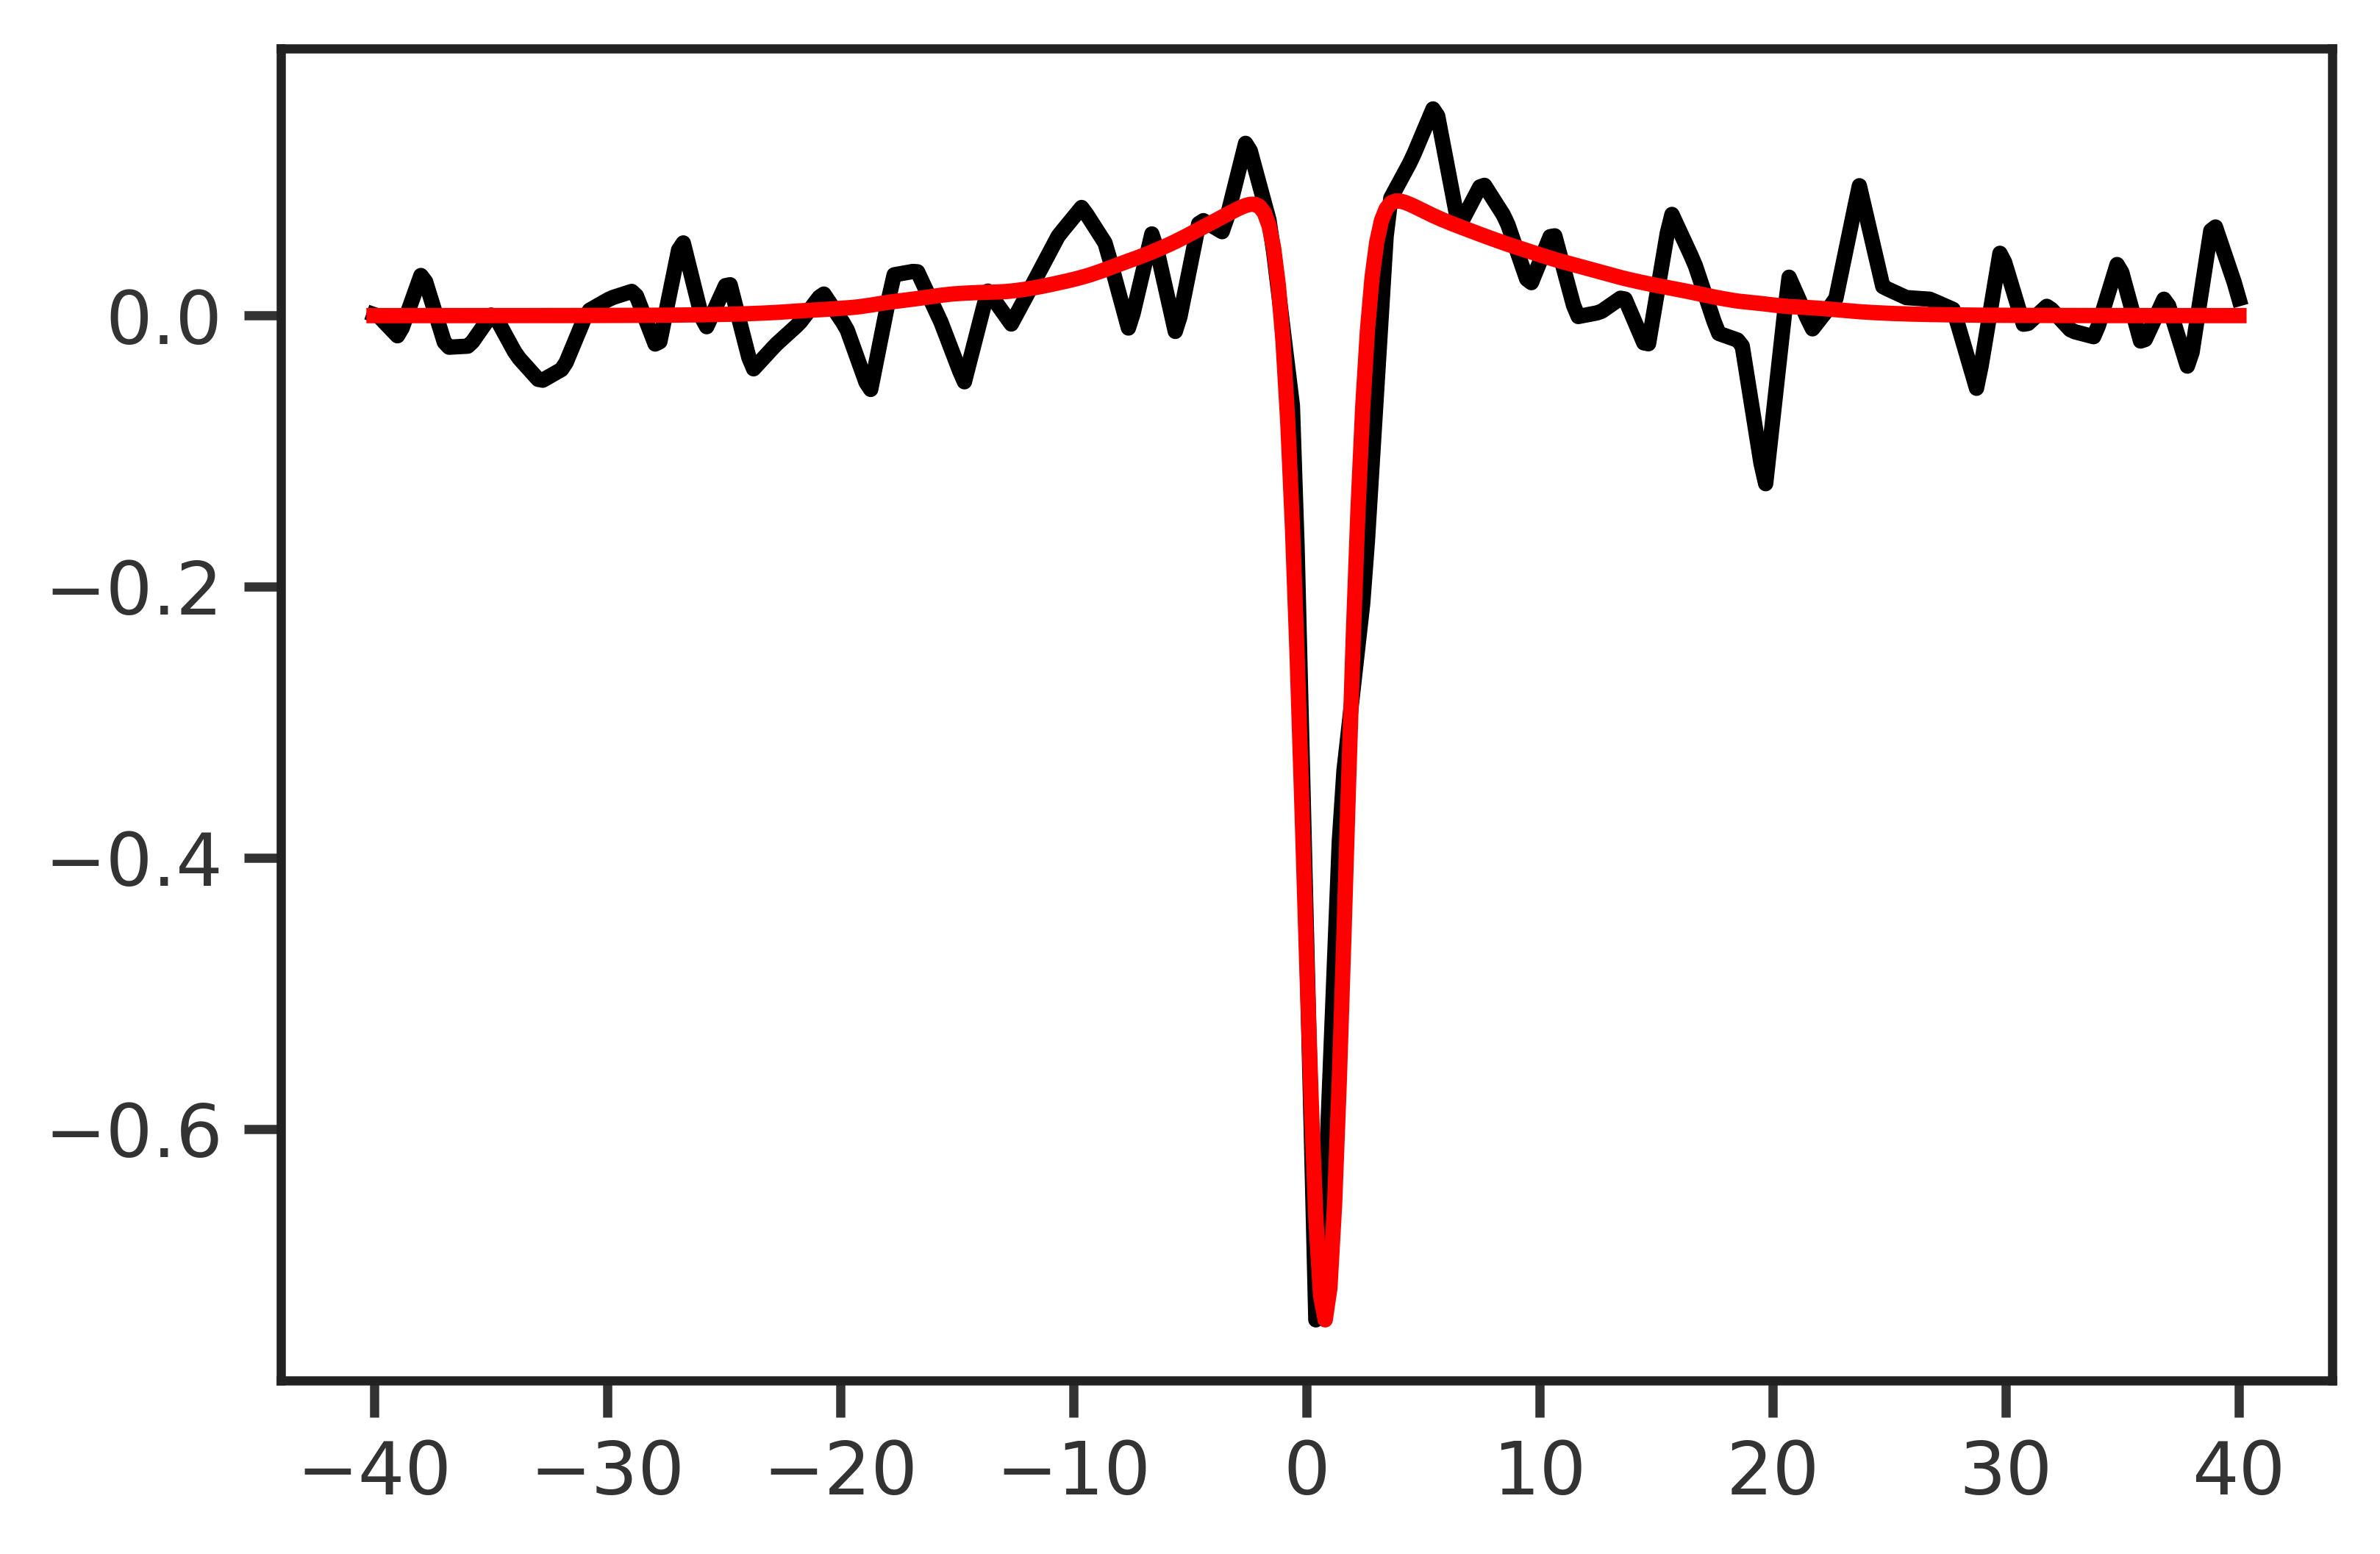

In [219]:
cell_id = i
rf = unduplicated_receptive_fields[celltype][cell_id]
# width, mean, ama_pos, horz_pos, hw, cw = all_params['medium_off_adapting'][cell_id]
# width, mean, ama_pos, horz_pos, hw, cw = params[cell_id]
modeled_rf = rf_model(*this_popt.x)
# modeled_rf = rf_model(*params[cell_id])
# modeled_rf = rf_model(2.72419965,  0.17496017, -0.20530527, -0.81051504,  1.25692458, 0.56142647)
# modeled_rf = rf_model(width, mean, ama_pos, horz_pos, 0.5, 0.4)
normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
print(np.sum(abs(normed_rf - rf)**2))
plt.plot(space, rf, 'k')
plt.plot(space, normed_rf, 'r')

## Alternative parameterization of horz weight

In [223]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

In [232]:
sigmoid(-7)

0.00091105119440064539

In [233]:
iterations = 25

fits = collections.defaultdict(list)
all_params = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)

horz_pf_interp = interp1d(space, horz_pf, bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space, ama_pf, bounds_error=False, fill_value=[0])

def rf_model(width, mean, ama_pos, horz_pos, horz_weight, center_weight):
    #horz_weight = np.min([1.0, abs(horz_weight)])
#     first_pass = np.where(horz_weight > 1, 1-abs(horz_weight-1), abs(horz_weight))
#     horz_weight = np.where(first_pass > 1, 1-abs(first_pass-1), first_pass)
    horz_weight = sigmoid(horz_weight)

    center_weight = np.min([1.0, abs(center_weight)])

    center = gaussian(x=space, sigma=abs(width), mu=mean)
    center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

    new_ama_space = np.linspace(np.min(space)-ama_pos, np.max(space)-ama_pos, len(space))
    new_horz_space = np.linspace(np.min(space)-horz_pos, np.max(space)-horz_pos, len(space))
    ama = ama_pf_interp(new_ama_space)/np.sum(ama_pf_interp(new_ama_space))
    horz = horz_pf_interp(new_horz_space)/np.sum(horz_pf_interp(new_horz_space))

    return center_weight*center + (1-center_weight)*(horz_weight*horz + (1-horz_weight)*ama)

for celltype in unduplicated_receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        params = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(unduplicated_receptive_fields[celltype])):
            
            def model_error_to_ganglion_cells(weights):
                width, mean, ama_pos, horz_pos, hw, cw = weights
                modeled_rf = rf_model(width, mean, ama_pos, horz_pos, hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                return sum(abs(normed_rf - rf)**2)

            best_fit_err = np.inf
            for itr in range(iterations):
                # center width
                # center position
                # ama position
                # horz position
                # horz/ama weight
                # center/surr weight
                this_popt = minimize(model_error_to_ganglion_cells, np.hstack([center_widths[celltype][i]+0.5*np.random.randn(1),
                                                                               0.1*np.random.randn(3),
                                                                               np.random.rand(2)]),
                                    method='L-BFGS-B',
                                    bounds=[(1e-6,None), (np.min(space),np.max(space)), (np.min(space),np.max(space)),
                                           (np.min(space),np.max(space)), (None,None), (0,1)])
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            modeled_rf = rf_model(*popt.x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
            # push fits between 0 and 1
            x = np.where(abs(popt.x[-2:]) > 1, 1, abs(popt.x[-2:]))

            popts.append(x)
            params.append(popt.x)
            abs_errors[celltype].append(popt.fun)
            mean_squared_errors[celltype].append(mse)
            variances[celltype].append(np.var(rf))

        fits[celltype] = np.stack(popts)
        all_params[celltype] = np.stack(params)


0it [00:00, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/scipy/interpolate/interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/usr/local/lib/python3.5/dist-packages/scipy/interpolate/interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]

1it [00:10, 10.26s/it]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
8it [02:01, 14.07s/it]

KeyboardInterrupt: 

0.315254352763


/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


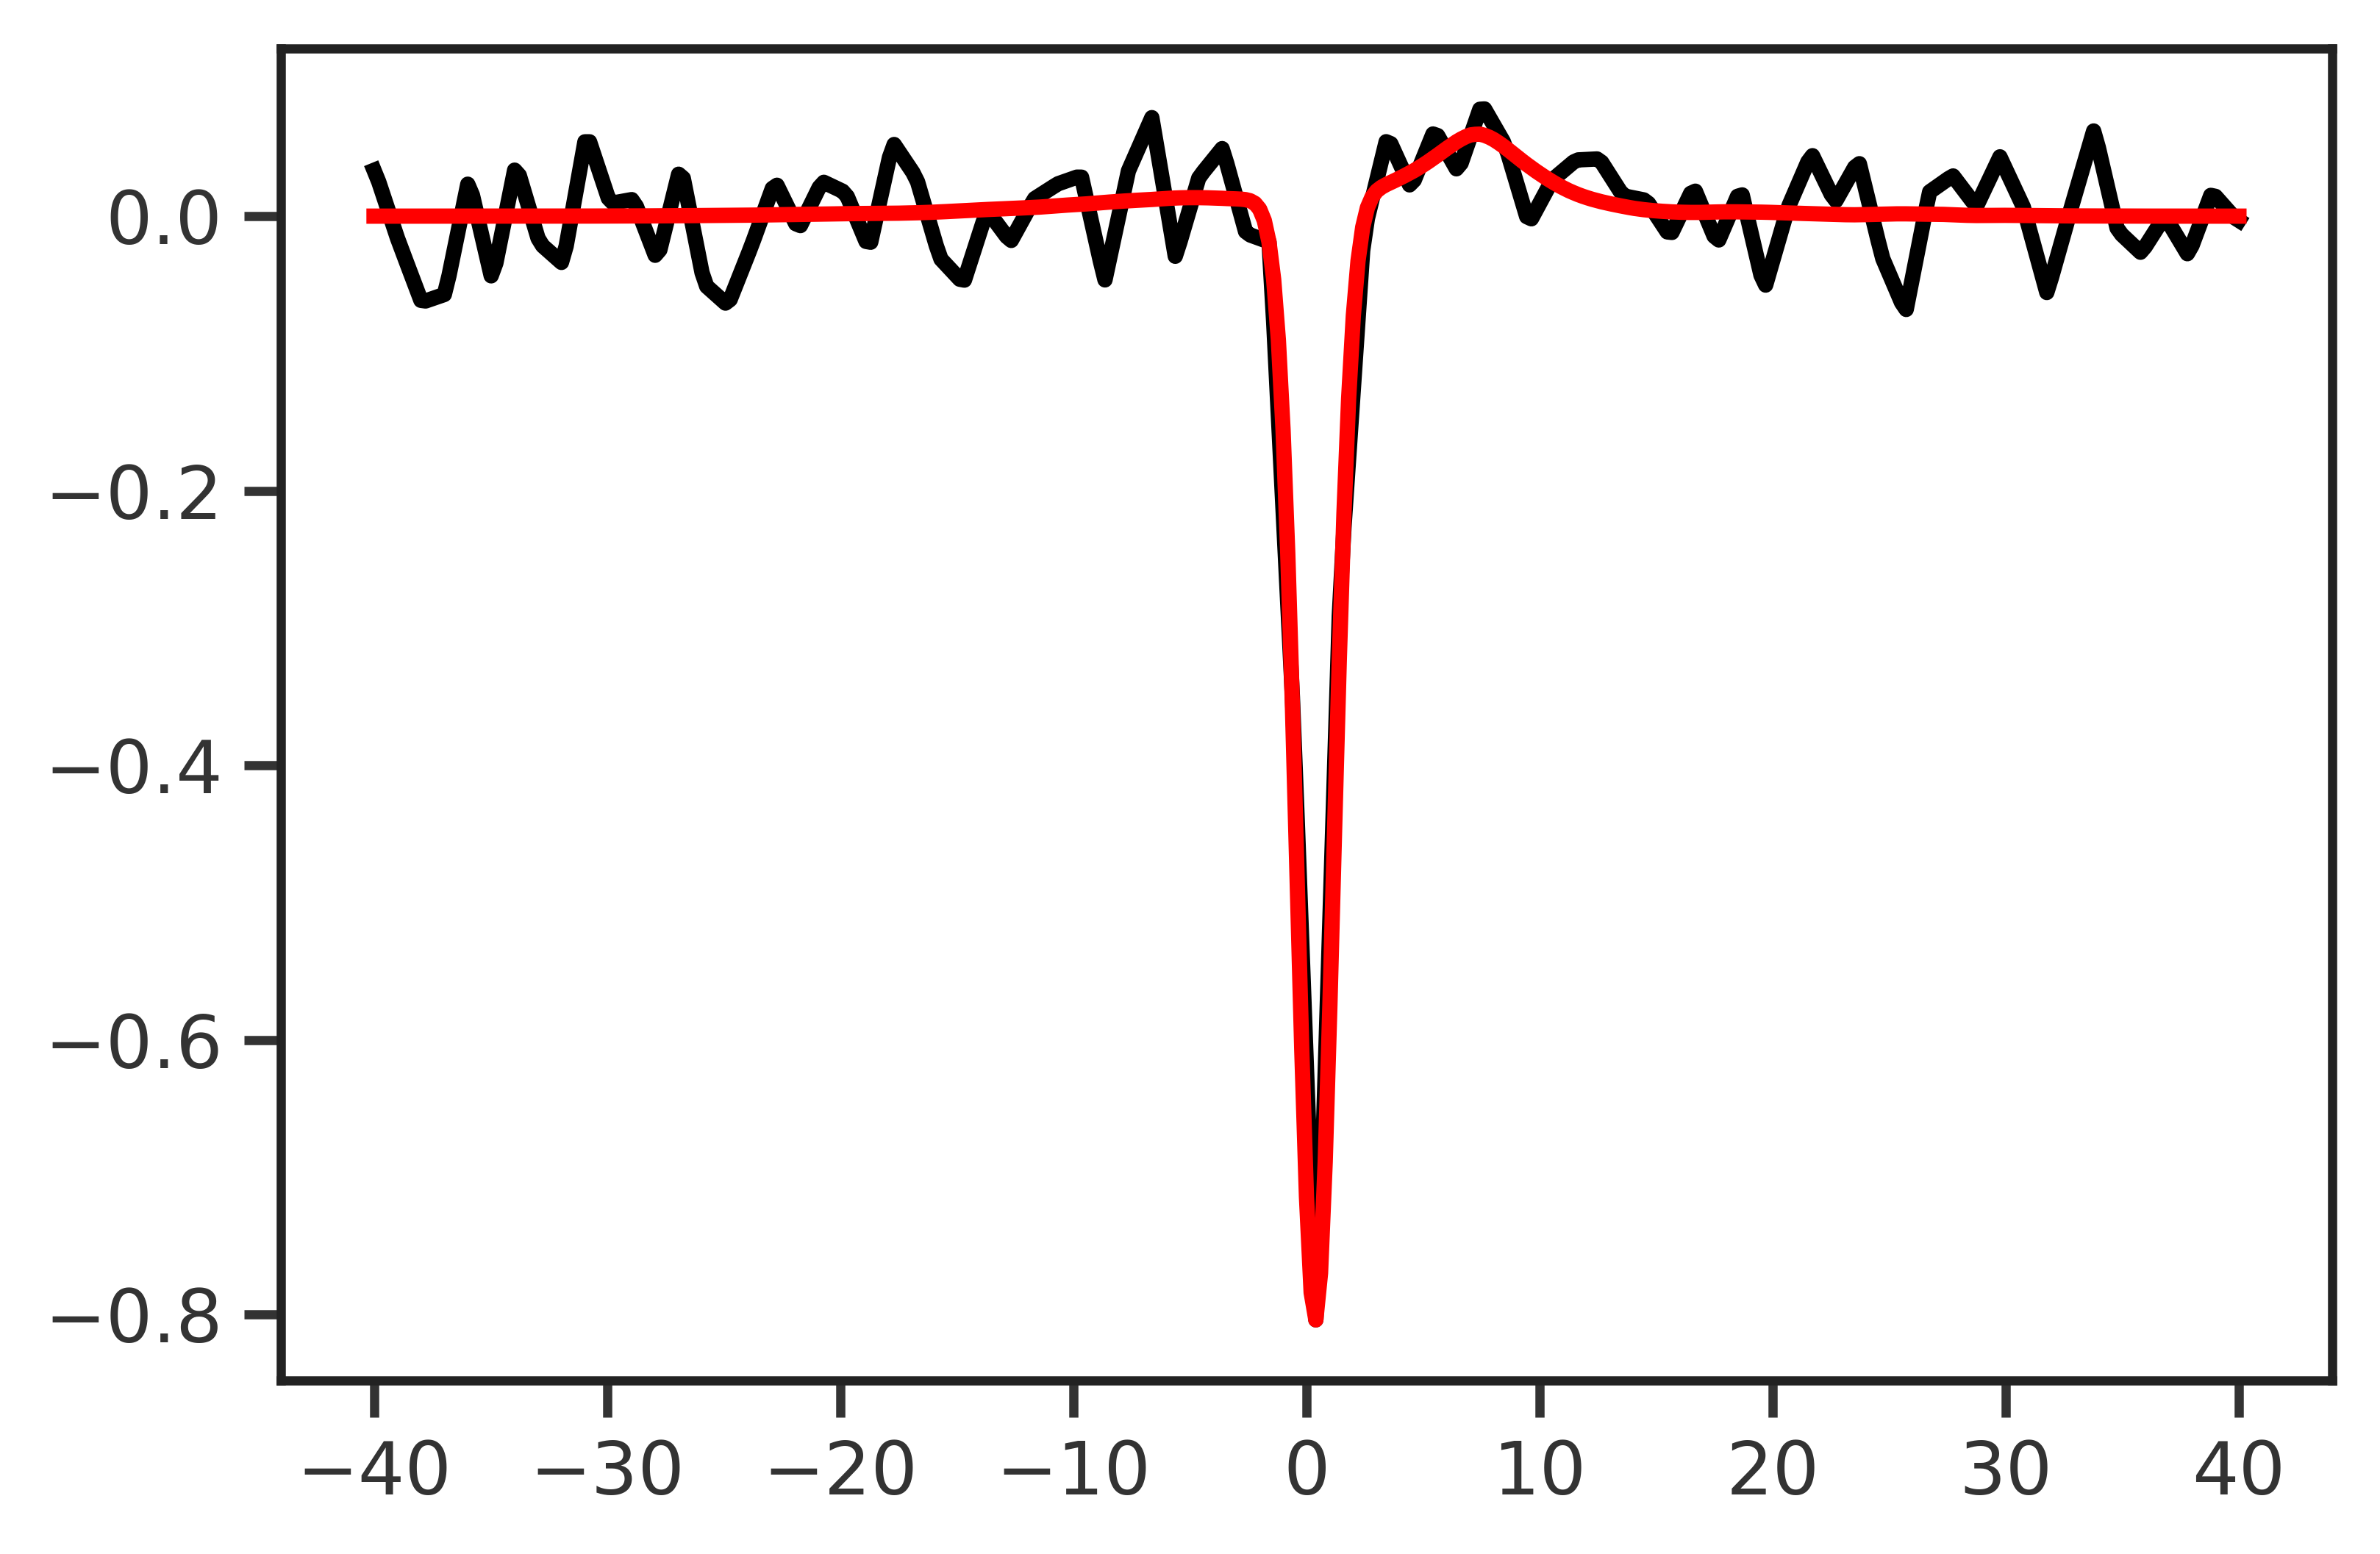

In [241]:
cell_id = 6
rf = unduplicated_receptive_fields[celltype][cell_id]
# width, mean, ama_pos, horz_pos, hw, cw = all_params['medium_off_adapting'][cell_id]
# width, mean, ama_pos, horz_pos, hw, cw = params[cell_id]
# modeled_rf = rf_model(*this_popt.x)
modeled_rf = rf_model(*params[cell_id])
# modeled_rf = rf_model(2.72419965,  0.17496017, -0.20530527, -0.81051504,  1.25692458, 0.56142647)
# modeled_rf = rf_model(width, mean, ama_pos, horz_pos, 0.5, 0.4)
normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
print(np.sum(abs(normed_rf - rf)**2))
plt.plot(space, rf, 'k')
plt.plot(space, normed_rf, 'r')

In [242]:
mean_squared_errors

defaultdict(list,
            {'slow_off': [0.0048685528113012709,
              0.00073893407417509598,
              0.0010013180261333068,
              0.00038265147755676282,
              0.0012165500192033221,
              0.0014321630694602082,
              0.00079011115980618795,
              0.0030940659104353686]})

In [237]:
np.stack(params)[:,-1]

array([ 0.52545777,  0.55888549,  0.51991562,  0.56396234,  0.5104059 ,
        0.78393958,  0.72280156,  0.75782286])

In [240]:
for s in sigmoid(np.stack(params)[:,-2]):
    print('%0.2f' %s)

0.00
0.67
0.06
0.29
0.24
0.00
0.33
0.28


## Alright, let's run the full thing!

In [243]:
iterations = 25

fits = collections.defaultdict(list)
all_params = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)

horz_pf_interp = interp1d(space, horz_pf, bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space, ama_pf, bounds_error=False, fill_value=[0])

def rf_model(width, mean, ama_pos, horz_pos, horz_weight, center_weight):
    #horz_weight = np.min([1.0, abs(horz_weight)])
#     first_pass = np.where(horz_weight > 1, 1-abs(horz_weight-1), abs(horz_weight))
#     horz_weight = np.where(first_pass > 1, 1-abs(first_pass-1), first_pass)
    horz_weight = sigmoid(horz_weight)

    center_weight = np.min([1.0, abs(center_weight)])

    center = gaussian(x=space, sigma=abs(width), mu=mean)
    center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

    new_ama_space = np.linspace(np.min(space)-ama_pos, np.max(space)-ama_pos, len(space))
    new_horz_space = np.linspace(np.min(space)-horz_pos, np.max(space)-horz_pos, len(space))
    ama = ama_pf_interp(new_ama_space)/np.sum(ama_pf_interp(new_ama_space))
    horz = horz_pf_interp(new_horz_space)/np.sum(horz_pf_interp(new_horz_space))

    return center_weight*center + (1-center_weight)*(horz_weight*horz + (1-horz_weight)*ama)

for celltype in unduplicated_receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        params = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(unduplicated_receptive_fields[celltype])):
            
            def model_error_to_ganglion_cells(weights):
                width, mean, ama_pos, horz_pos, hw, cw = weights
                modeled_rf = rf_model(width, mean, ama_pos, horz_pos, hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                return sum(abs(normed_rf - rf)**2)

            best_fit_err = np.inf
            for itr in range(iterations):
                # center width
                # center position
                # ama position
                # horz position
                # horz/ama weight
                # center/surr weight
                this_popt = minimize(model_error_to_ganglion_cells, np.hstack([center_widths[celltype][i]+0.5*np.random.randn(1),
                                                                               0.1*np.random.randn(3),
                                                                               np.random.randn(1),
                                                                               np.random.rand(1)]),
                                    method='L-BFGS-B',
                                    bounds=[(1e-6,None), (np.min(space),np.max(space)), (np.min(space),np.max(space)),
                                           (np.min(space),np.max(space)), (None,None), (0,1)])
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            modeled_rf = rf_model(*popt.x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
            # push fits between 0 and 1
            x = np.where(abs(popt.x[-2:]) > 1, 1, abs(popt.x[-2:]))

            popts.append(x)
            params.append(popt.x)
            abs_errors[celltype].append(popt.fun)
            mean_squared_errors[celltype].append(mse)
            variances[celltype].append(np.var(rf))

        fits[celltype] = np.stack(popts)
        all_params[celltype] = np.stack(params)


0it [00:00, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/scipy/interpolate/interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/usr/local/lib/python3.5/dist-packages/scipy/interpolate/interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]

11it [02:44, 15.24s/it]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
22it [05:59, 12.24s/it]

KeyboardInterrupt: 

# Innovations in this latest fitting:  
    - switch to L-BFGS-B algorithm for minimization  
    - reparameterize horizontal weight as sigmoid(param) to enforce smooth gradients and 0,1 boundedness
    - remove duplicated receptive fields  
    - add spatial offset to Gaussian center, horizontal, and amacrine components  
    - add width parameter to Gaussian center